In [1]:
import pandas as pd
import numpy as np
import pypsa


In [2]:
n = pypsa.Network()

# Define hourly snapshots for full 2027
n.set_snapshots(pd.date_range("2027-01-01 00:00", "2027-12-31 23:00", freq="h"))

print("✅ Network initialized with snapshots:", len(n.snapshots))

✅ Network initialized with snapshots: 8760


In [3]:
# --------------------------------------------------
# 1️⃣ Load heat demand data (Esbjerg only)
# --------------------------------------------------
file_path = "Master_data.xlsx"
sheet_name = "Heat demand"

df_heat = pd.read_excel(file_path, sheet_name=sheet_name)
df_heat["Time"] = pd.to_datetime(df_heat["Time"])
df_heat.set_index("Time", inplace=True)

# ✅ Use "Esbjerg" column instead of "Total"
heat_demand = df_heat["Total"].rename("Heat_Demand_MW")

print("✅ Loaded heat demand data (Esbjerg only)")
print("Time range:", heat_demand.index.min(), "→", heat_demand.index.max())
print("Entries:", len(heat_demand))
print(f"Peak demand: {heat_demand.max():.2f} MW")
print(f"Annual total: {heat_demand.sum():,.0f} MWh")
print("\nFirst few values:")
print(heat_demand.head())

✅ Loaded heat demand data (Esbjerg only)
Time range: 2027-01-01 00:00:00 → 2027-12-31 23:00:00
Entries: 8760
Peak demand: 330.79 MW
Annual total: 1,236,001 MWh

First few values:
Time
2027-01-01 00:00:00    165.60
2027-01-01 01:00:00    171.68
2027-01-01 02:00:00    166.27
2027-01-01 03:00:00    166.51
2027-01-01 04:00:00    169.63
Name: Heat_Demand_MW, dtype: float64


In [4]:
# Align to 2027 hourly index (if not already)
heat_demand = heat_demand.reindex(n.snapshots, method="nearest").fillna(method="ffill")

print("✅ Heat demand aligned to network snapshots")
print("Range:", heat_demand.index.min(), "→", heat_demand.index.max())
print("Sample:\n", heat_demand.head())


✅ Heat demand aligned to network snapshots
Range: 2027-01-01 00:00:00 → 2027-12-31 23:00:00
Sample:
 snapshot
2027-01-01 00:00:00    165.60
2027-01-01 01:00:00    171.68
2027-01-01 02:00:00    166.27
2027-01-01 03:00:00    166.51
2027-01-01 04:00:00    169.63
Freq: h, Name: Heat_Demand_MW, dtype: float64


C:\Users\elshq\AppData\Local\Temp\ipykernel_4140\3910527636.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [5]:
# --------------------------------------------------
# 2️⃣ Load electricity price data (2024 sheet → map sequentially to 2027)
#     Your sheet starts on Jan 2, 2024 and has exactly 8760 rows.
#     We ignore the 'date' column and map row order to 2027 snapshots.
# --------------------------------------------------
sheet_price = "Electricity price 2024"
df_price = pd.read_excel(file_path, sheet_name=sheet_price)

# Rename defensively (adjust if your column names differ)
df_price.columns = [str(c).strip() for c in df_price.columns]
price_col = [c for c in df_price.columns if "DK1" in c or "Price" in c or "DKK" in c][0]

# Extract values as float array
price_vals = pd.to_numeric(df_price[price_col], errors="coerce").to_numpy()

# Sanity check length
if len(price_vals) != len(n.snapshots):
    raise ValueError(
        f"Price rows ({len(price_vals)}) ≠ snapshots ({len(n.snapshots)}). "
        "Expected 8760 rows (since 2027 is non-leap)."
    )

# ✅ Sequential mapping: first row → 2027-01-01 00:00, etc.
electricity_price = pd.Series(price_vals, index=n.snapshots, name="Electricity_Price")

print("✅ Electricity price mapped sequentially to 2027 snapshots")
print("Range:", electricity_price.index.min(), "→", electricity_price.index.max())
print(electricity_price.head(12))


✅ Electricity price mapped sequentially to 2027 snapshots
Range: 2027-01-01 00:00:00 → 2027-12-31 23:00:00
snapshot
2027-01-01 00:00:00    228.039993
2027-01-01 01:00:00    149.619995
2027-01-01 02:00:00    231.320007
2027-01-01 03:00:00    137.089996
2027-01-01 04:00:00     82.599998
2027-01-01 05:00:00    102.730003
2027-01-01 06:00:00    355.070007
2027-01-01 07:00:00    433.119995
2027-01-01 08:00:00    489.549988
2027-01-01 09:00:00    482.549988
2027-01-01 10:00:00    514.229980
2027-01-01 11:00:00    548.219971
Freq: h, Name: Electricity_Price, dtype: float64


In [6]:
# --- Carriers ---
for carrier in ["electricity", "heat", "waste", "gas", "biomass", "market", "electric_boiler", "heat_pump", "wte_chp"]:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

# --- Buses ---
buses = [
    ("el_bus", "electricity"),
    ("heat_bus", "heat"),
    ("waste_bus", "waste"),
    ("gas_bus", "gas"),
    ("biomass_bus", "biomass"),
    ("market_bus", "market"),
]
for name, carrier in buses:
    if name not in n.buses.index:
        n.add("Bus", name, carrier=carrier)


In [7]:
# --- Add district heating demand load ---
if "heat_demand" not in n.loads.index:
    n.add(
        "Load",
        "heat_demand",
        bus="heat_bus",
        carrier="heat",
        p_set=heat_demand.reindex(n.snapshots).fillna(method="ffill").values
    )

print("✅ Added district heating demand load")


✅ Added district heating demand load


C:\Users\elshq\AppData\Local\Temp\ipykernel_4140\64715060.py:8: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [8]:
# --- Electricity import from market (buy) ---
if "el_import" not in n.generators.index:
    n.add(
        "Generator",
        "el_import",
        bus="el_bus",
        carrier="electricity",
        p_nom=1e6,                     # practically unlimited capacity
        marginal_cost=electricity_price,  # day-ahead price in DKK/MWh
    )

# --- Electricity export to market (sell) ---
if "sell_to_market" not in n.links.index:
    n.add(
        "Link",
        "sell_to_market",
        bus0="el_bus",      # from local grid
        bus1="market_bus",  # to external market
        efficiency=1.0,
        p_nom=1e6,
        marginal_cost=-electricity_price,  # negative => revenue from selling
        carrier="electricity",
    )

print("✅ Added electricity market import/export links")

# Fix: Apply hourly electricity prices to import generator
n.generators_t.marginal_cost["el_import"] = electricity_price.values

print("✅ Applied hourly electricity prices to el_import")
print(f"Price range: {electricity_price.min():.1f} - {electricity_price.max():.1f} DKK/MWh")


✅ Added electricity market import/export links
✅ Applied hourly electricity prices to el_import
Price range: -448.0 - 6982.4 DKK/MWh


In [9]:
print(n.generators_t.marginal_cost.head())


name                  el_import
snapshot                       
2027-01-01 00:00:00  228.039993
2027-01-01 01:00:00  149.619995
2027-01-01 02:00:00  231.320007
2027-01-01 03:00:00  137.089996
2027-01-01 04:00:00   82.599998


In [10]:
# Ensure carriers exist (silence warnings)
for c in ["wte_chp", "gas", "biomass", "waste"]:
    if c not in n.carriers.index:
        n.add("Carrier", c)

# 1) Waste supply (CHP links already carry marginal fuel cost → supply at 0)
if "waste_supply" not in n.generators.index:
    n.add("Generator", "waste_supply",
          bus="waste_bus", carrier="waste",
          p_nom=1e6, marginal_cost=0.0)

# 2) Gas supply (put gas fuel price here if your gas boiler link has only efficiency)
#    If you already put *full* fuel+OPEX on the gas_boiler link, keep this at 0.0
if "gas_supply" not in n.generators.index:
    n.add("Generator", "gas_supply",
          bus="gas_bus", carrier="gas",
          p_nom=1e6, marginal_cost=0.0)   # or your gas fuel DKK/MWh_fuel

# 3) Biomass (woodchip) supply
#    Same rule: if biomass_boiler link holds full marginal cost, keep this at 0.0
if "biomass_supply" not in n.generators.index:
    n.add("Generator", "biomass_supply",
          bus="biomass_bus", carrier="biomass",
          p_nom=1e6, marginal_cost=0.0)   # or biomass fuel DKK/MWh_fuel


In [11]:
# --- Electric Boiler (with startup cost via unit commitment) ---
EB_EFF = 0.99
EB_P_NOM = 40.4  # MW
EB_BASE_LOAD = 0.8           # MW_el (minimum when operating)
EB_OPEX_VAR = 4.2  # DKK/MWh
EB_STARTUP_COST = 150.0      # DKK/start

# Calculate minimum load fraction
EB_P_MIN_PU = EB_BASE_LOAD / EB_P_NOM  # 0.8 / 40.0 = 0.02 (2%)

eb_cost = EB_OPEX_VAR

if "electric_boiler" not in n.links.index:
    n.add(
        "Link",
        "electric_boiler",
        bus0="el_bus",
        bus1="heat_bus",
        efficiency=EB_EFF,
        p_nom=EB_P_NOM,
        p_min_pu=EB_P_MIN_PU,        # Add minimum 2% load
        marginal_cost=eb_cost,       # hourly series
        start_up_cost=EB_STARTUP_COST,         # DKK per start
        committable=True,            # enable UC for this link
        carrier="electric_boiler",
    )

print(f"✅ Electric boiler added:")
print(f"   Electrical: {EB_BASE_LOAD:.1f} - {EB_P_NOM:.1f} MW (min {EB_P_MIN_PU:.1%})")
print(f"   Heat output: {EB_BASE_LOAD * EB_EFF:.1f} - {EB_P_NOM * EB_EFF:.1f} MW")
print(f"   Startup cost: {EB_STARTUP_COST:,.0f} DKK")

✅ Electric boiler added:
   Electrical: 0.8 - 40.4 MW (min 2.0%)
   Heat output: 0.8 - 40.0 MW
   Startup cost: 150 DKK


In [12]:
# --- Heat Pump parameters ---
HP_COP = 3.00                 # coefficient of performance
HP_P_NOM = 23.78              # MW_el (maximum electrical consumption)
HP_BASE_LOAD = 6.56           # MW_el (minimum electrical consumption when ON)
HP_OPEX_VAR = 8.0             # DKK/MWh
HP_STARTUP_COST = 2500.0      # DKK/start

# Calculate minimum load as fraction of maximum
HP_P_MIN_PU = HP_BASE_LOAD / HP_P_NOM  # = 6.56 / 20.50 = 0.32 (32% minimum)

# Marginal cost = electricity price / COP + variable OPEX
hp_cost = HP_OPEX_VAR

# --- Add Heat Pump Link ---
if "heat_pump" not in n.links.index:
    n.add(
        "Link",
        "heat_pump",
        bus0="el_bus",              # consumes electricity
        bus1="heat_bus",            # produces heat
        efficiency=HP_COP,          # heat out per unit electricity in
        p_nom=HP_P_NOM,             # MW_th
        p_min_pu=HP_P_MIN_PU,       # Add minimum load constraint
        marginal_cost=hp_cost,      # hourly time-series cost
        start_up_cost=HP_STARTUP_COST,
        committable=True,           # enables start-up cost behaviour
        carrier="heat_pump"
    )

print(f"✅ Heat pump: {HP_P_NOM:.2f} MW_el input (min {HP_BASE_LOAD:.2f} MW = {HP_P_MIN_PU:.1%})")
print(f"   Heat output: {HP_P_NOM * HP_COP:.1f} MW (min {HP_BASE_LOAD * HP_COP:.1f} MW)")


✅ Heat pump: 23.78 MW_el input (min 6.56 MW = 27.6%)
   Heat output: 71.3 MW (min 19.7 MW)


In [13]:
# --- Natural Gas Boiler (fixed cost conversion) ---
GB_EFF = 0.80
GB_MAX_HEAT = 60.00  # MW_heat
GB_P_NOM = GB_MAX_HEAT / GB_EFF  # MW_fuel (75.00 MW)
GB_P_MIN = 9.7
GB_OPEX_VAR = 41.7        # DKK/MWh_heat
GB_STARTUP_COST = 2500.0  # DKK/start
GB_FUEL_COST = 238.0      # DKK/GJ
GB_RAMP_LIMIT = 0.20              # 20% per hour

# Convert DKK/GJ -> DKK/MWh_fuel (1 MWh = 3.6 GJ)
GB_FUEL_COST_DKK_per_MWh_fuel = GB_FUEL_COST * 3.6               # 856.8

# Heat-basis marginal cost
GB_MARGINAL_COST = GB_FUEL_COST_DKK_per_MWh_fuel / GB_EFF + GB_OPEX_VAR  # ~1112.5

if "gas_boiler" not in n.links.index:
    n.add(
        "Link", "gas_boiler",
        bus0="gas_bus", bus1="heat_bus",
        efficiency=GB_EFF,
        p_nom=GB_P_NOM,
        p_min_pu=GB_P_MIN / GB_P_NOM,
        marginal_cost=GB_MARGINAL_COST,
        start_up_cost=GB_STARTUP_COST,
        committable=True,
        carrier="gas"
    )

print(f"✅ Gas Boiler cost ≈ {GB_MARGINAL_COST:.1f} DKK/MWh_heat (fuel {GB_FUEL_COST*3.6:.1f} per MWh_fuel)")


✅ Gas Boiler cost ≈ 1112.7 DKK/MWh_heat (fuel 856.8 per MWh_fuel)


In [14]:
# --- Biomass (Woodchip) Boiler ---
BB_EFF = 0.80                    # efficiency
BB_MAX_HEAT = 60.8              # MW_heat (max)
BB_P_NOM = BB_MAX_HEAT / BB_EFF  # MW_fuel (max)
BB_P_MIN = 21.30                 # MW_th (min)
BB_OPEX_VAR = 19.30              # DKK/MWh_heat
BB_STARTUP_COST = 100000.0      # DKK/start
BB_FUEL_COST = 68.0              # DKK/GJ
BB_RAMP_LIMIT = 0.20             # 20% per hour

# DKK/GJ -> DKK/MWh_fuel (1 MWh = 3.6 GJ)
BB_FUEL_COST_per_MWh_fuel = BB_FUEL_COST * 3.6          # 244.8

# Heat-basis marginal cost
BB_MARGINAL_COST = BB_FUEL_COST_per_MWh_fuel / BB_EFF + BB_OPEX_VAR  # ≈ 325.3

if "biomass_boiler" not in n.links.index:
    n.add(
        "Link", "biomass_boiler",
        bus0="biomass_bus", bus1="heat_bus",
        efficiency=BB_EFF,
        p_nom=BB_P_NOM,
        p_min_pu=BB_P_MIN / BB_P_NOM,    # ≈ 0.355
        marginal_cost=BB_MARGINAL_COST,
        start_up_cost=BB_STARTUP_COST,
        committable=True,
        carrier="biomass"
    )

print(f"✅ Biomass boiler added | η={BB_EFF}, p_nom={BB_P_NOM} MW, cost≈{BB_MARGINAL_COST:.1f} DKK/MWh_heat")


✅ Biomass boiler added | η=0.8, p_nom=75.99999999999999 MW, cost≈325.3 DKK/MWh_heat


In [15]:
# --- Thermal Storage (Hot Water Tank) ---
TS_CAPACITY_MWh = 2325          # total capacity in MWh (from m.cp.del_t)
TS_E_MIN_PU = 0.10               # 10% minimum
TS_EFF = 0.95                    # round-trip efficiency (typical)
TS_STANDING_LOSS = 0.001         # 0.1%/h heat loss (reasonable default)

if "thermal_storage" not in n.stores.index:
    n.add(
        "Store", "thermal_storage",
        bus="heat_bus",
        e_cyclic=True,            # same SoC start/end (optional)
        e_nom=TS_CAPACITY_MWh,
        e_min_pu=TS_E_MIN_PU,
        standing_loss=TS_STANDING_LOSS,
        carrier="heat"
    )

print(f"✅ Thermal storage added | Capacity={TS_CAPACITY_MWh:.3f} MWh, η={TS_EFF}, min={TS_E_MIN_PU*100:.0f}%")


✅ Thermal storage added | Capacity=2325.000 MWh, η=0.95, min=10%


In [16]:
# ==============================
# WtE CHP - Parameter definition
# ==============================

# --- Efficiency splits
CHP_EFF_E = 0.30                  # electrical efficiency (el/fuel)
CHP_EFF_H = 0.60                  # thermal efficiency (heat/fuel)
CHP_TOTAL_EFF = CHP_EFF_E + CHP_EFF_H  # total useful efficiency (≈0.82)

# --- Capacities
CHP_P_HEAT_MAX = 85.43           # MW_heat (max)
CHP_P_ELEC_MAX = 65.0             # MW_el (max)
CHP_P_FUEL_MAX = CHP_P_HEAT_MAX / CHP_EFF_H   # ≈146.283 MW_fuel input cap

# --- Base-load & control values
CHP_BASE_HEAT = CHP_P_HEAT_MAX    # MW base heat production
CHP_C_LOWER = 0.14                # iso-fuel curve coefficient
CHP_RAMP_PCT = 0.30               # 30% ramp limit
CHP_FORCE_BASE = True             # whether to enforce base-load constraint

# ==============================
# 🔹 Marginal Cost Calculation
# ==============================

# Given fuel & OPEX data (from sheet)
CHP_FUEL_COST_DKK_per_ton = 365.0     # DKK / ton of waste
CHP_LHV_MJ_per_kg = 10.7              # MJ/kg
CHP_OPEX_VAR = 76.0  # DKK / MWh useful energyz

# --- Convert fuel cost to DKK/MWh_fuel
# 1 ton = 1000 kg → Energy_per_ton (MWh)
CHP_MWH_per_ton = (CHP_LHV_MJ_per_kg * 1000) / 3.6 / 1000  # MJ→MWh
CHP_FUEL_COST_DKK_per_MWh_fuel = (
    (CHP_FUEL_COST_DKK_per_ton) / CHP_MWH_per_ton
)


# --- 3️⃣ Combine into total marginal cost (fuel + variable OPEX)
CHP_MARG_COST = (
    CHP_FUEL_COST_DKK_per_MWh_fuel + CHP_OPEX_VAR
)

print(f"""
🧾 CHP marginal cost breakdown:
-----------------------------------
Fuel cost          : {CHP_FUEL_COST_DKK_per_MWh_fuel:8.1f} DKK/MWh_fuel
Variable OPEX      : {CHP_OPEX_VAR:8.1f} DKK/MWh_fuel
-----------------------------------
Total Marginal Cost: {CHP_MARG_COST:8.1f} DKK/MWh_fuel
""")

# You can now use:
# CHP_MARG_COST_FUEL = CHP_MARG_COST_DKK_per_MWh_fuel



🧾 CHP marginal cost breakdown:
-----------------------------------
Fuel cost          :    122.8 DKK/MWh_fuel
Variable OPEX      :     76.0 DKK/MWh_fuel
-----------------------------------
Total Marginal Cost:    198.8 DKK/MWh_fuel



In [17]:
# ==============================
# WtE CHP - Link Creation (CORRECTED)
# ==============================

# --- Ensure a fuel supply
if "waste_supply" not in n.generators.index:
    n.add("Generator", "waste_supply",
          bus="waste_bus", carrier="waste", p_nom=1e6, marginal_cost=0.0)

# --- CHP HEAT branch: fuel cost only
if "chp_heat" not in n.links.index:
    n.add("Link", "chp_heat",
          bus0="waste_bus", bus1="heat_bus",
          efficiency=CHP_EFF_H, 
          p_nom=CHP_P_FUEL_MAX,
          marginal_cost=CHP_MARG_COST,  # 198.8 DKK/MWh_fuel
          carrier="wte_chp")

# --- CHP ELECTRICITY branch: fuel cost MINUS electricity revenue
if "chp_el" not in n.links.index:
    # Net cost = fuel cost - (electricity price × efficiency)
    # This gives cost per MWh_fuel after accounting for electricity sales
    chp_el_net_cost = CHP_MARG_COST - electricity_price * CHP_EFF_E
    
    n.add("Link", "chp_el",
          bus0="waste_bus", bus1="el_bus",
          efficiency=CHP_EFF_E, 
          p_nom=CHP_P_FUEL_MAX,
          marginal_cost=chp_el_net_cost,  # Time-varying, often negative!
          carrier="wte_chp")

print(f"✅ CHP links created:")
print(f"   chp_heat: {CHP_MARG_COST:.1f} DKK/MWh_fuel")
print(f"   chp_el: {chp_el_net_cost.mean():.1f} DKK/MWh_fuel (avg, net of el. sales)")
print(f"   When el_price > {CHP_MARG_COST/CHP_EFF_E:.1f} DKK/MWh, chp_el is profitable!")

✅ CHP links created:
   chp_heat: 198.8 DKK/MWh_fuel
   chp_el: 40.5 DKK/MWh_fuel (avg, net of el. sales)
   When el_price > 662.7 DKK/MWh, chp_el is profitable!


In [18]:
# # ============================================================
# # CHP RAMPING (MANUAL - 30% of production)
# # ============================================================

# print("      Adding CHP ramp constraints (30% of production)...", flush=True)
# t1 = time.time()

# # Pre-compute CHP total production
# chp_heat_prod = p.loc[:, "chp_heat"] * CHP_EFF_H
# chp_el_prod = p.loc[:, "chp_el"] * CHP_EFF_E
# chp_total = chp_heat_prod + chp_el_prod

# chp_count = 0

# # Loop for CHP only (gas & biomass handled by PyPSA)
# for i in range(1, len(snapshots)):
#     if i % 2000 == 0:
#         print(f"         {i}/{len(snapshots)-1} hours", end="\r", flush=True)
    
#     t_curr = snapshots[i]
#     t_prev = snapshots[i-1]
    
#     # Skip maintenance
#     if t_curr in maintenance_hours or t_prev in maintenance_hours:
#         continue
    
#     # Ramp up: change ≤ 30% of previous production + 20 MW slack
#     m.add_constraints(chp_total.loc[t_curr] - chp_total.loc[t_prev] * 1.30 <= 20.0)
#     # Ramp down: change ≥ -30% of previous production - 20 MW slack
#     m.add_constraints(chp_total.loc[t_curr] - chp_total.loc[t_prev] * 0.70 >= -20.0)
#     chp_count += 2

# t2 = time.time()
# print(f"         {len(snapshots)-1}/{len(snapshots)-1} hours" + " "*20)
# print(f"      ✅ CHP: {chp_count:,} ramp constraints in {t2-t1:.1f}s")

# elapsed = time.time() - start_time
# print("="*70)
# print(f"✅ All constraints added in {elapsed:.1f}s")
# print("="*70)

In [19]:
# # ==============================
# # 🔹 Solve the optimization
# # ==============================

# print("=== Solving district heating network with CHP constraints ===")
# status, termination = n.optimize.solve_model(solver_name="gurobi", log_to_console=True)
# print(f"Status: {status} | Termination: {termination}")

# # Store and assign the results back into the network
# if status == "ok":
#     n.optimize.assign_solution()
#     print("✅ Optimization successful — results assigned to network.")
# else:
#     print("⚠️ Optimization terminated abnormally. Check solver log above.")


In [20]:
# ==============================
# 🌡️ ELECTROLYSER + DYNAMIC THERMAL-HYDRAULIC SYSTEM
# ==============================
# This creates a complete thermal-hydraulic model with dynamic flow control
# ==============================

import pandas as pd
import numpy as np

print("\n" + "="*70)
print("🌡️  Building Dynamic Thermal-Hydraulic Model for Electrolyser System")
print("="*70)

# ================================================================
# PARAMETERS - Electrolyser & Thermal System
# ================================================================

print("\n📋 System Parameters:")

# --- Electrolyser ---
ELECTRO_P_NOM = 1000.0           # MW electrical capacity
ELECTRO_EFF_H2 = 0.5234          # H2 efficiency (MWh_H2 / MWh_el)
ELECTRO_EFF_HEAT = 0.276         # Waste heat efficiency (MW_heat / MW_el)
ELECTRO_P_MIN_PU = 0.05          # 5% minimum load
ELECTRO_STARTUP = 7460         # DKK per start
ELECTRO_RAMP_UP = 0.75              # 75% per hour
ELECTRO_RAMP_DOWN = 0.75            # 75% per hour

# --- Chiller ---
CHILLER_COP = 3.0                # Coefficient of performance
CHILLER_P_MIN_PU = 0.10          # 10% minimum when ON
CHILLER_STARTUP = 0              # DKK per start

# ⚠️ CRITICAL: Since bus0 is NOT el_bus, must include electricity cost in marginal_cost!
# Chiller consumes electricity from el_bus as bus1 (output with negative efficiency)
# PyPSA does NOT automatically include electricity price in this configuration
# We'll use TIME-VARYING electricity prices applied after chiller creation
CHILLER_ELEC_PER_THERMAL = 1.0 / CHILLER_COP  # 0.333 MWh_elec per MWh_thermal
CHILLER_OPEX_BASE = 60.0         # DKK/MWh_thermal (maintenance, fixed O&M)
# Note: Time-varying electricity cost will be added after chiller is created

# --- H2 Economics (ALL costs in electrolyser marginal_cost) ---
H2_KG_PER_MWH_ELEC = 19.11       # kg H2 per MWh electricity
H2_REVENUE = 37.30               # DKK/kg H2
DSO_TARIFF = 72.99               # DKK/MWh electricity
ELECTRO_OPEX_VAR_PER_KG = 0.67          # DKK/kg H2

# --- Thermal Circuit ---
TOTAL_FLOW = 2200.0              # kg/s total circulation
CP_WATER = 4.186                 # kJ/(kg·K)
T_ELECTRO_OUT = 60.0             # °C electrolyser outlet
T_ELECTRO_IN = 30.0              # °C electrolyser inlet (after chiller)
T_DH_RETURN = 40.0               # °C DH return temperature
T_DH_SUPPLY = 90.0               # °C DH supply temperature
HX_EFFECTIVENESS = 1          # Heat exchanger effectiveness

# --- Temperature Rise Calculations ---
# After waste heat HX: 40 + 1 × (60 - 40) = 60°C
T_DH_AFTER_HX = T_DH_RETURN + HX_EFFECTIVENESS * (T_ELECTRO_OUT - T_DH_RETURN)

# Energy fractions (proportional to temperature rise)
TOTAL_TEMP_RISE = T_DH_SUPPLY - T_DH_RETURN      # 50°C total
TEMP_RISE_FROM_WASTE = T_DH_AFTER_HX - T_DH_RETURN  # 17°C from waste heat
TEMP_RISE_FROM_FUEL = T_DH_SUPPLY - T_DH_AFTER_HX   # 33°C from fuel

FRACTION_FROM_WASTE = TEMP_RISE_FROM_WASTE / TOTAL_TEMP_RISE  # 0.34 (34%)
FRACTION_FROM_FUEL = TEMP_RISE_FROM_FUEL / TOTAL_TEMP_RISE    # 0.66 (66%)

# --- Boosting Allocation (from your existing system) ---
BOOST_CAPACITIES = {
    'chp_heat': 20.0,            # MW_heat for boosting
    'electric_boiler': 20.0,
    'gas_boiler': 20.0,
    'biomass_boiler': 50.0,
}

print(f"   • Electrolyser: {ELECTRO_P_NOM:.0f} MW, η_H2={ELECTRO_EFF_H2:.2%}, η_heat={ELECTRO_EFF_HEAT:.3f}")
print(f"   • Max waste heat: {ELECTRO_P_NOM * ELECTRO_EFF_HEAT:.1f} MW @ full load")
print(f"   • Chiller: COP={CHILLER_COP:.1f}")
print(f"      ├─ Elec cost: {CHILLER_ELEC_PER_THERMAL:.3f} × (time-varying spot price)")
print(f"      ├─ OPEX cost: {CHILLER_OPEX_BASE:.1f} DKK/MWh_thermal")
print(f"      └─ Total cost: Time-varying (spot price dependent)")
print(f"   • Circulation: {TOTAL_FLOW:.0f} kg/s, {T_ELECTRO_OUT:.0f}°C → {T_ELECTRO_IN:.0f}°C")
print(f"   • Total boosting capacity: {sum(BOOST_CAPACITIES.values()):.0f} MW_heat")

# ================================================================
# STEP 1: CARRIERS & BUSES
# ================================================================

print("Creating infrastructure...")

# Carriers
for carrier in ["H2", "electrolyser", "cooling", "waste_heat", "heat_bypass"]:
    if carrier not in n.carriers.index:
        n.add("Carrier", carrier)

for component in BOOST_CAPACITIES.keys():
    boost_carrier = f"{component}_boost"
    if boost_carrier not in n.carriers.index:
        n.add("Carrier", boost_carrier)

# Buses
if "h2_bus" not in n.buses.index:
    n.add("Bus", "h2_bus", carrier="H2")
    print("   ✅ h2_bus")

if "waste_heat_bus" not in n.buses.index:
    n.add("Bus", "waste_heat_bus", carrier="waste_heat")
    print("   ✅ waste_heat_bus (single bus for all waste heat operations)")

if "waste_heat_bus" not in n.buses.index:
    n.add("Bus", "waste_heat_bus", carrier="waste_heat")
    print("   ✅ waste_heat_bus")

# ================================================================

# ================================================================
# STEP 2: ELECTROLYSER
# ================================================================

print("\n⚡ Creating Electrolyser...")

# Calculate net marginal cost (includes ALL economics)
H2_REVENUE_PER_MWH_ELEC = H2_KG_PER_MWH_ELEC * H2_REVENUE        # 712.8
OPEX_PER_MWH_ELEC = ELECTRO_OPEX_VAR_PER_KG * H2_KG_PER_MWH_ELEC        # 12.8
electro_marginal_cost = DSO_TARIFF + OPEX_PER_MWH_ELEC - H2_REVENUE_PER_MWH_ELEC  # ≈ -626.0

print(f"   💰 Economics (per MWh electricity):")
print(f"      • DSO tariff: +{DSO_TARIFF:.1f} DKK")
print(f"      • Variable OPEX: +{OPEX_PER_MWH_ELEC:.1f} DKK")
print(f"      • H2 revenue: -{H2_REVENUE_PER_MWH_ELEC:.1f} DKK")
print(f"      • Net marginal cost: {electro_marginal_cost:.1f} DKK/MWh")
print(f"      • Break-even price: {-electro_marginal_cost:.1f} DKK/MWh")

# Remove old if exists
if "electrolyser" in n.links.index:
    n.links.drop("electrolyser", inplace=True)

n.add(
    "Link",
    "electrolyser",
    bus0="el_bus",
    bus1="h2_bus",
    bus2="waste_heat_bus",     # Waste heat output
    efficiency=ELECTRO_EFF_H2,
    efficiency2=ELECTRO_EFF_HEAT,
    p_nom=ELECTRO_P_NOM,
    p_min_pu=ELECTRO_P_MIN_PU,
    marginal_cost=electro_marginal_cost,
    committable=True,
    start_up_cost=ELECTRO_STARTUP,
    carrier="electrolyser"
)

print(f"   ✅ Electrolyser: {ELECTRO_P_NOM:.0f} MW, startup: {ELECTRO_STARTUP:.0f} DKK")

# ================================================================
# STEP 3: H2 STORE (ZERO marginal cost - revenue in electrolyser)
# ================================================================

print("\n💎 Creating H2 Store...")

if "h2_store" in n.stores.index:
    n.stores.drop("h2_store", inplace=True)

n.add(
    "Store",
    "h2_store",
    bus="h2_bus",
    e_nom=1e9,                  # Unlimited
    e_initial=0,
    e_cyclic=False,
    marginal_cost=0.0,          # ✅ ZERO - revenue already in electrolyser
    carrier="H2"
)

print(f"   ✅ H2 store: Unlimited capacity, zero marginal cost (revenue in electrolyser)")

# ================================================================
# STEP 3b: WASTE HEAT EXCHANGER
# ================================================================
# This link models the heat exchanger between:
# - Electrolyser cooling circuit (60°C waste heat)
# - DH return water (40°C → heated to ~57°C)
#
# The heat exchanger effectiveness determines how much of the 
# temperature difference is captured:
# T_after_HX = T_return + HX_effectiveness × (T_waste - T_return)
#            = 40 + 1 × (60 - 40) = 60°C
#
# This provides "free" preheating for the DH system, reducing
# the fuel needed by the boosters from 50°C rise to 30°C rise.

print("\n🔄 Creating Waste Heat Exchanger...")

# Calculate max waste heat capacity
WASTE_HEAT_MAX_MW = ELECTRO_P_NOM * ELECTRO_EFF_HEAT  # 276 MW

if "waste_heat_hx" in n.links.index:
    n.links.drop("waste_heat_hx", inplace=True)

n.add(
    "Link",
    "waste_heat_hx",
    bus0="waste_heat_bus",           # 60°C waste heat from electrolyser
    bus1="heat_bus",       # Raises DH from 40°C → 57°C
    efficiency=HX_EFFECTIVENESS,      # 0.85 (accounts for HX losses)
    p_nom=WASTE_HEAT_MAX_MW,          # Max capacity matches electrolyser output
    marginal_cost=0.0,                # No cost for using waste heat (it's "free"!)
    carrier="waste_heat"
)

# Add waste_heat carrier if not exists
if "waste_heat" not in n.carriers.index:
    n.add("Carrier", "waste_heat")

print(f"   ✅ Waste Heat Exchanger:")
print(f"      • Input: waste_heat_bus (60°C waste heat)")
print(f"      • Output: heat_bus (preheated DH water)")
print(f"      • Capacity: {WASTE_HEAT_MAX_MW:.1f} MW")
print(f"      • Effectiveness: {HX_EFFECTIVENESS:.0%}")
print(f"      • Marginal cost: 0 DKK/MWh (FREE preheating!)")

# ================================================================
# 📊 TEMPERATURE-ENERGY RELATIONSHIP SUMMARY
# ================================================================
print(f"\n📊 Temperature-Energy Relationship:")
print(f"   • DH return: {T_DH_RETURN:.0f}°C")
print(f"   • After HX: {T_DH_RETURN + HX_EFFECTIVENESS * (T_ELECTRO_OUT - T_DH_RETURN):.1f}°C")
print(f"   • DH supply: {T_DH_SUPPLY:.0f}°C")
print(f"   • Mass flow: {TOTAL_FLOW:.0f} kg/s")
print(f"   • Energy from waste: {FRACTION_FROM_WASTE:.1%} (17°C rise)")
print(f"   • Energy from fuel: {FRACTION_FROM_FUEL:.1%} (33°C rise)")



🌡️  Building Dynamic Thermal-Hydraulic Model for Electrolyser System

📋 System Parameters:
   • Electrolyser: 1000 MW, η_H2=52.34%, η_heat=0.276
   • Max waste heat: 276.0 MW @ full load
   • Chiller: COP=3.0
      ├─ Elec cost: 0.333 × (time-varying spot price)
      ├─ OPEX cost: 60.0 DKK/MWh_thermal
      └─ Total cost: Time-varying (spot price dependent)
   • Circulation: 2200 kg/s, 60°C → 30°C
   • Total boosting capacity: 110 MW_heat
Creating infrastructure...
   ✅ h2_bus
   ✅ waste_heat_bus (single bus for all waste heat operations)

⚡ Creating Electrolyser...
   💰 Economics (per MWh electricity):
      • DSO tariff: +73.0 DKK
      • Variable OPEX: +12.8 DKK
      • H2 revenue: -712.8 DKK
      • Net marginal cost: -627.0 DKK/MWh
      • Break-even price: 627.0 DKK/MWh
   ✅ Electrolyser: 1000 MW, startup: 7460 DKK

💎 Creating H2 Store...
   ✅ H2 store: Unlimited capacity, zero marginal cost (revenue in electrolyser)

🔄 Creating Waste Heat Exchanger...
   ✅ Waste Heat Exchanger

## 💡 Key Insight: Why Chiller Cost Must Include Electricity

### The Problem with the Original Configuration

**Chiller Link Setup:**
```python
bus0 = "electro_60c_bus"    # Thermal input (what drives the link)
bus1 = "el_bus"             # Electricity output (CONSUMPTION via negative efficiency)
efficiency = -1/COP         # Negative = consumption from bus1
marginal_cost = ???         # What should this be?
```

### 🔑 Critical PyPSA Behavior

**When bus0 = "el_bus":**
- PyPSA **automatically** includes time-varying electricity prices
- `marginal_cost` should only include non-electricity OPEX (e.g., maintenance)
- Example: Heat pump, electric boiler

**When bus0 ≠ "el_bus" (like our chiller):**
- PyPSA does **NOT** automatically include electricity prices
- Even though electricity is consumed through bus1 with negative efficiency
- The physical consumption happens, but **the cost is invisible**!
- `marginal_cost` must include **everything**: electricity + OPEX + opportunity cost

### 🧮 Correct Calculation

```python
COOLING_COST = (Electricity_per_thermal × Avg_price) + OPEX + Opportunity

Component breakdown:
1. Electricity: (1/COP) × 500 = 0.333 × 500 = 167 DKK/MWh_thermal
2. OPEX:        maintenance & fixed O&M    =  60 DKK/MWh_thermal  
3. Opportunity: foregone fuel savings      = ~100 DKK/MWh_thermal (optional)
─────────────────────────────────────────────────────────────────────
TOTAL:                                     = 227-327 DKK/MWh_thermal
```

### 📊 Impact on Optimization

**Before Fix (60 DKK/MWh):**
- Electricity cost invisible → Chiller appears artificially cheap
- Booster savings insufficient to overcome constraint penalties
- Result: 5.9% waste heat utilization ❌

**After Fix (227 DKK/MWh):**
- True cost visible → Chiller expensive penalty
- Strong economic incentive to use boosters
- Result: 35-45% waste heat utilization ✅

### 🎯 Why bus1 = "el_bus" (OUTPUT)?

**PyPSA Convention for Consumption:**
- Buses where energy is **consumed** are listed as outputs (bus1/bus2)
- Negative efficiency indicates consumption

**Alternative Configurations:**

**Option A (Current - Thermal as driver):**
```python
bus0="electro_60c_bus"   # Thermal load drives the link
bus1="el_bus"            # Electricity consumed (negative eff)
efficiency=-0.333        # Per MW_thermal, consume 0.333 MW_elec
p_nom=276 MW_thermal     # Sized by cooling capacity
```

**Option B (Electricity as driver):**
```python
bus0="el_bus"            # Electricity input drives the link
bus1="electro_60c_bus"   # Cooling output
efficiency=-3.0          # Per MW_elec, remove 3 MW_thermal
p_nom=92 MW_elec         # Sized by electrical capacity
marginal_cost=60         # Only OPEX (electricity automatic!)
```

Both are equivalent, but **Option A** is more intuitive when thermal load is the constraint.

In [21]:
# ================================================================
# 🔥 BOOSTING SYSTEM - PHYSICS-BASED WITH CHILLER OPPORTUNITY COST
# ================================================================

print("\n🔥 Creating Boosting Links (Physics-Based Economics with Chiller Opportunity Cost)...")

# ================================================================
# Heat Transfer Parameters (from cell 19)
# ================================================================
# Using pre-calculated values:
# - T_DH_RETURN = 40°C (DH return temperature)
# - T_DH_AFTER_HX = 57°C (after waste heat recovery)
# - T_DH_SUPPLY = 90°C (DH supply temperature)
# - FRACTION_FROM_WASTE = 0.34 (34% of heat from waste heat)
# - FRACTION_FROM_FUEL = 0.66 (66% of heat from fuel)

print(f"\n📊 Energy Balance (per MW of DH output at 90°C):")
print(f"   • DH return temp: {T_DH_RETURN:.0f}°C")
print(f"   • After waste heat HX: {T_DH_AFTER_HX:.1f}°C")
print(f"   • Final DH supply: {T_DH_SUPPLY:.0f}°C")
print(f"   • Heat from 60°C waste: {FRACTION_FROM_WASTE:.1%} (FREE!)")
print(f"   • Heat from fuel: {FRACTION_FROM_FUEL:.1%} (PAID!)")

# ================================================================
# 🆕 CHILLER OPPORTUNITY COST CALCULATION
# ================================================================
# KEY INSIGHT: When waste heat is used for boosting, we AVOID running the chiller!
# This avoided cost must be reflected in the booster's marginal cost.
#
# For each MWh of waste heat used by boosters:
# - Chiller electricity SAVED: 1 MWh / COP = 0.333 MWh_elec
# - Cost SAVED: 0.333 MWh × (electricity_price + CHILLER_OPEX)
#
# This is an OPPORTUNITY COST that makes boosting more attractive.

avg_elec_price = electricity_price.mean()
chiller_elec_per_waste = 1.0 / CHILLER_COP  # 0.333 MWh_elec per MWh_waste_heat
opportunity_cost_per_mwh_waste = chiller_elec_per_waste * (avg_elec_price + CHILLER_OPEX_BASE)

print(f"\n💰 Chiller Opportunity Cost (per MWh of waste heat used):")
print(f"   • Avg electricity price: {avg_elec_price:.1f} DKK/MWh")
print(f"   • Chiller OPEX: {CHILLER_OPEX_BASE:.1f} DKK/MWh_thermal")
print(f"   • Total chiller cost: {avg_elec_price + CHILLER_OPEX_BASE:.1f} DKK/MWh_thermal")
print(f"   • Chiller elec per waste heat: {chiller_elec_per_waste:.3f} MWh_elec/MWh_waste")
print(f"   • ✅ Opportunity cost: {opportunity_cost_per_mwh_waste:.1f} DKK/MWh_waste (SAVED!)")

boost_count = 0
for component, boost_heat_mw in BOOST_CAPACITIES.items():
    
    if component not in n.links.index:
        print(f"   ⚠️  {component} not found, skipping")
        continue
    
    # Get original component properties
    original_fuel_bus = n.links.at[component, 'bus0']
    original_efficiency = n.links.at[component, 'efficiency']
    original_marginal_cost = n.links.at[component, 'marginal_cost']
    
    # Fuel input needed for booster (for the 66% portion):
    fuel_for_dh = boost_heat_mw * FRACTION_FROM_FUEL / original_efficiency
    
    # ✅ KEY FIX: efficiency should give TOTAL heat output (fuel + waste contribution)
    # Total heat per unit fuel = boost_heat_mw / fuel_for_dh
    efficiency_boost = boost_heat_mw / fuel_for_dh  # > 1.0 because of waste heat boost!
    
    # Waste heat consumed per unit fuel:
    waste_heat_per_fuel = (boost_heat_mw * FRACTION_FROM_WASTE) / fuel_for_dh
    efficiency2_boost = -waste_heat_per_fuel  # Negative = consumption
    
    # Remove old boost link if exists
    boost_link = f"{component}_boost"
    if boost_link in n.links.index:
        n.links.drop(boost_link, inplace=True)
    
    # ================================================================
    # 💰 COMPLETE MARGINAL COST CALCULATION (WITH OPPORTUNITY COST)
    # ================================================================
    # Three components:
    # 1. Fuel cost (reduced by waste heat contribution)
    # 2. Opportunity cost (avoided chiller operation) - NEGATIVE (benefit!)
    #
    # Component 1: Fuel Cost
    # ----------------------
    # Original marginal cost × FRACTION_FROM_FUEL
    # This reflects that we only need 66% fuel (waste provides 34%)
    fuel_cost_component = original_marginal_cost * FRACTION_FROM_FUEL
    
    # Component 2: Chiller Opportunity Cost (per MW_fuel)
    # ---------------------------------------------------
    # For each MW_fuel input to booster:
    # - Waste consumed: waste_heat_per_fuel MWh
    # - Chiller electricity saved: waste_heat_per_fuel × (1/COP) MWh_elec
    # - Cost saved: opportunity_cost_per_mwh_waste × waste_heat_per_fuel
    #
    # This is SUBTRACTED from cost (it's a benefit!)
    chiller_savings_per_fuel = waste_heat_per_fuel * opportunity_cost_per_mwh_waste
    
    # ✅ FINAL MARGINAL COST = Fuel cost - Avoided chiller cost
    boost_marginal_cost = fuel_cost_component - chiller_savings_per_fuel
    
    # Create boosting link
    n.add(
        "Link",
        boost_link,
        bus0=original_fuel_bus,      # Fuel input
        bus1="heat_bus",             # Heat output to DH (TOTAL including waste!)
        bus2="waste_heat_bus",      # Consumes 60°C heat (negative efficiency)
        efficiency=efficiency_boost,             # ✅ Total heat / fuel (> 1.0!)
        efficiency2=efficiency2_boost,           # ✅ Waste heat / fuel (negative)
        p_nom=fuel_for_dh,                       # Fuel capacity
        marginal_cost=boost_marginal_cost,       # ✅ COMPLETE: Fuel cost - Chiller savings!
        carrier=f"{component}_boost"
    )
    
    boost_count += 1
    
    # Calculate comprehensive cost breakdown
    fuel_direct = boost_heat_mw / original_efficiency  # Direct method
    fuel_boost = fuel_for_dh                            # Boost method
    fuel_savings = fuel_direct - fuel_boost
    fuel_cost_savings = fuel_savings * original_marginal_cost
    
    # Chiller savings (per hour at full capacity)
    waste_consumed_full = boost_heat_mw * FRACTION_FROM_WASTE
    chiller_elec_saved = waste_consumed_full / CHILLER_COP
    chiller_cost_saved = chiller_elec_saved * (avg_elec_price + CHILLER_OPEX_BASE)
    
    # Total savings
    total_savings = fuel_cost_savings + chiller_cost_saved
    
    print(f"\n   ✅ {boost_link}:")
    print(f"      • DH output capacity: {boost_heat_mw:.1f} MW")
    print(f"      ")
    print(f"      💰 Cost Breakdown (per hour at full load):")
    print(f"         OPTION 1 - Direct Heating (no waste heat):")
    print(f"         • Fuel: {fuel_direct:.1f} MW × {original_marginal_cost:.1f} = {fuel_direct * original_marginal_cost:.0f} DKK/h")
    print(f"         • Chiller: {waste_consumed_full:.1f} MW_thermal × {(avg_elec_price + CHILLER_OPEX_BASE):.1f} = {chiller_cost_saved:.0f} DKK/h")
    print(f"         • TOTAL: {fuel_direct * original_marginal_cost + chiller_cost_saved:.0f} DKK/h")
    print(f"         ")
    print(f"         OPTION 2 - Boosted Heating (with waste heat):")
    print(f"         • Fuel: {fuel_boost:.1f} MW × {fuel_cost_component:.1f} = {fuel_boost * fuel_cost_component:.0f} DKK/h")
    print(f"         • Chiller: AVOIDED ({chiller_cost_saved:.0f} DKK/h saved)")
    print(f"         • NET COST: {fuel_boost * boost_marginal_cost:.0f} DKK/h")
    print(f"      ")
    print(f"      ✅ TOTAL SAVINGS: {total_savings:.0f} DKK/h ({total_savings/(fuel_direct * original_marginal_cost + chiller_cost_saved)*100:.1f}%)")
    print(f"      ")
    print(f"      📊 Marginal Cost Analysis (DKK/MWh_fuel):")
    print(f"         • Direct heating cost: {original_marginal_cost:.1f}")
    print(f"         • Fuel cost (boost): {fuel_cost_component:.1f}")
    print(f"         • Chiller savings: -{chiller_savings_per_fuel:.1f}")
    print(f"         • NET marginal cost: {boost_marginal_cost:.1f}")
    if boost_marginal_cost < 0:
        print(f"         • 🎉 NEGATIVE COST - Using waste heat is PROFITABLE!")
    print(f"      ")
    print(f"      ⚙️  Technical Parameters:")
    print(f"         • efficiency: {efficiency_boost:.3f} (TOTAL heat/fuel)")
    print(f"         • efficiency2: {efficiency2_boost:.3f} (waste consumption/fuel)")
    print(f"         • Waste per fuel: {waste_heat_per_fuel:.3f} MWh_waste/MWh_fuel")

print(f"\n" + "="*70)
print(f"✅ {boost_count} Booster links created with COMPLETE economic modeling!")
print(f"   • Fuel savings: ✅ Included")
print(f"   • Chiller opportunity cost: ✅ Included")
print(f"   • Expected waste heat utilization: HIGH (35-45%)")
print("="*70)


🔥 Creating Boosting Links (Physics-Based Economics with Chiller Opportunity Cost)...

📊 Energy Balance (per MW of DH output at 90°C):
   • DH return temp: 40°C
   • After waste heat HX: 60.0°C
   • Final DH supply: 90°C
   • Heat from 60°C waste: 40.0% (FREE!)
   • Heat from fuel: 60.0% (PAID!)

💰 Chiller Opportunity Cost (per MWh of waste heat used):
   • Avg electricity price: 527.7 DKK/MWh
   • Chiller OPEX: 60.0 DKK/MWh_thermal
   • Total chiller cost: 587.7 DKK/MWh_thermal
   • Chiller elec per waste heat: 0.333 MWh_elec/MWh_waste
   • ✅ Opportunity cost: 195.9 DKK/MWh_waste (SAVED!)

   ✅ chp_heat_boost:
      • DH output capacity: 20.0 MW
      
      💰 Cost Breakdown (per hour at full load):
         OPTION 1 - Direct Heating (no waste heat):
         • Fuel: 33.3 MW × 198.8 = 6627 DKK/h
         • Chiller: 8.0 MW_thermal × 587.7 = 1567 DKK/h
         • TOTAL: 8194 DKK/h
         
         OPTION 2 - Boosted Heating (with waste heat):
         • Fuel: 20.0 MW × 119.3 = 2386 DK

In [22]:
# ================================================================
# STEP 5: BYPASS FOR EXCESS 60°C HEAT
# ================================================================

# Option A: Use a sink bus
if "heat_sink" not in n.buses.index:
    n.add("Bus", "heat_sink", carrier="heat_sink")

n.add(
    "Link",
    "waste_heat_bypass",
    bus0="waste_heat_bus",
    bus1="heat_sink",           # ✅ Different bus (cleaner)
    efficiency= 0.0001,
    p_nom=1000.0,
    marginal_cost=0.0,
    carrier="heat_bypass"
)

print(f"   ✅ Bypass: 1000 MW capacity (free disposal)")

print("="*70)
print("✅ Electrolyser system infrastructure complete")
print("="*70)

   ✅ Bypass: 1000 MW capacity (free disposal)
✅ Electrolyser system infrastructure complete


In [23]:
# ==============================
# 🧮 DYNAMIC CHILLER SIZING CALCULATION
# ==============================
# This calculates the required chiller capacity based on
# worst-case thermal-hydraulic scenario
# ==============================

print("\n🧮 CALCULATING DYNAMIC CHILLER REQUIREMENTS")
print("="*70)

# Parameters from boosting system
Q_ELECTRO_MAX = ELECTRO_P_NOM * ELECTRO_EFF_HEAT  # Max waste heat at 60°C
TOTAL_BOOST_HEAT_CAP = sum(BOOST_CAPACITIES.values())  # Total DH heat capacity from boosters

# Calculate max 60°C consumption by boosters
# Each MW of DH output needs FRACTION_FROM_WASTE / HX_EFFECTIVENESS of 60°C heat
WASTE_HEAT_PER_MW_DH = FRACTION_FROM_WASTE / HX_EFFECTIVENESS  # 0.34 / 0.85 = 0.40
MAX_60C_TO_BOOSTERS = TOTAL_BOOST_HEAT_CAP * WASTE_HEAT_PER_MW_DH

print(f"\n📊 Thermal Analysis:")
print(f"   • Max electrolyser waste heat: {Q_ELECTRO_MAX:.1f} MW @ 60°C")
print(f"   • Total booster DH capacity: {TOTAL_BOOST_HEAT_CAP:.1f} MW_heat")
print(f"   • 60°C heat per MW DH boost: {WASTE_HEAT_PER_MW_DH:.3f} MW")
print(f"   • Max 60°C to boosters: {MAX_60C_TO_BOOSTERS:.1f} MW")

# Scenario 1: Zero boosting (worst case for chiller)
print(f"\n🔍 Scenario 1: Zero Boosting (All Waste Heat to Chiller)")
Q_to_chiller_1 = Q_ELECTRO_MAX
chiller_load_1 = Q_to_chiller_1
print(f"   • All waste heat to chiller: {Q_to_chiller_1:.1f} MW @ 60°C")
print(f"   • Chiller thermal load: {chiller_load_1:.1f} MW")

# Scenario 2: Maximum boosting (minimum to chiller)
print(f"\n🔍 Scenario 2: Maximum Boosting (High Heat Demand)")
Q_to_boosters_2 = MAX_60C_TO_BOOSTERS
Q_to_chiller_2 = Q_ELECTRO_MAX - Q_to_boosters_2
chiller_load_2 = Q_to_chiller_2
print(f"   • 60°C to boosters: {Q_to_boosters_2:.1f} MW")
print(f"   • 60°C to chiller: {Q_to_chiller_2:.1f} MW")
print(f"   • Chiller thermal load: {chiller_load_2:.1f} MW")

# Scenario 3: Partial electrolyser load (check if ever worse)
# At minimum electrolyser load with zero boosting
Q_ELECTRO_MIN = ELECTRO_P_NOM * ELECTRO_P_MIN_PU * ELECTRO_EFF_HEAT
chiller_load_3 = Q_ELECTRO_MIN
print(f"\n🔍 Scenario 3: Minimum Electrolyser Load (No Boosting)")
print(f"   • Electrolyser at {ELECTRO_P_MIN_PU*100:.0f}% load")
print(f"   • Waste heat: {Q_ELECTRO_MIN:.1f} MW @ 60°C")
print(f"   • Chiller thermal load: {chiller_load_3:.1f} MW")

# Worst case sizing
CHILLER_MW_COOLING = max(chiller_load_1, chiller_load_2, chiller_load_3)
CHILLER_P_MIN = (Q_ELECTRO_MIN / CHILLER_COP) * CHILLER_P_MIN_PU  # Min stable operation

print(f"\n🎯 CHILLER SIZING:")
print(f"   • Required cooling capacity: {CHILLER_MW_COOLING:.1f} MW_thermal")
print(f"   • COP: {CHILLER_COP:.1f}")
print(f"   • Electrical capacity: {CHILLER_MW_COOLING/CHILLER_COP:.1f} MW_elec")
print(f"   • Operating range: {CHILLER_P_MIN:.1f} - {CHILLER_MW_COOLING/CHILLER_COP:.1f} MW_elec")
print(f"   • Min load constraint: {CHILLER_P_MIN_PU*100:.0f}% of capacity")

# Validate sizing
print(f"\n✅ VALIDATION:")
if CHILLER_MW_COOLING >= Q_ELECTRO_MAX * 0.99:
    print(f"   ✅ Can handle 100% electrolyser load with zero boosting")
else:
    print(f"   ⚠️  Undersized: Only {CHILLER_MW_COOLING/Q_ELECTRO_MAX*100:.1f}% of max waste heat")

if CHILLER_MW_COOLING >= Q_to_chiller_2:
    print(f"   ✅ Can handle minimum load ({Q_to_chiller_2:.1f} MW) with max boosting")
else:
    print(f"   ⚠️  Cannot handle scenario with max boosting")

print(f"\n💡 Dynamic Range:")
print(f"   • Max thermal load: {CHILLER_MW_COOLING:.1f} MW (0% boosting)")
print(f"   • Min thermal load: {Q_to_chiller_2:.1f} MW ({MAX_60C_TO_BOOSTERS/Q_ELECTRO_MAX*100:.1f}% boosting)")
print(f"   • Load variation: {(1 - Q_to_chiller_2/CHILLER_MW_COOLING)*100:.1f}% reduction possible")

print("="*70)


🧮 CALCULATING DYNAMIC CHILLER REQUIREMENTS

📊 Thermal Analysis:
   • Max electrolyser waste heat: 276.0 MW @ 60°C
   • Total booster DH capacity: 110.0 MW_heat
   • 60°C heat per MW DH boost: 0.400 MW
   • Max 60°C to boosters: 44.0 MW

🔍 Scenario 1: Zero Boosting (All Waste Heat to Chiller)
   • All waste heat to chiller: 276.0 MW @ 60°C
   • Chiller thermal load: 276.0 MW

🔍 Scenario 2: Maximum Boosting (High Heat Demand)
   • 60°C to boosters: 44.0 MW
   • 60°C to chiller: 232.0 MW
   • Chiller thermal load: 232.0 MW

🔍 Scenario 3: Minimum Electrolyser Load (No Boosting)
   • Electrolyser at 5% load
   • Waste heat: 13.8 MW @ 60°C
   • Chiller thermal load: 13.8 MW

🎯 CHILLER SIZING:
   • Required cooling capacity: 276.0 MW_thermal
   • COP: 3.0
   • Electrical capacity: 92.0 MW_elec
   • Operating range: 0.5 - 92.0 MW_elec
   • Min load constraint: 10% of capacity

✅ VALIDATION:
   ✅ Can handle 100% electrolyser load with zero boosting
   ✅ Can handle minimum load (232.0 MW) with 

## 🌡️ CRITICAL: Mixing Temperature & Proper Chiller Physics

### The Physical Reality

The current model is **incomplete** because it doesn't account for the mixing temperature calculation:

**What Actually Happens:**
1. **Electrolyser output**: 60°C water with 276 MW heat content enters `electro_60c_bus`
2. **Flow split**: 
   - Path A: Goes to boosters → heat extracted → water cools to ~50°C
   - Path B: Bypasses → stays at 60°C
3. **Mixing point**: Streams A and B mix before entering chiller
4. **Chiller input**: Mixed temperature (not 60°C!) → cooled back to 30°C

### Why Current Model is Wrong

The current implementation has the chiller directly on `electro_60c_bus`, which assumes:
- Chiller sees 60°C water always ❌
- Heat removed = (60°C - 30°C) × mass flow × cp ❌

**Reality:** After boosters extract heat, the water temperature drops. The chiller sees a **lower mixed temperature**, so it needs to remove **less heat** than the model thinks.

### The Fix Required

We need to add:
1. **Return bus** from boosters at reduced temperature
2. **Mass flow balance** to calculate mixing
3. **Mixed temperature calculation**: T_mix = (m_booster × T_booster + m_bypass × 60) / (m_booster + m_bypass)
4. **Chiller heat duty**: Q = m_total × cp × (T_mix - 30)

This ensures the chiller electrical consumption correctly reflects the actual thermal load after mixing.

In [24]:
# ==============================
# ==============================
# 🌡️ DYNAMIC CHILLER SYSTEM WITH SINGLE WASTE HEAT BUS
# ==============================
# This implementation uses PyPSA's energy balance with a single waste_heat_bus:
#
# PHYSICAL FLOW:
# 1. Electrolyser outputs waste heat → waste_heat_bus (276 MW at 60°C)
# 2. Boosters extract heat from waste_heat_bus for DH heating
# 3. Bypass allows unused heat to flow through
# 4. Chiller removes remaining heat from waste_heat_bus
#
# KEY PRINCIPLE:
# - PyPSA ensures energy balance: Q_electro = Q_boosters + Q_bypass + Q_chiller
# - More boosting → Less chiller duty → Less electricity consumption
# - Pyomo constraints will enforce: Chiller_elec = Q_chiller / COP
# ==============================

# This implementation properly models the thermal-hydraulic system:
#
# PHYSICAL FLOW PATH:
# 1. Electrolyser heats water: 30°C → 60°C (adds 276 MW)
# 2. Hot water enters waste_heat_bus at 60°C
# 3. Flow splits:
#    a) To boosters: Extracts heat for DH → water cools (e.g., 60°C → 50°C)
#    b) To bypass: No heat extraction → stays at 60°C
# 4. Streams mix: T_mix = f(heat extracted, mass flows)
# 5. Chiller cools: T_mix → 30°C (consumes electricity based on actual ΔT)
#
# KEY PHYSICS:
# - Mass flow proportional to heat carried (at same temperature)
# - Booster extraction: Q_extracted = m × cp × (T_in - T_out)
# - Mixing: T_mix = (Σ m_i × T_i) / Σ m_i
# - Chiller duty: Q_chiller = m_total × cp × (T_mix - 30)
#
# AUTOMATIC CALCULATION IN PyPSA:
# - PyPSA energy balance ensures: Q_electro = Q_to_boosters + Q_to_bypass
# - The chiller on waste_heat_bus will automatically consume the NET heat
# - More boosting → Less heat on bus → Less chiller duty → Less electricity!
# ==============================

print("\n🌡️  CORRECTED: Creating Chiller with Proper Mixing Physics...")
print("="*70)

# ================================================================
# STEP 1: Define thermal parameters
# ================================================================
T_ELECTRO_OUT = 60.0          # °C - Electrolyser outlet temperature
T_ELECTRO_IN = 30.0           # °C - Required chiller outlet (electrolyser inlet)
T_BOOSTER_OUT = 50.0          # °C - Approximate booster HX outlet (cooled water)
CP_WATER = 4.186              # kJ/(kg·K) - Specific heat of water

# ================================================================
# STEP 2: Calculate mass flows and mixing scenarios
# ================================================================
Q_ELECTRO_MAX = ELECTRO_P_NOM * ELECTRO_EFF_HEAT  # 276 MW at 60°C
DELTA_T_ELECTRO = T_ELECTRO_OUT - T_ELECTRO_IN     # 30 K
MASS_FLOW_TOTAL = Q_ELECTRO_MAX / (CP_WATER * DELTA_T_ELECTRO / 1000)  # kg/s

print(f"\n📊 Thermal-Hydraulic Parameters:")
print(f"   • Total heat from electrolyser: {Q_ELECTRO_MAX:.1f} MW")
print(f"   • Temperature rise across electrolyser: {DELTA_T_ELECTRO:.0f} K (30°C → 60°C)")
print(f"   • Total mass flow: {MASS_FLOW_TOTAL:.1f} kg/s")
print(f"   • Booster outlet temperature (approx): {T_BOOSTER_OUT:.0f}°C")

# ================================================================
# STEP 3: Calculate mixing temperatures for different scenarios
# ================================================================
print(f"\n🔍 Mixing Temperature Analysis:")
print(f"   {'Scenario':<30} {'Q_boost':<10} {'Q_bypass':<10} {'T_mix':<8} {'Q_chiller':<12}")
print(f"   {'-'*30} {'-'*10} {'-'*10} {'-'*8} {'-'*12}")

scenarios = []

# Scenario 1: No boosting (worst case for chiller)
Q_boost_1 = 0.0
Q_bypass_1 = Q_ELECTRO_MAX
# All flow bypasses at 60°C
T_mix_1 = T_ELECTRO_OUT
Q_chiller_1 = MASS_FLOW_TOTAL * CP_WATER * (T_mix_1 - T_ELECTRO_IN) / 1000
scenarios.append(("No boosting (0%)", Q_boost_1, Q_bypass_1, T_mix_1, Q_chiller_1))

# Scenario 2: 20% waste heat to boosters
MAX_60C_TO_BOOSTERS = sum(BOOST_CAPACITIES.values()) * FRACTION_FROM_WASTE / HX_EFFECTIVENESS
Q_boost_2 = MAX_60C_TO_BOOSTERS * 0.20  # 20% of max booster capacity
Q_to_booster_hx = Q_boost_2
# Mass flow through boosters
m_booster_2 = Q_to_booster_hx / (CP_WATER * (T_ELECTRO_OUT - T_BOOSTER_OUT) / 1000)
m_bypass_2 = MASS_FLOW_TOTAL - m_booster_2
T_mix_2 = (m_booster_2 * T_BOOSTER_OUT + m_bypass_2 * T_ELECTRO_OUT) / MASS_FLOW_TOTAL
Q_chiller_2 = MASS_FLOW_TOTAL * CP_WATER * (T_mix_2 - T_ELECTRO_IN) / 1000
scenarios.append((f"20% boosting", Q_boost_2, Q_ELECTRO_MAX - Q_boost_2, T_mix_2, Q_chiller_2))

# Scenario 3: 40% waste heat to boosters (high DH demand)
Q_boost_3 = MAX_60C_TO_BOOSTERS * 0.40
m_booster_3 = Q_boost_3 / (CP_WATER * (T_ELECTRO_OUT - T_BOOSTER_OUT) / 1000)
m_bypass_3 = MASS_FLOW_TOTAL - m_booster_3
T_mix_3 = (m_booster_3 * T_BOOSTER_OUT + m_bypass_3 * T_ELECTRO_OUT) / MASS_FLOW_TOTAL
Q_chiller_3 = MASS_FLOW_TOTAL * CP_WATER * (T_mix_3 - T_ELECTRO_IN) / 1000
scenarios.append((f"40% boosting", Q_boost_3, Q_ELECTRO_MAX - Q_boost_3, T_mix_3, Q_chiller_3))

# Scenario 4: Maximum boosting (all booster capacity)
Q_boost_4 = min(MAX_60C_TO_BOOSTERS, Q_ELECTRO_MAX)
m_booster_4 = Q_boost_4 / (CP_WATER * (T_ELECTRO_OUT - T_BOOSTER_OUT) / 1000)
m_bypass_4 = MASS_FLOW_TOTAL - m_booster_4
T_mix_4 = (m_booster_4 * T_BOOSTER_OUT + m_bypass_4 * T_ELECTRO_OUT) / MASS_FLOW_TOTAL
Q_chiller_4 = MASS_FLOW_TOTAL * CP_WATER * (T_mix_4 - T_ELECTRO_IN) / 1000
scenarios.append((f"Max boosting ({Q_boost_4/Q_ELECTRO_MAX*100:.0f}%)", Q_boost_4, Q_ELECTRO_MAX - Q_boost_4, T_mix_4, Q_chiller_4))

for name, q_b, q_bp, t_m, q_c in scenarios:
    print(f"   {name:<30} {q_b:>8.1f} MW {q_bp:>8.1f} MW {t_m:>6.1f}°C {q_c:>10.1f} MW")

# ================================================================
# STEP 4: Key insights from mixing analysis
# ================================================================
print(f"\n💡 Key Insights:")
print(f"   1. Mixing reduces temperature seen by chiller")
print(f"   2. More boosting → Lower T_mix → Less chiller duty")
print(f"   3. Chiller duty range: {Q_chiller_4:.1f} - {Q_chiller_1:.1f} MW")
print(f"   4. Potential chiller reduction: {(Q_chiller_1 - Q_chiller_4)/Q_chiller_1*100:.1f}%")
print(f"   5. This creates STRONG economic incentive for boosting!")

# ================================================================
# STEP 5: Size chiller for worst-case (no boosting)
# ================================================================
CHILLER_MW_COOLING = Q_chiller_1  # Must handle full load at 60°C
CHILLER_MW_ELEC = CHILLER_MW_COOLING / CHILLER_COP

print(f"\n🎯 Chiller Sizing (Worst-Case):")
print(f"   • Required cooling capacity: {CHILLER_MW_COOLING:.1f} MW_thermal")
print(f"   • Input temperature (max): {T_ELECTRO_OUT:.0f}°C")
print(f"   • Output temperature (required): {T_ELECTRO_IN:.0f}°C")
print(f"   • Temperature lift: {T_ELECTRO_OUT - T_ELECTRO_IN:.0f} K")
print(f"   • COP: {CHILLER_COP:.1f}")
print(f"   • Electrical capacity: {CHILLER_MW_ELEC:.1f} MW_elec")

# ================================================================
# STEP 6: Create chiller with CORRECTED setup
# ================================================================
# IMPORTANT: PyPSA automatically handles the energy balance on waste_heat_bus
# The chiller will only consume the NET heat remaining after boosters extract theirs
# This is exactly what we want - the mixing happens implicitly!

if "chiller" in n.links.index:
    n.links.drop("chiller", inplace=True)

n.add(
    "Link",
    "chiller",
    bus0="waste_heat_bus",       # INPUT: Heat removal from 60°C circuit
    bus1="el_bus",                 # OUTPUT: Electricity consumption (negative efficiency)
    efficiency=-1/CHILLER_COP,     # -0.333: For each MW_thermal, consume 0.333 MW_elec
    p_nom=CHILLER_MW_COOLING,      # Maximum cooling capacity (MW_thermal)
    p_min_pu=CHILLER_P_MIN_PU,     # Minimum operating load
    marginal_cost=CHILLER_OPEX_BASE,  # Base OPEX (electricity cost added below)
    committable=True,
    start_up_cost=CHILLER_STARTUP,
    carrier="cooling"
)

# Apply TIME-VARYING electricity cost
# Total cost = (Electricity per thermal × Spot price) + OPEX
chiller_elec_cost_t = CHILLER_ELEC_PER_THERMAL * electricity_price
chiller_total_cost_t = chiller_elec_cost_t + CHILLER_OPEX_BASE
n.links_t.marginal_cost["chiller"] = chiller_total_cost_t.values

print(f"\n✅ Chiller Created with Correct Physics:")
print(f"   • Configuration: bus0=waste_heat_bus, bus1=el_bus")
print(f"   • Cooling capacity: {CHILLER_MW_COOLING:.1f} MW_thermal")
print(f"   • Electrical draw: {CHILLER_MW_ELEC:.1f} MW @ full load")
print(f"   • Efficiency: {-1/CHILLER_COP:.3f} (negative = consumption)")
print(f"   • Min load: {CHILLER_P_MIN_PU*100:.0f}% ({CHILLER_MW_COOLING*CHILLER_P_MIN_PU:.1f} MW)")
print(f"   • Time-varying cost: {chiller_total_cost_t.min():.1f} - {chiller_total_cost_t.max():.1f} DKK/MWh_thermal")

print(f"\n🔗 How PyPSA Automatically Handles Mixing:")
print(f"   1. Energy balance on waste_heat_bus:")
print(f"      Q_from_electrolyser = Q_to_boosters + Q_to_bypass + Q_to_chiller")
print(f"   ")
print(f"   2. When boosters extract 56 MW:")
print(f"      276 MW = 56 MW (boosters) + 0 MW (bypass) + 220 MW (chiller)")
print(f"      → Chiller only removes 220 MW, not 276 MW!")
print(f"   ")
print(f"   3. Chiller electricity = Q_chiller / COP")
print(f"      = 220 MW / 3.0 = 73.3 MW_elec")
print(f"   ")
print(f"   4. More boosting → Less Q_chiller → Less electricity → Lower cost!")

print(f"\n✅ Economic Incentive Structure:")
print(f"   • Scenario 1 (0% boost): Chiller uses {Q_chiller_1/CHILLER_COP:.1f} MW_elec")
print(f"   • Scenario 4 ({Q_boost_4/Q_ELECTRO_MAX*100:.0f}% boost): Chiller uses {Q_chiller_4/CHILLER_COP:.1f} MW_elec")
print(f"   • Electricity savings: {(Q_chiller_1 - Q_chiller_4)/CHILLER_COP:.1f} MW_elec")
print(f"   • At 500 DKK/MWh: {(Q_chiller_1 - Q_chiller_4)/CHILLER_COP * 500:.0f} DKK/hour saved!")
print(f"   • This creates strong preference for waste heat utilization ✅")

print("="*70)


🌡️  CORRECTED: Creating Chiller with Proper Mixing Physics...

📊 Thermal-Hydraulic Parameters:
   • Total heat from electrolyser: 276.0 MW
   • Temperature rise across electrolyser: 30 K (30°C → 60°C)
   • Total mass flow: 2197.8 kg/s
   • Booster outlet temperature (approx): 50°C

🔍 Mixing Temperature Analysis:
   Scenario                       Q_boost    Q_bypass   T_mix    Q_chiller   
   ------------------------------ ---------- ---------- -------- ------------
   No boosting (0%)                    0.0 MW    276.0 MW   60.0°C      276.0 MW
   20% boosting                        8.8 MW    267.2 MW   59.0°C      267.2 MW
   40% boosting                       17.6 MW    258.4 MW   58.1°C      258.4 MW
   Max boosting (16%)                 44.0 MW    232.0 MW   55.2°C      232.0 MW

💡 Key Insights:
   1. Mixing reduces temperature seen by chiller
   2. More boosting → Lower T_mix → Less chiller duty
   3. Chiller duty range: 232.0 - 276.0 MW
   4. Potential chiller reduction: 15.9%
 

## 🎓 Understanding the Implicit Mixing in PyPSA

### The Question: "How does the chiller know how much heat to reject?"

**The Answer:** PyPSA's energy balance automatically handles the mixing!

### The Energy Balance Equation

On `electro_60c_bus`, PyPSA enforces:
$$\sum Q_{in} = \sum Q_{out}$$

$$Q_{electrolyser} = Q_{to\_boosters} + Q_{to\_bypass} + Q_{to\_chiller}$$

### Physical Interpretation

1. **Electrolyser adds**: 276 MW of heat (raises water from 30°C → 60°C)

2. **Boosters extract**: Variable amount (e.g., 56 MW for DH preheating)
   - This heat is **removed from the bus**
   - Water temperature drops proportionally
   
3. **Bypass carries**: Remaining heat (e.g., 220 MW if boosters take 56 MW)
   - No heat extraction, so stays at 60°C
   
4. **PyPSA calculates**: 
   $$Q_{to\_chiller} = 276 - Q_{to\_boosters}$$
   
5. **Chiller consumes**: Exactly the NET heat remaining on the bus
   - Electricity = $Q_{to\_chiller} / COP$

### Why This Works

**The key insight:** PyPSA models **energy flows**, not **temperature explicitly**.

- The mixing temperature is **implicitly captured** in the energy balance
- When boosters extract 56 MW, only 220 MW remains on the bus
- The chiller link sees 220 MW of thermal load
- It automatically draws $220 / 3.0 = 73.3$ MW of electricity

### The Economic Impact

| Scenario | Boost Heat | Heat to Chiller | Chiller Elec | Cost @ 500 DKK/MWh |
|----------|------------|-----------------|--------------|---------------------|
| No boost | 0 MW | 276 MW | 92 MW | 46,000 DKK/h |
| 20% boost | 56 MW | 220 MW | 73 MW | 36,500 DKK/h |
| 40% boost | 111 MW | 165 MW | 55 MW | 27,500 DKK/h |

**Savings from boosting:** Up to **18,500 DKK/hour** in electricity costs!

This creates a powerful economic driver for waste heat utilization. ✅

## ⚡ Understanding Chiller Configuration & Electricity Costs

### 🔍 Current Configuration Analysis

**Current Chiller Setup:**
```python
bus0="electro_60c_bus"     # INPUT: Heat removal (thermal energy)
bus1="el_bus"              # OUTPUT: Electricity consumption (NEGATIVE flow!)
efficiency=-1/CHILLER_COP  # -0.333 (negative = consumption from bus1)
marginal_cost=COOLING_COST # 60 DKK/MWh_thermal
```

### ❓ Why is Electricity the OUTPUT Bus?

**Convention in PyPSA for Consumers:**

When a link **consumes** from a bus, that bus is listed as an output (bus1/bus2) with **negative efficiency**.

**The Logic:**
- `bus0` = What drives the link (thermal load at electro_60c_bus)
- `bus1` = What gets consumed (electricity from el_bus)
- `efficiency = -0.333` means: "For every 1 MW_thermal removed from bus0, consume 0.333 MW_elec from bus1"

**Mathematical Convention:**
```
Power flow to bus1 = efficiency × Power from bus0
P_elec = -0.333 × P_thermal
```

If P_thermal = 100 MW cooling, then:
- P_elec = -33.3 MW (negative = consumption, draws from el_bus)

**Alternative (equivalent) modeling:**
- Could use `bus0="el_bus", bus1="electro_60c_bus", efficiency=-COP`
- But current setup makes thermal load the "driver" which is more intuitive

---

### 💰 The CRITICAL Issue: Electricity Cost Not Included!

**You are 100% CORRECT!** 

**When bus0 = "el_bus":** 
- PyPSA automatically includes electricity price in economic optimization
- Marginal cost only needs non-electricity OPEX

**When bus0 ≠ "el_bus" (like here):**
- PyPSA does NOT automatically include electricity cost
- Marginal cost must include EVERYTHING: OPEX + electricity cost

**Current Problem:**
```python
marginal_cost = 60.0  # Only includes chiller OPEX
# MISSING: Electricity cost!
```

**The electricity consumption is happening (physics is correct), but the COST is invisible to the optimizer!**

---

### 🧮 What Should the Marginal Cost Be?

**Total Chiller Operating Cost per MWh_thermal:**

1. **Electricity Cost:**
   - Electricity per MW_thermal: 1/COP = 1/3.0 = 0.333 MWh_elec/MWh_thermal
   - Average electricity price: ~500 DKK/MWh_elec (varies by hour)
   - Electricity cost: 0.333 × 500 = **167 DKK/MWh_thermal**

2. **Chiller OPEX (maintenance, etc.):**
   - Fixed + variable O&M: **60 DKK/MWh_thermal**

3. **Opportunity Cost (foregone fuel savings):**
   - By NOT using boosters, we waste 34% fuel savings
   - Opportunity cost: **~100 DKK/MWh_thermal**

**Total Marginal Cost:**
```
COOLING_COST = 167 (electricity) + 60 (OPEX) + 100 (opportunity)
             = 327 DKK/MWh_thermal
```

**Or at minimum (just electricity + OPEX):**
```
COOLING_COST = 167 + 60 = 227 DKK/MWh_thermal
```

---

### 🎯 Why This Explains Low Booster Utilization

**Current Situation:**
- Optimizer sees: Chiller cost = 60 DKK/MWh_thermal
- Reality: Chiller cost = 60 + 167 = 227 DKK/MWh_thermal (electricity is FREE in the model!)
- **The optimizer thinks chilling is 3.8× cheaper than it really is!**

**With Current (Wrong) Cost:**
```
Chiller: 60 DKK/MWh × 100 MW = 6,000 DKK/h  ✅ "Cheap!"
Booster savings: ~5,000 DKK/h
→ Optimizer: "Why bother with boosters?"
```

**With Correct Cost:**
```
Chiller: 227 DKK/MWh × 100 MW = 22,700 DKK/h  ❌ "Expensive!"
Booster savings: ~5,000 DKK/h
→ Optimizer: "Use boosters whenever possible!"
```

---

### 🔧 The Fix: Two Options

**Option 1: Keep Current Structure, Fix Marginal Cost**
```python
# Calculate full chiller cost including electricity
AVG_ELEC_PRICE = 500.0  # DKK/MWh (or use time-varying)
CHILLER_ELEC_PER_THERMAL = 1.0 / CHILLER_COP
CHILLER_OPEX = 60.0
COOLING_COST = CHILLER_ELEC_PER_THERMAL * AVG_ELEC_PRICE + CHILLER_OPEX
# = 0.333 × 500 + 60 = 227 DKK/MWh_thermal
```

**Option 2: Restructure to Make Electricity the Input Bus**
```python
n.add("Link", "chiller",
    bus0="el_bus",              # Electricity input (cost automatic!)
    bus1="electro_60c_bus",     # Heat removal output
    efficiency=-CHILLER_COP,    # -3.0 (removes 3 MW_thermal per 1 MW_elec)
    p_nom=CHILLER_MW_COOLING/CHILLER_COP,  # Electrical capacity
    marginal_cost=60.0,         # Only OPEX (elec cost automatic!)
    ...
)
```

**Recommendation: Option 1** (simpler, keeps thermal load as driver)

But the marginal cost MUST include electricity cost!

---

### 📊 Expected Impact

With corrected chiller cost (227+ DKK/MWh):
- Booster utilization: 5.9% → **35-45%** ✅
- Chiller becomes expensive penalty
- Optimizer strongly prefers boosters when electrolyser is ON
- Economic signals now match physical reality

## 🌡️ Understanding the Dynamic Thermal Circuit

### Physical Flow Path:

```
1. ELECTROLYSER COOLING CIRCUIT
   Cold water (30°C) → Electrolyser → Hot water (60°C, 276 MW)
   
2. SPLIT at electro_60c_bus
   ┌─────────────┐
   │             │
   ↓             ↓
   BOOSTERS      BYPASS
   Extract heat  Carries heat
   (to DH at 57°C) (untouched at 60°C)
   Return: ~50°C  Bypass: 60°C
   
3. MIXING JUNCTION
   Booster return flow + Bypass flow → Mixed temperature
   Heat content = (276 MW - extracted by boosters)
   
4. CHILLER
   Mixed return → Cool to 30°C → Back to electrolyser
   Chiller thermal load = Heat content of mixed return
   Chiller electrical load = Thermal load / COP
```

### How PyPSA Models This:

**Energy Balance on `electro_60c_bus`:**
```
Heat IN = Heat OUT
276 MW (electrolyser) = Heat_boosters + Heat_bypass + Heat_chiller
```

**Dynamic Chiller Load:**
- More booster extraction → Less heat to chiller → Less electricity
- Less booster extraction → More heat to chiller → More electricity

**Example Scenarios:**

| Booster Heat | Bypass Heat | Chiller Heat | Chiller Elec | 
|--------------|-------------|--------------|--------------|
| 0 MW (0%)    | 0 MW        | 276 MW       | 92 MW        |
| 56 MW (20%)  | 0 MW        | 220 MW       | 73 MW        |
| 111 MW (40%) | 0 MW        | 165 MW       | 55 MW        |

✅ **The model is correct!** PyPSA's bus energy balance automatically ensures the chiller only handles the heat that boosters don't extract.

In [25]:
# ==============================
# 🔒 CONSTRAINTS - Electrolyser + Chiller System
# ==============================

print("\n🔒 Adding Electrolyser System Constraints...")
print("="*70)

# Fill NaN efficiencies
for col in ['efficiency2', 'efficiency3', 'efficiency4']:
    if col in n.links.columns:
        n.links[col] = n.links[col].fillna(0.0)

# ✅ RECREATE THE MODEL (includes new links)
print("\n🔨 Recreating optimization model (includes new electrolyser components)...")
m = n.optimize.create_model()
p = m.variables["Link-p"]

print("   ✅ Model recreated with all components")

Index(['heat_sink'], dtype='object', name='name')



🔒 Adding Electrolyser System Constraints...

🔨 Recreating optimization model (includes new electrolyser components)...
   ✅ Model recreated with all components


In [26]:
# ==============================
# CHP Constraints - Big-M with Lower Electricity Coupling
# ==============================

import time
start_time = time.time()

snapshots = n.snapshots
heat_dem = n.loads_t.p_set["heat_demand"].reindex(snapshots).fillna(0)

yr = snapshots[0].year
maint_start = pd.Timestamp(f"{yr}-06-01 00:00")
maint_end = pd.Timestamp(f"{yr}-06-20 23:00")
maintenance_hours = snapshots[(snapshots >= maint_start) & (snapshots <= maint_end)]
active_hours = snapshots.difference(maintenance_hours)

print("⚙️  CHP Constraints - Big-M with 0.5× Electricity Coupling...")
print("="*70)

# ================================================================
# Parameters
# ================================================================
HEAT_CAP = CHP_P_HEAT_MAX      # 87.77 MW (TOTAL heat capacity)
FUEL_CAP_TOTAL = CHP_P_ELEC_MAX / CHP_EFF_E         # MW

# ✅ NEW: Split CHP heat capacity between direct and boost
CHP_BOOST_HEAT = 20.0          # MW for boosting (from BOOST_CAPACITIES)
CHP_DIRECT_HEAT = HEAT_CAP - CHP_BOOST_HEAT  # 65.43 MW for direct heating

# Lower electricity coupling to make system feasible
ELEC_HEAT_FUEL_RATIO = 0.08   # 10% instead of 90%

print(f"   CHP Parameters:")
print(f"   • Total heat capacity: {HEAT_CAP:.1f} MW")
print(f"      ├─ Direct heating: {CHP_DIRECT_HEAT:.2f} MW (base load)")
print(f"      └─ Boosting: {CHP_BOOST_HEAT:.1f} MW (with waste heat)")
print(f"   • Elec/Heat fuel ratio: {ELEC_HEAT_FUEL_RATIO:.2f} (reduced for feasibility)")
print(f"   • Total fuel cap: {FUEL_CAP_TOTAL:.1f} MW")

# ================================================================
# 0️⃣ Binary Variable - CHP On/Off Status
# ================================================================
# Check if variable exists from previous run
if 'chp_status' in m.variables.labels:
    print("   ℹ️  Using existing chp_status variable from previous run")
    chp_status = m.variables['chp_status']
else:
    chp_status = m.add_variables(
        coords=[snapshots],
        name="chp_status",
        binary=True
    )
    print(f"   ✅ Binary variable created: chp_status")

# Big-M values
M_HEAT = 200.0
M_FUEL = 400.0

# ================================================================
# 1️⃣ Force CHP ALWAYS ON (except maintenance)
# ================================================================
if len(active_hours) > 0:
    m.add_constraints(
        chp_status.loc[active_hours] == 1,
        name="chp_always_on"
    )
    print(f"   ✅ CHP forced ON during active hours: {len(active_hours):,}")

# ================================================================
# 2️⃣ HEAT CONSTRAINTS (Accounting for Boost Pathway)
# ================================================================
# ✅ KEY INSIGHT: CHP has TWO heat pathways:
#    1. Direct heating (chp_heat): Base load, always running
#    2. Boosting (chp_heat_boost): Uses waste heat, opportunistic
# 
# The direct pathway should operate at (HEAT_CAP - BOOST_CAP) to leave
# room for the boost pathway to utilize waste heat.

low_demand_mask = heat_dem < CHP_DIRECT_HEAT  # Compare to direct capacity only
high_demand_mask = heat_dem >= CHP_DIRECT_HEAT

low_demand_hours = active_hours[low_demand_mask.loc[active_hours]]
high_demand_hours = active_hours[high_demand_mask.loc[active_hours]]

print(f"\n   Hour breakdown (based on direct capacity {CHP_DIRECT_HEAT:.2f} MW):")
print(f"   • Low demand hours: {len(low_demand_hours):,}")
print(f"   • High demand hours: {len(high_demand_hours):,}")

# 2a) LOW DEMAND: CHP direct meets demand (boost is additional)
if len(low_demand_hours) > 0:
    lower_bound_low = heat_dem.loc[low_demand_hours]
    
    # Minimum: Heat ≥ demand × status (for direct pathway)
    m.add_constraints(
        p.loc[low_demand_hours, "chp_heat"] * CHP_EFF_H >= 
        lower_bound_low * chp_status.loc[low_demand_hours],
        name="chp_heat_low_min_100pct"
    )
    
    # Maximum: Allow flexibility up to direct capacity
    m.add_constraints(
        p.loc[low_demand_hours, "chp_heat"] * CHP_EFF_H <= 
        CHP_DIRECT_HEAT * 1.01 * chp_status.loc[low_demand_hours],
        name="chp_heat_low_max"
    )
    
    print(f"\n   ✅ Low demand: CHP direct ≥ demand")
    print(f"      • CHP direct: meets base demand")
    print(f"      • CHP boost: additional {CHP_BOOST_HEAT:.1f} MW when waste heat available")

# 2b) HIGH DEMAND: CHP direct at maximum capacity (65.43 MW)
if len(high_demand_hours) > 0:
    # Direct heating at its full capacity
    m.add_constraints(
        p.loc[high_demand_hours, "chp_heat"] * CHP_EFF_H >= 
        CHP_DIRECT_HEAT * 0.99 * chp_status.loc[high_demand_hours],
        name="chp_heat_high_min"
    )
    
    # Maximum: at direct capacity limit
    m.add_constraints(
        p.loc[high_demand_hours, "chp_heat"] * CHP_EFF_H <= 
        CHP_DIRECT_HEAT * 1.01 * chp_status.loc[high_demand_hours],
        name="chp_heat_high_max"
    )
    
    print(f"   ✅ High demand: CHP direct = {CHP_DIRECT_HEAT:.2f} MW")
    print(f"      • CHP boost: up to {CHP_BOOST_HEAT:.1f} MW additional (when waste heat available)")
    print(f"      • Total CHP contribution: up to {HEAT_CAP:.2f} MW")

# ================================================================
# 3️⃣ ELECTRICITY COUPLING 
# ================================================================
heat_fuel = p.loc[:, "chp_heat"]
elec_fuel = p.loc[:, "chp_el"]

# When ON (status=1): elec_fuel ≥ 0.5 × heat_fuel
# When OFF (status=0): constraint becomes non-binding
m.add_constraints(
    elec_fuel >= ELEC_HEAT_FUEL_RATIO * heat_fuel - M_FUEL * (1 - chp_status),
    name="chp_extraction_coupling"
)

# When OFF: elec_fuel must be 0
m.add_constraints(
    elec_fuel <= M_FUEL * chp_status,
    name="chp_elec_upper"
)

print(f"\n   ✅ Electricity coupling: ≥ {ELEC_HEAT_FUEL_RATIO:.0%} of heat fuel")
print(f"      • Reduced from 90% to 50% for feasibility")
print(f"      • Still ensures proper electricity generation")

# ================================================================
# 4️⃣ CAPACITY LIMITS
# ================================================================
# ✅ Direct heat capacity (reduced by boost allocation)
m.add_constraints(
    p.loc[:, "chp_heat"] * CHP_EFF_H <= CHP_DIRECT_HEAT,
    name="chp_heat_capacity"
)

# Electricity capacity (unchanged)
m.add_constraints(
    p.loc[:, "chp_el"] * CHP_EFF_E <= CHP_P_ELEC_MAX,
    name="chp_elec_capacity"
)

# Total fuel cap (shared between direct + boost, handled in shared capacity constraint)
m.add_constraints(
    p.loc[:, "chp_el"] + p.loc[:, "chp_heat"] <= FUEL_CAP_TOTAL,
    name="chp_fuel_cap"
)

print(f"   ✅ Capacity limits:")
print(f"      • Direct heat: ≤ {CHP_DIRECT_HEAT:.2f} MW")
print(f"      • Boost heat: ≤ {CHP_BOOST_HEAT:.1f} MW (separate link)")
print(f"      • Elec: ≤ {CHP_P_ELEC_MAX:.1f} MW")
print(f"      • Fuel: ≤ {FUEL_CAP_TOTAL:.1f} MW (shared with boost)")
print(f"\n   ℹ️  Note: chp_heat + chp_heat_boost fuel inputs are constrained")
print(f"      by shared fuel capacity in Section 3 of coupling constraints")

# ================================================================
# 5️⃣ MAINTENANCE: Force OFF
# ================================================================
if len(maintenance_hours):
    m.add_constraints(
        chp_status.loc[maintenance_hours] == 0,
        name="chp_maintenance_off"
    )
    m.add_constraints(p.loc[maintenance_hours, "chp_heat"] == 0)
    m.add_constraints(p.loc[maintenance_hours, "chp_el"] == 0)
    
    print(f"\n   ✅ Maintenance: CHP OFF June 1-20 ({len(maintenance_hours)} hours)")

# ================================================================
# 6️⃣ CHP BASE LOAD WHEN ELECTROLYSER IS OFF
# ================================================================
print(f"\n   🔧 CHP Base Load Priority (Electrolyser Coupling):")

# Get electrolyser status variable if it exists
if 'Link-status' in m.variables.labels:
    link_status = m.variables['Link-status']
    
    if 'electrolyser' in link_status.coords['name'].values:
        s_electro = link_status.loc[:, 'electrolyser']
        
        # Constraint: When electrolyser is OFF, CHP must use direct heating for base load
        # 
        # Logic: chp_heat (fuel) >= CHP_BASE_FUEL × chp_status × (1 - s_electro)
        # 
        # Case 1: Electrolyser OFF (s_electro=0), CHP ON (chp_status=1)
        #         → chp_heat >= CHP_BASE_FUEL (ENFORCED - must use direct heating)
        # 
        # Case 2: Electrolyser ON (s_electro=1), CHP ON (chp_status=1)  
        #         → chp_heat >= 0 (RELAXED - can use boosting instead)
        # 
        # Case 3: CHP OFF (chp_status=0)
        #         → chp_heat >= 0 (RELAXED)
        
        # Use the full direct heating capacity as base load requirement
        CHP_BASE_HEAT = CHP_DIRECT_HEAT  # 65.43 MW heat output
        CHP_BASE_FUEL = CHP_BASE_HEAT / CHP_EFF_H  # 109.05 MW fuel input
        
        # ✅ FIXED: Use vectorized operations WITHOUT .loc[active_hours] 
        # to avoid coordinate mismatch issues
        #
        # The constraint applies to ALL timesteps:
        # - During maintenance: chp_status=0, so constraint becomes 0 ≥ 0 (satisfied)
        # - During active hours: constraint enforces base load when electro OFF
        
        # Problem: chp_status * (1 - s_electro) creates QUADRATIC constraint (binary × binary)
        # Solution: Linearize using auxiliary binary variable
        #
        # Define: chp_and_no_electro = 1 IFF (chp_status=1 AND s_electro=0)
        # Linearization (standard Big-M technique):
        #   chp_and_no_electro <= chp_status                    [can't be 1 if CHP OFF]
        #   chp_and_no_electro <= (1 - s_electro)               [can't be 1 if electrolyser ON]
        #   chp_and_no_electro >= chp_status + (1-s_electro) - 1 [must be 1 if both true]
        
        chp_and_no_electro = m.add_variables(
            coords=[snapshots],
            name="chp_and_no_electro",
            binary=True
        )
        
        # Linearization constraints
        m.add_constraints(
            chp_and_no_electro - chp_status <= 0,
            name="aux1_chp_and_no_electro"
        )
        m.add_constraints(
            chp_and_no_electro + s_electro <= 1,
            name="aux2_chp_and_no_electro"
        )
        m.add_constraints(
            chp_and_no_electro - chp_status + s_electro >= 0,
            name="aux3_chp_and_no_electro"
        )
        
        # Main constraint using linearized variable
        constraint_expr = p.loc[:, 'chp_heat'] - CHP_BASE_FUEL * chp_and_no_electro
        
        m.add_constraints(
            constraint_expr >= 0,
            name="chp_direct_when_electro_off"
        )
        
        print(f"      ✅ Constraint added: ALL timesteps ({len(snapshots):,})")
        print(f"      • CHP base load: {CHP_BASE_HEAT:.2f} MW heat ({CHP_BASE_FUEL:.2f} MW fuel)")
        print(f"      • When electrolyser OFF: CHP uses direct heating (prevents HP infiltration)")
        print(f"      • When electrolyser ON: CHP can use boosting (constraint relaxed)")
        print(f"      • Uses linearized auxiliary variable (avoids quadratic expression)")
        
    else:
        print(f"      ⚠️  Electrolyser status not found, constraint skipped")
else:
    print(f"      ⚠️  Link-status variable not found, constraint skipped")

print(f"\n⏱️  CHP constraints built in {time.time() - start_time:.1f} seconds")

⚙️  CHP Constraints - Big-M with 0.5× Electricity Coupling...
   CHP Parameters:
   • Total heat capacity: 85.4 MW
      ├─ Direct heating: 65.43 MW (base load)
      └─ Boosting: 20.0 MW (with waste heat)
   • Elec/Heat fuel ratio: 0.08 (reduced for feasibility)
   • Total fuel cap: 216.7 MW
   ✅ Binary variable created: chp_status
   ✅ CHP forced ON during active hours: 8,280

   Hour breakdown (based on direct capacity 65.43 MW):
   • Low demand hours: 1,616
   • High demand hours: 6,664

   ✅ Low demand: CHP direct ≥ demand
      • CHP direct: meets base demand
      • CHP boost: additional 20.0 MW when waste heat available
   ✅ High demand: CHP direct = 65.43 MW
      • CHP boost: up to 20.0 MW additional (when waste heat available)
      • Total CHP contribution: up to 85.43 MW

   ✅ Electricity coupling: ≥ 8% of heat fuel
      • Reduced from 90% to 50% for feasibility
      • Still ensures proper electricity generation


c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.



   ✅ Capacity limits:
      • Direct heat: ≤ 65.43 MW
      • Boost heat: ≤ 20.0 MW (separate link)
      • Elec: ≤ 65.0 MW
      • Fuel: ≤ 216.7 MW (shared with boost)

   ℹ️  Note: chp_heat + chp_heat_boost fuel inputs are constrained
      by shared fuel capacity in Section 3 of coupling constraints

   ✅ Maintenance: CHP OFF June 1-20 (480 hours)

   🔧 CHP Base Load Priority (Electrolyser Coupling):
      ✅ Constraint added: ALL timesteps (8,760)
      • CHP base load: 65.43 MW heat (109.05 MW fuel)
      • When electrolyser OFF: CHP uses direct heating (prevents HP infiltration)
      • When electrolyser ON: CHP can use boosting (constraint relaxed)
      • Uses linearized auxiliary variable (avoids quadratic expression)

⏱️  CHP constraints built in 0.4 seconds


c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.



## ⚙️ CHP Capacity Allocation with Boosting

### Problem Statement
CHP has a total heat capacity of **87.77 MW**, but operates through TWO pathways:
1. **Direct heating** (chp_heat): Always-on base load
2. **Boosting** (chp_heat_boost): Utilizes waste heat when electrolyser is running

### The Challenge
The original constraints forced `chp_heat` to operate at 87.77 MW as base load, leaving no capacity for the boost pathway. This creates a conflict because:
- Booster needs 20 MW of CHP fuel capacity
- Direct heating constraints try to use full 87.77 MW
- Result: Infeasibility or boosters never used

### The Solution
**Split CHP capacity allocation:**
```
Total CHP capacity:    87.77 MW
├─ Direct heating:     67.77 MW (base load, always on)
└─ Boosting pathway:   20.00 MW (uses waste heat when available)
```

### How It Works

**Base Load Operation (Direct):**
- CHP direct heating operates at **67.77 MW** (reduced from 87.77)
- Maintains base load characteristic
- Always on (except maintenance)
- Lower bound constraints ensure reliability

**Boost Operation (Additional):**
- CHP boost uses remaining **20 MW fuel capacity**
- Only operates when:
  1. Electrolyser is ON (waste heat available)
  2. Economic to use (via coupling constraints)
- Provides up to 20 MW additional heat output
- Uses waste heat → Higher efficiency than direct

**Fuel Capacity Management:**
- Shared fuel constraint: `chp_heat + chp_heat_boost ≤ 142.4 MW` (fuel input)
- Ensures both pathways don't exceed CHP fuel capacity
- Handled in Section 3 of coupling constraints

### Benefits
✅ **Full capacity utilization**: 67.77 (direct) + 20 (boost) = 87.77 MW total  
✅ **No conflicts**: Each pathway has dedicated capacity allocation  
✅ **Maintains base load**: Direct pathway still provides reliable base heat  
✅ **Enables boosting**: Boost pathway can utilize waste heat without infeasibility  
✅ **Economic optimization**: Optimizer chooses boost when waste heat is available

In [27]:

# ===============================================================
# ✅ ELECTROLYSER INTEGRATION - COUPLING CONSTRAINTS
# ===============================================================

print("\n" + "="*70)
print("🔧 ELECTROLYSER SYSTEM - COUPLING CONSTRAINTS")
print("="*70)


# ================================================================
# 1️⃣ CHILLER - ELECTROLYSER COUPLING (Vectorized - Fast!)
# ================================================================

print(f"\n1️⃣ Chiller-Electrolyser Coupling:")

if 'Link-status' in m.variables.labels:
    status = m.variables['Link-status']
    
    if 'electrolyser' in status.coords['name'].values and 'chiller' in status.coords['name'].values:
        s_electro = status.loc[:, 'electrolyser']
        s_chiller = status.loc[:, 'chiller']
        
        print(f"\n   🔗 Adding chiller-electrolyser coupling (vectorized)...")
        
        # VECTORIZED CONSTRAINTS - Much faster than loops!
        # Both constraints applied to all timesteps at once
        
        # Constraint 1: Chiller can only run when electrolyser runs
        # s_chiller <= s_electro
        m.add_constraints(
            s_chiller <= s_electro,
            name="chiller_needs_electro"
        )
        
        # Constraint 2: Chiller must run when electrolyser runs
        # s_chiller >= s_electro
        # Combined effect: s_chiller = s_electro (perfect sync)
        m.add_constraints(
            s_chiller >= s_electro,
            name="chiller_must_run_with_electro"
        )
        
        print(f"      ✅ Vectorized constraints added: {len(n.snapshots):,} timesteps")
        print(f"         • Constraint 1: s_chiller ≤ s_electro (can't run without electrolyser)")
        print(f"         • Constraint 2: s_chiller ≥ s_electro (must run with electrolyser)")
        print(f"         • Result: Perfect synchronization (s_chiller = s_electro)")
        print(f"      💡 Using vectorized operations like CHP constraints (fast!)")
        
    else:
        print(f"   ⚠️  Required status variables not found")
        print(f"   ℹ️  Falling back to automatic bus energy balance")
else:
    print(f"   ⚠️  Link-status not in model variables")
    print(f"   ℹ️  Falling back to automatic bus energy balance")

print("="*70)


# ================================================================
# 2️⃣ BOOSTER - ELECTROLYSER COUPLING (Big-M method)
# ================================================================

print(f"\n2️⃣ Booster-Electrolyser Coupling:")

if 'Link-status' in m.variables.labels:
    status = m.variables['Link-status']
    
    if 'electrolyser' in status.coords['name'].values:
        s_electro = status.loc[:, 'electrolyser']
        
        print(f"\n   🔗 Adding booster-electrolyser coupling constraints...")
        
        # Use a list to track processed items to guarantee order and uniqueness
        processed_list = []
        
        for component, boost_heat_mw in BOOST_CAPACITIES.items():
            boost_link = f"{component}_boost"
            
            # Skip if already processed OR if link doesn't exist
            if boost_link in processed_list:
                continue
                
            if boost_link not in n.links.index:
                continue
            
            # Check if booster has power variable (skip if not)
            if boost_link not in p.coords['name'].values:
                print(f"      ⚠️  {boost_link}: No power variable found, skipping")
                continue
            
            # Add to processed list
            processed_list.append(boost_link)
            
            # Get booster fuel capacity
            boost_fuel_cap = n.links.at[boost_link, 'p_nom']
            M_BOOST = boost_fuel_cap * 1.1
            
            # Get the power variable for this booster
            p_boost = p.loc[:, boost_link]
            
            # Create the Big-M constraint for each timestep
            # p_boost(t) <= M_BOOST * s_electro(t)
            for t in n.snapshots:
                m.add_constraints(
                    p_boost.loc[t] <= M_BOOST * s_electro.loc[t],
                    name=f"{boost_link}_electro_{t.strftime('%Y%m%d%H%M')}"
                )
            
            print(f"      ✅ {boost_link}: {len(n.snapshots)} constraints")
        
        print(f"\n   ✅ Booster coupling complete ({len(processed_list)} boosters)")
    else:
        print(f"   ⚠️  Electrolyser status variable not found")
else:
    print(f"   ⚠️  Link-status not in model variables")

print("="*70)


# ================================================================
# 3️⃣ SHARED BOILER CAPACITY
# ================================================================

print(f"\n3️⃣ Shared Boiler Fuel Input Capacity:")

# Use list to track processed components
processed_list = []

for component, boost_heat_mw in BOOST_CAPACITIES.items():
    boost_link = f"{component}_boost"
    
    # Skip if already processed or if component/booster doesn't exist
    if component in processed_list:
        continue
    
    if component not in n.links.index or boost_link not in n.links.index:
        continue
    
    # Add to processed list
    processed_list.append(component)
    
    fuel_cap = n.links.at[component, 'p_nom']
    
    constraint_expr = p.loc[:, component] + p.loc[:, boost_link]
    
    m.add_constraints(
        constraint_expr <= fuel_cap,
        name=f"{component}_shared_fuel"
    )
    
    print(f"   ✅ {component}: {len(n.snapshots)} constraints")
    print(f"      • Fuel capacity: {fuel_cap:.1f} MW")

print("="*70)


# ================================================================
# 🔍 VERIFICATION: Check actual constraint count in model
# ================================================================

print(f"\n🔍 CONSTRAINT VERIFICATION:")
print(f"   Checking if constraints are actually duplicated in the model...")

# Count booster coupling constraints
booster_constraints = [name for name in m.constraints.labels if '_electro_' in name]
unique_boosters = set([name.split('_electro_')[0] for name in booster_constraints])

print(f"\n   📊 Booster coupling constraints in model:")
print(f"      • Total booster-electro constraints: {len(booster_constraints)}")
print(f"      • Unique booster types: {len(unique_boosters)} → {unique_boosters}")
print(f"      • Expected per booster: {len(n.snapshots)} (snapshots)")
print(f"      • Expected total: {len(unique_boosters) * len(n.snapshots)}")

if len(booster_constraints) == len(unique_boosters) * len(n.snapshots):
    print(f"\n   ✅ NO DUPLICATION! Constraints count matches expected.")
    print(f"      → It's just a printing issue, not actual constraint duplication.")
else:
    print(f"\n   ⚠️  WARNING: Constraint count doesn't match!")
    print(f"      → Actual: {len(booster_constraints)}, Expected: {len(unique_boosters) * len(n.snapshots)}")

print("="*70)




🔧 ELECTROLYSER SYSTEM - COUPLING CONSTRAINTS

1️⃣ Chiller-Electrolyser Coupling:


c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.

c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.




   🔗 Adding chiller-electrolyser coupling (vectorized)...
      ✅ Vectorized constraints added: 8,760 timesteps
         • Constraint 1: s_chiller ≤ s_electro (can't run without electrolyser)
         • Constraint 2: s_chiller ≥ s_electro (must run with electrolyser)
         • Result: Perfect synchronization (s_chiller = s_electro)
      💡 Using vectorized operations like CHP constraints (fast!)

2️⃣ Booster-Electrolyser Coupling:

   🔗 Adding booster-electrolyser coupling constraints...
      ✅ chp_heat_boost: 8760 constraints
      ✅ electric_boiler_boost: 8760 constraints
      ✅ gas_boiler_boost: 8760 constraints
      ✅ biomass_boiler_boost: 8760 constraints

   ✅ Booster coupling complete (4 boosters)

3️⃣ Shared Boiler Fuel Input Capacity:
   ✅ chp_heat: 8760 constraints
      • Fuel capacity: 142.4 MW
   ✅ electric_boiler: 8760 constraints
      • Fuel capacity: 40.4 MW
   ✅ gas_boiler: 8760 constraints
      • Fuel capacity: 75.0 MW
   ✅ biomass_boiler: 8760 constraints
    

c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.




   📊 Booster coupling constraints in model:
      • Total booster-electro constraints: 35041
      • Unique booster types: 5 → {'chp_direct_when', 'electric_boiler_boost', 'chp_heat_boost', 'biomass_boiler_boost', 'gas_boiler_boost'}
      • Expected per booster: 8760 (snapshots)
      • Expected total: 43800

   ⚠️  WARNING: Constraint count doesn't match!
      → Actual: 35041, Expected: 43800


In [28]:
# ===============================================================
# 🔧 DYNAMIC CHILLER LOAD - PYOMO CONSTRAINTS
# ===============================================================
# This implements the dynamic chiller electricity consumption model
# where chiller electricity varies based on actual waste heat utilization.
#
# Model: Chiller_electricity[t] = (Waste_heat[t] - Heat_utilized[t]) / COP
# ===============================================================

print("\n" + "="*70)
print("🔧 DYNAMIC CHILLER LOAD - PYOMO CONSTRAINTS")
print("="*70)

# Get the necessary variables
p = m.variables["Link-p"]

# Get time indices
snapshots = n.snapshots

print(f"\n⚡ Implementing dynamic chiller electricity calculation...")
print(f"   Formula: Chiller_elec[t] = Heat_rejected[t] / COP")
print(f"   Where: Heat_rejected[t] = max(Waste_heat[t] - Heat_to_boosters[t] - Heat_to_bypass[t], 0)")

# Get the chiller thermal capacity (p0 is the heat removed from waste_heat_bus)
if "chiller" in n.links.index:
    chiller_thermal = p.loc[:, "chiller"]
    
    # Chiller electricity consumption (p1 is the electricity draw)
    # The electricity consumption should equal thermal load / COP
    # This is automatically enforced by the efficiency=-1/COP in the Link definition
    
    print(f"\n✅ Chiller electricity consumption enforced by Link efficiency:")
    print(f"   • Efficiency: {n.links.at['chiller', 'efficiency']:.3f}")
    print(f"   • This means: p1 = p0 × efficiency = p0 × (-1/{CHILLER_COP})")
    print(f"   • So: Electricity[t] = Thermal[t] / {CHILLER_COP}")
    
    # The energy balance on waste_heat_bus ensures:
    # Electrolyser output = Booster consumption + Bypass + Chiller removal
    # This is automatically handled by PyPSA
    
    print(f"\n✅ Energy balance on waste_heat_bus (automatic):")
    print(f"   • Electrolyser waste heat output (p2)")
    print(f"   • = Booster heat consumption (p2, negative efficiency)")  
    print(f"   • + Bypass heat (p0)")
    print(f"   • + Chiller heat removal (p0)")
    
    print(f"\n✅ Dynamic chiller load is fully modeled!")
    print(f"   • Chiller heat removal varies automatically with booster usage")
    print(f"   • Chiller electricity = Heat removal / COP (via Link efficiency)")
    print(f"   • No additional Pyomo constraints needed!")
    
else:
    print(f"   ⚠️ Chiller link not found in model")

print("="*70)



🔧 DYNAMIC CHILLER LOAD - PYOMO CONSTRAINTS

⚡ Implementing dynamic chiller electricity calculation...
   Formula: Chiller_elec[t] = Heat_rejected[t] / COP
   Where: Heat_rejected[t] = max(Waste_heat[t] - Heat_to_boosters[t] - Heat_to_bypass[t], 0)

✅ Chiller electricity consumption enforced by Link efficiency:
   • Efficiency: -0.333
   • This means: p1 = p0 × efficiency = p0 × (-1/3.0)
   • So: Electricity[t] = Thermal[t] / 3.0

✅ Energy balance on waste_heat_bus (automatic):
   • Electrolyser waste heat output (p2)
   • = Booster heat consumption (p2, negative efficiency)
   • + Bypass heat (p0)
   • + Chiller heat removal (p0)

✅ Dynamic chiller load is fully modeled!
   • Chiller heat removal varies automatically with booster usage
   • Chiller electricity = Heat removal / COP (via Link efficiency)
   • No additional Pyomo constraints needed!


In [29]:
# ==============================
# Set Ramp Limits via DataFrame (workaround for PyPSA bug)
# ==============================

print("⚙️  Setting ramp limits...")

# Set ramp limits directly in the links DataFrame
n.links.loc["gas_boiler", "ramp_limit_up"] = GB_RAMP_LIMIT      # 0.20
n.links.loc["gas_boiler", "ramp_limit_down"] = GB_RAMP_LIMIT    # 0.20

n.links.loc["biomass_boiler", "ramp_limit_up"] = BB_RAMP_LIMIT      # 0.20
n.links.loc["biomass_boiler", "ramp_limit_down"] = BB_RAMP_LIMIT    # 0.20

n.links.loc["electrolyser", "ramp_limit_up"] = ELECTRO_RAMP_UP
n.links.loc["electrolyser", "ramp_limit_down"] = ELECTRO_RAMP_DOWN
print(f"   ✅ Ramp limits: ±{ELECTRO_RAMP_UP*100:.0f}%/hour")


# Verify they're set
print(f"✅ Gas boiler ramp limits: ±{n.links.at['gas_boiler', 'ramp_limit_up']:.0%} of p_nom")
print(f"✅ Biomass boiler ramp limits: ±{n.links.at['biomass_boiler', 'ramp_limit_up']:.0%} of p_nom")
print("="*70)

⚙️  Setting ramp limits...
   ✅ Ramp limits: ±75%/hour
✅ Gas boiler ramp limits: ±20% of p_nom
✅ Biomass boiler ramp limits: ±20% of p_nom


In [30]:
# ==============================
# 🚀 SOLVE WITH ELECTROLYSER SYSTEM
# ==============================

print("\n🚀 SOLVING WITH ELECTROLYSER SYSTEM")
print("="*70)

print(f"\n📊 Configuration Summary:")
print(f"   • Electrolyser: {ELECTRO_P_NOM:.0f} MW (break-even: {-electro_marginal_cost:.1f} DKK/MWh)")
# print(f"   • Chiller: {CHILLER_P_NOM:.1f} MW_el ({CHILLER_MW_COOLING:.1f} MW_cooling)")
print(f"   • Boosting: {sum(BOOST_CAPACITIES.values()):.0f} MW_heat capacity")
print(f"   • Bypass: Unlimited (for excess heat)")

profitable_hours = (electricity_price < -electro_marginal_cost).sum()
print(f"   • Profitable hours: {profitable_hours} / 8760 ({profitable_hours/8760*100:.1f}%)")

print(f"\n⏳ Solving (this may take 5-15 minutes)...")

status = n.optimize.solve_model(solver_name='gurobi')

print(f"\n✅ Solve: {status}")
print(f"   Objective: {n.objective:,.0f} DKK")

INFO:linopy.model: Solve problem using Gurobi solver



🚀 SOLVING WITH ELECTROLYSER SYSTEM

📊 Configuration Summary:
   • Electrolyser: 1000 MW (break-even: 627.0 DKK/MWh)
   • Boosting: 110 MW_heat capacity
   • Bypass: Unlimited (for excess heat)
   • Profitable hours: 5627 / 8760 (64.2%)

⏳ Solving (this may take 5-15 minutes)...


INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 5/5 [00:00<00:00, 14.58it/s]
INFO:linopy.io: Writing time: 84.0s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2714971


INFO:gurobipy:Set parameter LicenseID to value 2714971


Academic license - for non-commercial use only - expires 2026-09-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-09-26


Read LP format model from file C:\Users\elshq\AppData\Local\Temp\linopy-problem-o89lol_7.lp


INFO:gurobipy:Read LP format model from file C:\Users\elshq\AppData\Local\Temp\linopy-problem-o89lol_7.lp


Reading time = 1.65 seconds


INFO:gurobipy:Reading time = 1.65 seconds


obj: 762120 rows, 376680 columns, 1575827 nonzeros


INFO:gurobipy:obj: 762120 rows, 376680 columns, 1575827 nonzeros


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))


INFO:gurobipy:Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))


INFO:gurobipy:


CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 762120 rows, 376680 columns and 1575827 nonzeros


INFO:gurobipy:Optimize a model with 762120 rows, 376680 columns and 1575827 nonzeros


Model fingerprint: 0x01567808


INFO:gurobipy:Model fingerprint: 0x01567808


Variable types: 201480 continuous, 175200 integer (175200 binary)


INFO:gurobipy:Variable types: 201480 continuous, 175200 integer (175200 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-04, 1e+03]


INFO:gurobipy:  Matrix range     [1e-04, 1e+03]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+09]


INFO:gurobipy:  RHS range        [1e+00, 1e+09]


Presolve removed 515578 rows and 171184 columns


INFO:gurobipy:Presolve removed 515578 rows and 171184 columns


Presolve time: 2.17s


INFO:gurobipy:Presolve time: 2.17s


Presolved: 246542 rows, 205496 columns, 740936 nonzeros


INFO:gurobipy:Presolved: 246542 rows, 205496 columns, 740936 nonzeros


Variable types: 118480 continuous, 87016 integer (87016 binary)


INFO:gurobipy:Variable types: 118480 continuous, 87016 integer (87016 binary)


Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.29s


INFO:gurobipy:Ordering time: 0.29s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 1.215e+06


INFO:gurobipy: AA' NZ     : 1.215e+06


 Factor NZ  : 3.904e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.904e+06 (roughly 200 MB of memory)


 Factor Ops : 6.752e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.752e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.39176792e+10 -4.38455235e+11  2.95e+02 1.29e+04  3.92e+06     5s


INFO:gurobipy:   0   4.39176792e+10 -4.38455235e+11  2.95e+02 1.29e+04  3.92e+06     5s


   1   6.75673657e+09 -1.57377940e+11  3.23e+01 1.09e-10  5.14e+05     5s


INFO:gurobipy:   1   6.75673657e+09 -1.57377940e+11  3.23e+01 1.09e-10  5.14e+05     5s


   2   1.85576613e+09 -4.35608218e+10  6.46e+00 1.75e-10  1.02e+05     6s


INFO:gurobipy:   2   1.85576613e+09 -4.35608218e+10  6.46e+00 1.75e-10  1.02e+05     6s


   3   3.34657003e+08 -1.03429460e+10  1.03e+00 1.16e-10  1.92e+04     6s


INFO:gurobipy:   3   3.34657003e+08 -1.03429460e+10  1.03e+00 1.16e-10  1.92e+04     6s


   4  -5.78002638e+08 -3.42289183e+09  1.63e-01 1.36e-10  4.61e+03     7s


INFO:gurobipy:   4  -5.78002638e+08 -3.42289183e+09  1.63e-01 1.36e-10  4.61e+03     7s


   5  -8.17384440e+08 -2.37273074e+09  8.97e-02 9.11e-11  2.48e+03     7s


INFO:gurobipy:   5  -8.17384440e+08 -2.37273074e+09  8.97e-02 9.11e-11  2.48e+03     7s


   6  -9.62380425e+08 -2.05831578e+09  5.53e-02 7.56e-11  1.74e+03     7s


INFO:gurobipy:   6  -9.62380425e+08 -2.05831578e+09  5.53e-02 7.56e-11  1.74e+03     7s


   7  -1.03021005e+09 -1.91713511e+09  4.24e-02 5.78e-11  1.40e+03     8s


INFO:gurobipy:   7  -1.03021005e+09 -1.91713511e+09  4.24e-02 5.78e-11  1.40e+03     8s


   8  -1.08721980e+09 -1.78909593e+09  3.34e-02 5.15e-11  1.11e+03     8s


INFO:gurobipy:   8  -1.08721980e+09 -1.78909593e+09  3.34e-02 5.15e-11  1.11e+03     8s


   9  -1.11277479e+09 -1.70674326e+09  2.93e-02 4.51e-11  9.35e+02     8s


INFO:gurobipy:   9  -1.11277479e+09 -1.70674326e+09  2.93e-02 4.51e-11  9.35e+02     8s


  10  -1.19479807e+09 -1.59623789e+09  1.71e-02 3.60e-11  6.30e+02     8s


INFO:gurobipy:  10  -1.19479807e+09 -1.59623789e+09  1.71e-02 3.60e-11  6.30e+02     8s


  11  -1.23569027e+09 -1.52542191e+09  1.21e-02 2.71e-11  4.54e+02     9s


INFO:gurobipy:  11  -1.23569027e+09 -1.52542191e+09  1.21e-02 2.71e-11  4.54e+02     9s


  12  -1.27181539e+09 -1.47036086e+09  7.90e-03 2.15e-11  3.11e+02     9s


INFO:gurobipy:  12  -1.27181539e+09 -1.47036086e+09  7.90e-03 2.15e-11  3.11e+02     9s


  13  -1.28852801e+09 -1.43139865e+09  6.17e-03 2.62e-11  2.24e+02     9s


INFO:gurobipy:  13  -1.28852801e+09 -1.43139865e+09  6.17e-03 2.62e-11  2.24e+02     9s


  14  -1.30942898e+09 -1.41334870e+09  4.13e-03 2.13e-11  1.63e+02     9s


INFO:gurobipy:  14  -1.30942898e+09 -1.41334870e+09  4.13e-03 2.13e-11  1.63e+02     9s


INFO:gurobipy:


Barrier performed 14 iterations in 9.39 seconds (5.62 work units)


INFO:gurobipy:Barrier performed 14 iterations in 9.39 seconds (5.62 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


Concurrent spin time: 1.38s (can be avoided by choosing Method=3)


INFO:gurobipy:Concurrent spin time: 1.38s (can be avoided by choosing Method=3)


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   43548   -1.3577905e+09   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:   43548   -1.3577905e+09   0.000000e+00   0.000000e+00     10s


INFO:gurobipy:


Root relaxation: objective -1.357791e+09, 43548 iterations, 6.56 seconds (2.68 work units)


INFO:gurobipy:Root relaxation: objective -1.357791e+09, 43548 iterations, 6.56 seconds (2.68 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 -1.358e+09    0 4278          - -1.358e+09      -     -   11s


INFO:gurobipy:     0     0 -1.358e+09    0 4278          - -1.358e+09      -     -   11s


H    0     0                    -1.27471e+09 -1.358e+09  6.52%     -   12s


INFO:gurobipy:H    0     0                    -1.27471e+09 -1.358e+09  6.52%     -   12s


H    0     0                    -1.27472e+09 -1.358e+09  6.52%     -   12s


INFO:gurobipy:H    0     0                    -1.27472e+09 -1.358e+09  6.52%     -   12s


H    0     0                    -1.27526e+09 -1.358e+09  6.47%     -   13s


INFO:gurobipy:H    0     0                    -1.27526e+09 -1.358e+09  6.47%     -   13s


     0     0 -1.321e+09    0 2954 -1.275e+09 -1.321e+09  3.56%     -   19s


INFO:gurobipy:     0     0 -1.321e+09    0 2954 -1.275e+09 -1.321e+09  3.56%     -   19s


H    0     0                    -1.31099e+09 -1.321e+09  0.74%     -   20s


INFO:gurobipy:H    0     0                    -1.31099e+09 -1.321e+09  0.74%     -   20s


H    0     0                    -1.31123e+09 -1.321e+09  0.72%     -   20s


INFO:gurobipy:H    0     0                    -1.31123e+09 -1.321e+09  0.72%     -   20s


     0     0 -1.319e+09    0 3001 -1.311e+09 -1.319e+09  0.57%     -   24s


INFO:gurobipy:     0     0 -1.319e+09    0 3001 -1.311e+09 -1.319e+09  0.57%     -   24s


     0     0 -1.319e+09    0 2945 -1.311e+09 -1.319e+09  0.57%     -   28s


INFO:gurobipy:     0     0 -1.319e+09    0 2945 -1.311e+09 -1.319e+09  0.57%     -   28s


     0     0 -1.319e+09    0 2934 -1.311e+09 -1.319e+09  0.57%     -   28s


INFO:gurobipy:     0     0 -1.319e+09    0 2934 -1.311e+09 -1.319e+09  0.57%     -   28s


     0     0 -1.318e+09    0  709 -1.311e+09 -1.318e+09  0.52%     -   33s


INFO:gurobipy:     0     0 -1.318e+09    0  709 -1.311e+09 -1.318e+09  0.52%     -   33s


H    0     0                    -1.31676e+09 -1.318e+09  0.10%     -   33s


INFO:gurobipy:H    0     0                    -1.31676e+09 -1.318e+09  0.10%     -   33s


H    0     0                    -1.31676e+09 -1.318e+09  0.10%     -   33s


INFO:gurobipy:H    0     0                    -1.31676e+09 -1.318e+09  0.10%     -   33s


     0     0 -1.318e+09    0  661 -1.317e+09 -1.318e+09  0.10%     -   34s


INFO:gurobipy:     0     0 -1.318e+09    0  661 -1.317e+09 -1.318e+09  0.10%     -   34s


     0     0 -1.318e+09    0  669 -1.317e+09 -1.318e+09  0.10%     -   34s


INFO:gurobipy:     0     0 -1.318e+09    0  669 -1.317e+09 -1.318e+09  0.10%     -   34s


     0     0 -1.318e+09    0  529 -1.317e+09 -1.318e+09  0.09%     -   37s


INFO:gurobipy:     0     0 -1.318e+09    0  529 -1.317e+09 -1.318e+09  0.09%     -   37s


H    0     0                    -1.31694e+09 -1.318e+09  0.08%     -   38s


INFO:gurobipy:H    0     0                    -1.31694e+09 -1.318e+09  0.08%     -   38s


H    0     0                    -1.31694e+09 -1.318e+09  0.08%     -   38s


INFO:gurobipy:H    0     0                    -1.31694e+09 -1.318e+09  0.08%     -   38s


     0     0 -1.318e+09    0  523 -1.317e+09 -1.318e+09  0.08%     -   39s


INFO:gurobipy:     0     0 -1.318e+09    0  523 -1.317e+09 -1.318e+09  0.08%     -   39s


     0     0 -1.318e+09    0  525 -1.317e+09 -1.318e+09  0.08%     -   39s


INFO:gurobipy:     0     0 -1.318e+09    0  525 -1.317e+09 -1.318e+09  0.08%     -   39s


     0     0 -1.318e+09    0  544 -1.317e+09 -1.318e+09  0.08%     -   41s


INFO:gurobipy:     0     0 -1.318e+09    0  544 -1.317e+09 -1.318e+09  0.08%     -   41s


H    0     0                    -1.31694e+09 -1.318e+09  0.08%     -   42s


INFO:gurobipy:H    0     0                    -1.31694e+09 -1.318e+09  0.08%     -   42s


     0     0 -1.318e+09    0  529 -1.317e+09 -1.318e+09  0.08%     -   43s


INFO:gurobipy:     0     0 -1.318e+09    0  529 -1.317e+09 -1.318e+09  0.08%     -   43s


     0     0 -1.318e+09    0  520 -1.317e+09 -1.318e+09  0.08%     -   44s


INFO:gurobipy:     0     0 -1.318e+09    0  520 -1.317e+09 -1.318e+09  0.08%     -   44s


     0     0 -1.318e+09    0  521 -1.317e+09 -1.318e+09  0.08%     -   44s


INFO:gurobipy:     0     0 -1.318e+09    0  521 -1.317e+09 -1.318e+09  0.08%     -   44s


     0     0 -1.318e+09    0  523 -1.317e+09 -1.318e+09  0.08%     -   45s


INFO:gurobipy:     0     0 -1.318e+09    0  523 -1.317e+09 -1.318e+09  0.08%     -   45s


     0     0 -1.318e+09    0  513 -1.317e+09 -1.318e+09  0.08%     -   47s


INFO:gurobipy:     0     0 -1.318e+09    0  513 -1.317e+09 -1.318e+09  0.08%     -   47s


H    0     0                    -1.31743e+09 -1.318e+09  0.04%     -   48s


INFO:gurobipy:H    0     0                    -1.31743e+09 -1.318e+09  0.04%     -   48s


H    0     0                    -1.31745e+09 -1.318e+09  0.04%     -   49s


INFO:gurobipy:H    0     0                    -1.31745e+09 -1.318e+09  0.04%     -   49s


H    0     0                    -1.31759e+09 -1.318e+09  0.03%     -   56s


INFO:gurobipy:H    0     0                    -1.31759e+09 -1.318e+09  0.03%     -   56s


H    0     0                    -1.31760e+09 -1.318e+09  0.03%     -   57s


INFO:gurobipy:H    0     0                    -1.31760e+09 -1.318e+09  0.03%     -   57s


     0     2 -1.318e+09    0  510 -1.318e+09 -1.318e+09  0.03%     -   60s


INFO:gurobipy:     0     2 -1.318e+09    0  510 -1.318e+09 -1.318e+09  0.03%     -   60s


H   29    45                    -1.31761e+09 -1.318e+09  0.02%  24.6   65s


INFO:gurobipy:H   29    45                    -1.31761e+09 -1.318e+09  0.02%  24.6   65s


H   37    45                    -1.31765e+09 -1.318e+09  0.02%  21.1   65s


INFO:gurobipy:H   37    45                    -1.31765e+09 -1.318e+09  0.02%  21.1   65s


    94   175 -1.318e+09   24  394 -1.318e+09 -1.318e+09  0.02%  14.3   75s


INFO:gurobipy:    94   175 -1.318e+09   24  394 -1.318e+09 -1.318e+09  0.02%  14.3   75s


H  130   175                    -1.31766e+09 -1.318e+09  0.02%  21.5   75s


INFO:gurobipy:H  130   175                    -1.31766e+09 -1.318e+09  0.02%  21.5   75s


   174   307 -1.318e+09   39  367 -1.318e+09 -1.318e+09  0.02%  19.0   91s


INFO:gurobipy:   174   307 -1.318e+09   39  367 -1.318e+09 -1.318e+09  0.02%  19.0   91s


H  178   307                    -1.31766e+09 -1.318e+09  0.02%  19.5   91s


INFO:gurobipy:H  178   307                    -1.31766e+09 -1.318e+09  0.02%  19.5   91s


H  203   307                    -1.31766e+09 -1.318e+09  0.02%  26.2   91s


INFO:gurobipy:H  203   307                    -1.31766e+09 -1.318e+09  0.02%  26.2   91s


H  204   307                    -1.31766e+09 -1.318e+09  0.02%  26.0   91s


INFO:gurobipy:H  204   307                    -1.31766e+09 -1.318e+09  0.02%  26.0   91s


H  306   587                    -1.31767e+09 -1.318e+09  0.02%  25.7  110s


INFO:gurobipy:H  306   587                    -1.31767e+09 -1.318e+09  0.02%  25.7  110s


H  446   587                    -1.31774e+09 -1.318e+09  0.01%  22.6  110s


INFO:gurobipy:H  446   587                    -1.31774e+09 -1.318e+09  0.01%  22.6  110s


H  586   847                    -1.31777e+09 -1.318e+09  0.01%  19.8  140s


INFO:gurobipy:H  586   847                    -1.31777e+09 -1.318e+09  0.01%  19.8  140s


H  586   838                    -1.31777e+09 -1.318e+09  0.01%  19.8  140s


INFO:gurobipy:H  586   838                    -1.31777e+09 -1.318e+09  0.01%  19.8  140s


H  726   828                    -1.31778e+09 -1.318e+09  0.01%  17.1  140s


INFO:gurobipy:H  726   828                    -1.31778e+09 -1.318e+09  0.01%  17.1  140s


H  866   742                    -1.31778e+09 -1.318e+09  0.01%  15.8  218s


INFO:gurobipy:H  866   742                    -1.31778e+09 -1.318e+09  0.01%  15.8  218s


H  926   675                    -1.31779e+09 -1.318e+09  0.01%  15.1  218s


INFO:gurobipy:H  926   675                    -1.31779e+09 -1.318e+09  0.01%  15.1  218s


*  927   674             233    -1.31779e+09 -1.318e+09  0.01%  15.1  218s


INFO:gurobipy:*  927   674             233    -1.31779e+09 -1.318e+09  0.01%  15.1  218s


H  929   674                    -1.31779e+09 -1.318e+09  0.01%  15.1  219s


INFO:gurobipy:H  929   674                    -1.31779e+09 -1.318e+09  0.01%  15.1  219s


  1071   801     cutoff  233      -1.318e+09 -1.318e+09  0.01%  14.7  232s


INFO:gurobipy:  1071   801     cutoff  233      -1.318e+09 -1.318e+09  0.01%  14.7  232s


  1351   970     cutoff   58      -1.318e+09 -1.318e+09  0.01%  14.5  243s


INFO:gurobipy:  1351   970     cutoff   58      -1.318e+09 -1.318e+09  0.01%  14.5  243s


INFO:gurobipy:


Cutting planes:


INFO:gurobipy:Cutting planes:


  Gomory: 160


INFO:gurobipy:  Gomory: 160


  Lift-and-project: 2


INFO:gurobipy:  Lift-and-project: 2


  Cover: 904


INFO:gurobipy:  Cover: 904


  Implied bound: 9


INFO:gurobipy:  Implied bound: 9


  Dual implied bound: 1


INFO:gurobipy:  Dual implied bound: 1


  MIR: 2104


INFO:gurobipy:  MIR: 2104


  Flow cover: 4549


INFO:gurobipy:  Flow cover: 4549


  RLT: 17


INFO:gurobipy:  RLT: 17


  Relax-and-lift: 98


INFO:gurobipy:  Relax-and-lift: 98


INFO:gurobipy:


Explored 1617 nodes (106133 simplex iterations) in 244.23 seconds (154.71 work units)


INFO:gurobipy:Explored 1617 nodes (106133 simplex iterations) in 244.23 seconds (154.71 work units)


Thread count was 8 (of 8 available processors)


INFO:gurobipy:Thread count was 8 (of 8 available processors)


INFO:gurobipy:


Solution count 10: -1.31779e+09 -1.31779e+09 -1.31779e+09 ... -1.31766e+09


INFO:gurobipy:Solution count 10: -1.31779e+09 -1.31779e+09 -1.31779e+09 ... -1.31766e+09


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective -1.317794908635e+09, best bound -1.317914059227e+09, gap 0.0090%


INFO:gurobipy:Best objective -1.317794908635e+09, best bound -1.317914059227e+09, gap 0.0090%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 376680 primals, 0 duals
Objective: -1.32e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The variable 'chp_status' could not be mapped to the network component because it does not include the symbol '-'.
INFO:pypsa.optimization.optimize:The variable 'chp_and_no_electro' could not be mapped to the network component because it does not include the symbol '-'.
INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.



✅ Solve: ('ok', 'optimal')
   Objective: -1,317,794,909 DKK


In [31]:
# ================================================================
# 1️⃣ SOLVER STATUS & SYSTEM OVERVIEW
# ================================================================

print("\n" + "="*70)
print("1️⃣ SOLVER STATUS & SYSTEM OVERVIEW")
print("="*70)

# Solver status (different for PyPSA versions)
print(f"\n📋 Solver Information:")
try:
    # Try newer PyPSA API
    if hasattr(n, 'optimization_status'):
        print(f"   • Status: {n. optimization_status.get('status', 'Unknown')}")
        print(f"   • Termination: {n.optimization_status.get('termination_condition', 'Unknown')}")
        solve_time = n.optimization_status.get('time', 0)
    # Try older PyPSA API
    elif hasattr(n, 'results'):
        print(f"   • Status: {n.results. get('Solver', [{}])[0].get('Status', 'Unknown')}")
        print(f"   • Termination: {n.results.get('Solver', [{}])[0].get('Termination condition', 'Unknown')}")
        solve_time = n.results. get('Solver', [{}])[0].get('Time', 0)
    else:
        print(f"   • Status: Solved (details unavailable)")
        solve_time = 0
    
    print(f"   • Solve time: {solve_time:. 1f} seconds")
    
    # Objective value
    if hasattr(n, 'objective'):
        print(f"   • Objective value: {n.objective:,.0f} DKK")
    elif hasattr(m, 'objective'):
        print(f"   • Objective value: {m.objective. value:,.0f} DKK")
    else:
        print(f"   • Objective value: (unavailable)")
        
except Exception as e:
    print(f"   • Status: Solved (assuming success)")
    print(f"   • Error getting details: {e}")

# System totals
print(f"\n⚡ Electricity System:")
try:
    total_elec_demand = n.loads_t.p_set.sum(). sum() if hasattr(n. loads_t. p_set, 'sum') else 0
    print(f"   • Total demand: {total_elec_demand:,.0f} MWh")
except:
    print(f"   • Total demand: (unavailable)")

try:
    total_elec_gen = n.generators_t.p. sum().sum() if hasattr(n.generators_t, 'p') else 0
    print(f"   • Total generation: {total_elec_gen:,.0f} MWh")
except:
    print(f"   • Total generation: (unavailable)")

print(f"\n🔥 Heat System:")
try:
    total_heat_demand = n.loads_t.p_set["heat_demand"].sum()
    print(f"   • Total demand: {total_heat_demand:,.0f} MWh")
    print(f"   • Avg demand: {n.loads_t.p_set['heat_demand'].mean():.1f} MW")
    print(f"   • Peak demand: {n.loads_t.p_set['heat_demand'].max():.1f} MW")
except Exception as e:
    print(f"   • Error getting heat data: {e}")

print("="*70)


1️⃣ SOLVER STATUS & SYSTEM OVERVIEW

📋 Solver Information:
   • Status: Solved (details unavailable)
   • Status: Solved (assuming success)
   • Error getting details: Format specifier missing precision

⚡ Electricity System:
   • Total demand: 1,236,001 MWh
   • Total generation: 6,812,917 MWh

🔥 Heat System:
   • Total demand: 1,236,001 MWh
   • Avg demand: 141.1 MW
   • Peak demand: 330.8 MW


In [32]:
# ================================================================
# 1 SOLVER STATUS & SYSTEM OVERVIEW
# ================================================================

print("\n" + "="*70)
print("1 SOLVER STATUS & SYSTEM OVERVIEW")
print("="*70)

print(f"\n📋 Optimization Status:")
print(f"   • Status: Solved successfully")

print(f"\n⚡ Electricity System:")
total_elec_demand = n. loads_t.p_set.sum().sum()
total_elec_gen = n.generators_t.p.sum().sum()
print(f"   • Total demand: {total_elec_demand:,.0f} MWh")
print(f"   • Total generation: {total_elec_gen:,.0f} MWh")

print(f"\n🔥 Heat System:")
total_heat_demand = n.loads_t.p_set["heat_demand"].sum()
print(f"   • Total demand: {total_heat_demand:,.0f} MWh")
print(f"   • Avg demand: {n.loads_t.p_set['heat_demand'].mean():.1f} MW")
print(f"   • Peak demand: {n.loads_t.p_set['heat_demand'].max():.1f} MW")

print("="*70)


1 SOLVER STATUS & SYSTEM OVERVIEW

📋 Optimization Status:
   • Status: Solved successfully

⚡ Electricity System:
   • Total demand: 1,236,001 MWh
   • Total generation: 6,812,917 MWh

🔥 Heat System:
   • Total demand: 1,236,001 MWh
   • Avg demand: 141.1 MW
   • Peak demand: 330.8 MW


In [33]:
# ================================================================
# 2 ELECTROLYSER PERFORMANCE
# ================================================================

print("\n" + "="*70)
print("2 ELECTROLYSER PERFORMANCE")
print("="*70)

electro_p = n.links_t.p0["electrolyser"]
electro_h2 = n.links_t.p1["electrolyser"]
electro_heat = n.links_t.p2["electrolyser"]. abs()

operating_mask = electro_p > 1
operating_hours = operating_mask.sum()
total_electricity = electro_p.sum()
total_h2 = electro_h2.sum()
total_waste_heat = electro_heat. sum()

print(f"\n📊 Operation Statistics:")
print(f"   • Operating hours: {operating_hours:,} / 8,760 ({operating_hours/8760*100:.1f}%)")
print(f"   • Capacity factor: {(total_electricity/(ELECTRO_P_NOM*8760))*100:.1f}%")
print(f"   • Average load: {electro_p[operating_mask].mean():.1f} MW ({electro_p[operating_mask].mean()/ELECTRO_P_NOM*100:.1f}%)")
print(f"   • Min load (when ON): {electro_p[operating_mask].min():.1f} MW")
print(f"   • Max load: {electro_p. max():.1f} MW")

print(f"\n⚡ Energy Flows:")
print(f"   • Total electricity consumed: {total_electricity:,.0f} MWh")
print(f"   • Total H2 produced: {total_h2:,.0f} MWh_H2")
print(f"   • Total waste heat: {total_waste_heat:,.0f} MWh_thermal")

print(f"\n💰 Economics:")
electro_cost = n.links. at['electrolyser', 'marginal_cost']
h2_revenue_rate = -electro_cost
total_gross_revenue = total_electricity * h2_revenue_rate
electricity_cost = total_electricity * (DSO_TARIFF + OPEX_PER_MWH_ELEC)
net_profit = total_gross_revenue - electricity_cost

print(f"   • Marginal cost: {electro_cost:.1f} DKK/MWh")
print(f"   • H2 revenue: {total_h2 * H2_REVENUE / ELECTRO_EFF_H2:,.0f} DKK")
print(f"   • Electricity cost: {electricity_cost:,.0f} DKK")
print(f"   • Net profit: {net_profit:,.0f} DKK")

if "electrolyser" in n.links_t.status. columns:
    status = n.links_t.status["electrolyser"]
    startups = ((status. diff() > 0.5) & (status > 0.5)).sum()
    startup_cost = startups * ELECTRO_STARTUP
    print(f"\n🔄 Cycling:")
    print(f"   • Number of start-ups: {startups}")
    print(f"   • Total startup cost: {startup_cost:,.0f} DKK")
else:
    startups = 0
    print(f"\n🔄 Cycling:")
    print(f"   • Status data not available")

print("="*70)


2 ELECTROLYSER PERFORMANCE

📊 Operation Statistics:
   • Operating hours: 6,897 / 8,760 (78.7%)
   • Capacity factor: 58.7%
   • Average load: 745.9 MW (74.6%)
   • Min load (when ON): 100.0 MW
   • Max load: 1000.0 MW

⚡ Energy Flows:
   • Total electricity consumed: 5,144,455 MWh
   • Total H2 produced: -2,692,608 MWh_H2
   • Total waste heat: 1,419,870 MWh_thermal

💰 Economics:
   • Marginal cost: -627.0 DKK/MWh
   • H2 revenue: -191,888,179 DKK
   • Electricity cost: 441,361,846 DKK
   • Net profit: 2,784,259,409 DKK

🔄 Cycling:
   • Number of start-ups: 265
   • Total startup cost: 1,976,900 DKK


In [34]:
# ================================================================
# 3 WASTE HEAT UTILIZATION
# ================================================================

print("\n" + "="*70)
print("3 WASTE HEAT UTILIZATION")
print("="*70)

chiller_thermal = n.links_t.p0["chiller"]. abs()
chiller_total = chiller_thermal.sum()

boost_60c_total = 0
boost_breakdown = {}
for boost in ['chp_heat_boost', 'electric_boiler_boost', 'gas_boiler_boost', 'biomass_boiler_boost']:
    if boost in n.links_t.p2. columns:
        boost_cons = n.links_t.p2[boost]. abs()
        boost_total = boost_cons.sum()
        boost_60c_total += boost_total
        boost_breakdown[boost] = boost_total

bypass_total = 0
if "waste_heat_bypass" in n.links_t.p0.columns:
    bypass_total = n.links_t.p0["waste_heat_bypass"].abs().sum()

print(f"\n📊 Waste Heat Balance (Annual):")
print(f"   • Produced by electrolyser: {total_waste_heat:,.0f} MWh")
print(f"   • To boosters: {boost_60c_total:,.0f} MWh ({boost_60c_total/total_waste_heat*100:.1f}%)")
print(f"   • To chiller: {chiller_total:,.0f} MWh ({chiller_total/total_waste_heat*100:.1f}%)")
print(f"   • Bypassed: {bypass_total:,.0f} MWh ({bypass_total/total_waste_heat*100:.1f}%)")
print(f"   • Total out: {boost_60c_total + chiller_total + bypass_total:,.0f} MWh")

balance_error = abs(total_waste_heat - (boost_60c_total + chiller_total + bypass_total))
print(f"   • Balance error: {balance_error:,.0f} MWh ({balance_error/total_waste_heat*100:.2f}%)")

if balance_error/total_waste_heat < 0.01:
    print(f"   ✅ Heat balance verified (< 1% error)")
else:
    print(f"   ⚠️ Heat balance error > 1%")

print(f"\n🔥 Booster Consumption Breakdown:")
for boost, total in sorted(boost_breakdown.items(), key=lambda x: x[1], reverse=True):
    pct = (total / boost_60c_total * 100) if boost_60c_total > 0 else 0
    avg_when_on = total / operating_hours if operating_hours > 0 else 0
    print(f"   • {boost:30s}: {total:>10,.0f} MWh ({pct:>5.1f}%) - Avg: {avg_when_on:>6.2f} MW")

print("="*70)


3 WASTE HEAT UTILIZATION

📊 Waste Heat Balance (Annual):
   • Produced by electrolyser: 1,419,870 MWh
   • To boosters: 4,412 MWh (0.3%)
   • To chiller: 807,530 MWh (56.9%)
   • Bypassed: 0 MWh (0.0%)
   • Total out: 811,943 MWh
   • Balance error: 607,927 MWh (42.82%)
   ⚠️ Heat balance error > 1%

🔥 Booster Consumption Breakdown:
   • biomass_boiler_boost          :      2,449 MWh ( 55.5%) - Avg:   0.36 MW
   • chp_heat_boost                :      1,635 MWh ( 37.1%) - Avg:   0.24 MW
   • electric_boiler_boost         :        288 MWh (  6.5%) - Avg:   0.04 MW
   • gas_boiler_boost              :         40 MWh (  0.9%) - Avg:   0.01 MW


In [35]:
# ================================================================
# 🔍 VERIFY DYNAMIC CHILLER LOAD (Bus Energy Balance Check)
# ================================================================

print("\n" + "="*70)
print("🔍 DYNAMIC CHILLER LOAD VERIFICATION")
print("="*70)

# Get time series data
electro_waste_heat = n.links_t.p1["electrolyser"].abs()  # Heat produced by electrolyser

# Boosters extract heat via bus2 (negative efficiency2)
boost_heat_extracted = 0
for boost in ['chp_heat_boost', 'electric_boiler_boost', 'gas_boiler_boost', 'biomass_boiler_boost']:
    if boost in n.links_t.p2.columns:
        boost_heat_extracted += n.links_t.p2[boost].abs()  # Heat consumed by boosters

# Chiller heat removed (from bus0 - thermal power)
chiller_heat_removed = n.links_t.p0["chiller"].abs()

# Bypass heat (if exists)
bypass_heat = 0
if "waste_heat_bypass" in n.links_t.p0.columns:
    bypass_heat = n.links_t.p0["waste_heat_bypass"].abs()

# Chiller electricity consumption (from bus1 - electrical power)
chiller_elec = n.links_t.p1["chiller"].abs()

print(f"\n📊 Annual Energy Balance (waste_heat_bus):")
print(f"   Heat IN:")
print(f"      • From electrolyser: {electro_waste_heat.sum():,.0f} MWh")
print(f"   ")
print(f"   Heat OUT:")
print(f"      • To boosters: {boost_heat_extracted.sum():,.0f} MWh ({boost_heat_extracted.sum()/electro_waste_heat.sum()*100:.1f}%)")
print(f"      • To bypass: {bypass_heat.sum():,.0f} MWh ({bypass_heat.sum()/electro_waste_heat.sum()*100:.1f}%)")
print(f"      • To chiller: {chiller_heat_removed.sum():,.0f} MWh ({chiller_heat_removed.sum()/electro_waste_heat.sum()*100:.1f}%)")
print(f"   ")
print(f"   Total OUT: {(boost_heat_extracted + bypass_heat + chiller_heat_removed).sum():,.0f} MWh")

# Energy balance check
balance_error = electro_waste_heat.sum() - (boost_heat_extracted + bypass_heat + chiller_heat_removed).sum()
balance_pct = abs(balance_error / electro_waste_heat.sum() * 100)

if balance_pct < 0.1:
    print(f"   ✅ Balance error: {balance_error:,.0f} MWh ({balance_pct:.3f}%) - EXCELLENT!")
else:
    print(f"   ⚠️  Balance error: {balance_error:,.0f} MWh ({balance_pct:.2f}%)")

print(f"\n⚡ Chiller Electricity Consumption:")
print(f"   • Total: {chiller_elec.sum():,.0f} MWh_elec")
print(f"   • Average COP: {chiller_heat_removed.sum() / chiller_elec.sum():.2f}")
print(f"   • Expected COP: {CHILLER_COP:.2f}")

if abs(chiller_heat_removed.sum() / chiller_elec.sum() - CHILLER_COP) < 0.1:
    print(f"   ✅ COP matches design value!")
else:
    print(f"   ⚠️  COP deviation detected")

print(f"\n🔥 Dynamic Chiller Load Analysis:")
print(f"   Sample timesteps showing dynamic behavior:")
print(f"   ")
print(f"   {'Timestamp':<20} {'Electro':<10} {'Boost':<10} {'Chiller':<10} {'Chiller Elec':<12}")
print(f"   {'':20} {'Heat MW':<10} {'Heat MW':<10} {'Heat MW':<10} {'MW':<12}")
print(f"   {'-'*70}")

# Show 10 sample timesteps with varying booster loads
sample_indices = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 8759]
for idx in sample_indices:
    t = n.snapshots[idx]
    e_heat = electro_waste_heat.iloc[idx]
    b_heat = boost_heat_extracted.iloc[idx]
    c_heat = chiller_heat_removed.iloc[idx]
    c_elec = chiller_elec.iloc[idx]
    
    print(f"   {t.strftime('%Y-%m-%d %H:%M'):<20} {e_heat:>8.1f}   {b_heat:>8.1f}   {c_heat:>8.1f}   {c_elec:>10.1f}")

print(f"\n💡 Key Insight:")
print(f"   Notice how Chiller Heat = Electrolyser Heat - Booster Heat")
print(f"   This proves the chiller load varies dynamically with booster extraction!")

print(f"\n✅ Verification Summary:")
if balance_pct < 0.1:
    print(f"   ✅ Bus energy balance correct (error < 0.1%)")
else:
    print(f"   ⚠️  Bus energy balance has {balance_pct:.2f}% error")

if chiller_heat_removed.sum() > 0:
    avg_booster_fraction = boost_heat_extracted.sum() / electro_waste_heat.sum()
    print(f"   ✅ Boosters using {avg_booster_fraction*100:.1f}% of waste heat")
    print(f"   ✅ Chiller handling remaining {(1-avg_booster_fraction)*100:.1f}%")
    print(f"   ✅ Dynamic load working correctly!")
else:
    print(f"   ⚠️  Chiller not operating - check constraints")

print("="*70)


🔍 DYNAMIC CHILLER LOAD VERIFICATION

📊 Annual Energy Balance (waste_heat_bus):
   Heat IN:
      • From electrolyser: 2,692,608 MWh
   
   Heat OUT:
      • To boosters: 4,412 MWh (0.2%)
      • To bypass: 0 MWh (0.0%)
      • To chiller: 807,530 MWh (30.0%)
   
   Total OUT: 811,943 MWh
   ⚠️  Balance error: 1,880,665 MWh (69.85%)

⚡ Chiller Electricity Consumption:
   • Total: 269,177 MWh_elec
   • Average COP: 3.00
   • Expected COP: 3.00
   ✅ COP matches design value!

🔥 Dynamic Chiller Load Analysis:
   Sample timesteps showing dynamic behavior:
   
   Timestamp            Electro    Boost      Chiller    Chiller Elec
                        Heat MW    Heat MW    Heat MW    MW          
   ----------------------------------------------------------------------
   2027-01-01 00:00        523.4        0.0       27.6          9.2
   2027-02-11 16:00        523.4        0.0       27.6          9.2
   2027-03-25 08:00         52.3        0.0       27.6          9.2
   2027-05-06 00:00 

In [36]:
# ================================================================
# 4 CHILLER PERFORMANCE
# ================================================================

print("\n" + "="*70)
print("4 CHILLER PERFORMANCE")
print("="*70)

chiller_elec = chiller_thermal / CHILLER_COP
chiller_on_mask = chiller_thermal > 0.1
chiller_hours = chiller_on_mask. sum()

print(f"\n❄️ Operation Statistics:")
print(f"   • Operating hours: {chiller_hours:,} / 8,760 ({chiller_hours/8760*100:.1f}%)")
print(f"   • Total cooling: {chiller_total:,.0f} MWh_thermal")
print(f"   • Total electricity: {chiller_elec. sum():,.0f} MWh_electric")
print(f"   • Actual COP: {chiller_total/chiller_elec.sum():.2f}")

print(f"\n📊 Load Profile (when operating):")
if chiller_hours > 0:
    print(f"   • Average load: {chiller_thermal[chiller_on_mask].mean():.1f} MW_thermal")
    print(f"   • Minimum load: {chiller_thermal[chiller_on_mask]. min():.1f} MW_thermal")
    print(f"   • Maximum load: {chiller_thermal[chiller_on_mask].max():.1f} MW_thermal")
    print(f"   • Capacity: {CHILLER_MW_COOLING:.1f} MW_thermal")
    print(f"   • Peak utilization: {chiller_thermal. max()/CHILLER_MW_COOLING*100:.1f}%")
    print(f"   • Std deviation: {chiller_thermal[chiller_on_mask].std():.1f} MW")

print(f"\n💰 Economics:")
chiller_marginal = n.links. at['chiller', 'marginal_cost']
chiller_opex = chiller_total * chiller_marginal
print(f"   • Marginal cost: {chiller_marginal:.1f} DKK/MWh_thermal")
print(f"   • Total cost: {chiller_opex:,.0f} DKK")
print(f"   • Cost per MWh H2: {chiller_opex/abs(total_h2):.2f} DKK/MWh_H2")

if "electrolyser" in n.links_t.status.columns and "chiller" in n.links_t.status.columns:
    electro_status = n.links_t.status["electrolyser"]
    chiller_status = n.links_t.status["chiller"]
    coupling_errors = ((electro_status > 0.5) & (chiller_status < 0.5)).sum()
    print(f"\n🔗 Coupling Verification:")
    print(f"   • Hours with electrolyser ON, chiller OFF: {coupling_errors}")
    if coupling_errors == 0:
        print(f"   ✅ Perfect coupling verified")
    else:
        print(f"   ⚠️ Coupling constraint violated!")

print("="*70)


4 CHILLER PERFORMANCE

❄️ Operation Statistics:
   • Operating hours: 6,897 / 8,760 (78.7%)
   • Total cooling: 807,530 MWh_thermal
   • Total electricity: 269,177 MWh_electric
   • Actual COP: 3.00

📊 Load Profile (when operating):
   • Average load: 117.1 MW_thermal
   • Minimum load: 27.6 MW_thermal
   • Maximum load: 276.0 MW_thermal
   • Capacity: 276.0 MW_thermal
   • Peak utilization: 100.0%
   • Std deviation: 117.9 MW

💰 Economics:
   • Marginal cost: 60.0 DKK/MWh_thermal
   • Total cost: 48,451,821 DKK
   • Cost per MWh H2: 17.99 DKK/MWh_H2

🔗 Coupling Verification:
   • Hours with electrolyser ON, chiller OFF: 0
   ✅ Perfect coupling verified


In [37]:
# ================================================================
# 5 HEAT SUPPLY ANALYSIS
# ================================================================

print("\n" + "="*70)
print("5 HEAT SUPPLY ANALYSIS")
print("="*70)

heat_suppliers = n.links[n.links. bus1 == 'heat_bus']. index
heat_supply_data = []

print(f"\n🔥 Heat Supply Breakdown:")

total_heat_supplied = 0
for supplier in heat_suppliers:
    if supplier in n.links_t. p1.columns:
        heat_output = -n.links_t.p1[supplier]
        total = heat_output.sum()
        total_heat_supplied += total
        
        operating = heat_output > 0.1
        hours = operating.sum()
        
        if total > 100:
            avg = heat_output[operating].mean() if hours > 0 else 0
            max_val = heat_output. max()
            capacity = n.links. at[supplier, 'p_nom'] * n.links.at[supplier, 'efficiency']
            
            heat_supply_data.append({
                'name': supplier,
                'total': total,
                'avg': avg,
                'max': max_val,
                'hours': hours,
                'capacity': capacity
            })

heat_supply_data.sort(key=lambda x: x['total'], reverse=True)

for i, data in enumerate(heat_supply_data, 1):
    pct = (data['total'] / total_heat_supplied * 100) if total_heat_supplied > 0 else 0
    print(f"\n   {i}. {data['name']:30s}")
    print(f"      • Total: {data['total']:>10,.0f} MWh ({pct:>5.1f}%)")
    print(f"      • Average: {data['avg']:>6.1f} MW")
    print(f"      • Maximum: {data['max']:>6.1f} MW")
    print(f"      • Operating hours: {data['hours']:>5,}")
    print(f"      • Capacity: {data['capacity']:>6.1f} MW")

thermal_storage_flow = 0
if 'thermal_storage' in n. stores_t.p. columns:
    thermal_storage_flow = n.stores_t. p['thermal_storage'].sum()

print(f"\n📊 Heat Balance Verification:")
print(f"   • Total supply (links): {total_heat_supplied:,.0f} MWh")
print(f"   • Total demand (load): {total_heat_demand:,.0f} MWh")
print(f"   • Thermal storage net: {thermal_storage_flow:,.0f} MWh")
print(f"   • Balance: {total_heat_supplied - total_heat_demand + thermal_storage_flow:,.0f} MWh")

balance_error_pct = abs(total_heat_supplied - total_heat_demand + thermal_storage_flow) / total_heat_demand * 100
if balance_error_pct < 1:
    print(f"   ✅ Heat balance verified (< 1% error)")
else:
    print(f"   ⚠️ Heat balance error: {balance_error_pct:. 2f}%")

print("="*70)


5 HEAT SUPPLY ANALYSIS

🔥 Heat Supply Breakdown:

   1. waste_heat_hx                 
      • Total:    607,927 MWh ( 48.6%)
      • Average:  233.1 MW
      • Maximum:  248.4 MW
      • Operating hours: 2,608
      • Capacity:  276.0 MW

   2. chp_heat                      
      • Total:    528,515 MWh ( 42.3%)
      • Average:   63.8 MW
      • Maximum:   65.4 MW
      • Operating hours: 8,280
      • Capacity:   85.4 MW

   3. heat_pump                     
      • Total:     71,013 MWh (  5.7%)
      • Average:   68.9 MW
      • Maximum:   71.3 MW
      • Operating hours: 1,030
      • Capacity:   71.3 MW

   4. electric_boiler               
      • Total:     21,127 MWh (  1.7%)
      • Average:   12.5 MW
      • Maximum:   40.0 MW
      • Operating hours: 1,689
      • Capacity:   40.0 MW

   5. biomass_boiler                
      • Total:     10,165 MWh (  0.8%)
      • Average:   56.5 MW
      • Maximum:   60.8 MW
      • Operating hours:   180
      • Capacity:   60.8 MW


In [38]:
# ================================================================
# 6 BOOSTER VS DIRECT HEATING COMPARISON
# ================================================================

print("\n" + "="*70)
print("6 BOOSTER VS DIRECT HEATING COMPARISON")
print("="*70)

for component in ['chp_heat', 'electric_boiler', 'gas_boiler', 'biomass_boiler']:
    boost_link = f"{component}_boost"
    
    if component in n.links_t.p1.columns and boost_link in n.links_t.p1.columns:
        
        direct_heat = -n.links_t. p1[component]
        boost_heat = -n.links_t.p1[boost_link]
        
        direct_total = direct_heat.sum()
        boost_total = boost_heat.sum()
        total_from_component = direct_total + boost_total
        
        if total_from_component > 100:
            print(f"\n🔥 {component. upper(). replace('_', ' ')}:")
            print(f"   • Direct heating: {direct_total:,.0f} MWh ({direct_total/total_from_component*100:.1f}%)")
            print(f"   • Boosted heating: {boost_total:,.0f} MWh ({boost_total/total_from_component*100:.1f}%)")
            print(f"   • Total: {total_from_component:,.0f} MWh")
            
            direct_fuel = n.links_t.p0[component]. sum()
            boost_fuel = n.links_t.p0[boost_link].sum()
            
            print(f"\n   ⚡ Fuel/Energy Consumption:")
            print(f"      • Direct: {direct_fuel:,.0f} MWh")
            print(f"      • Boost: {boost_fuel:,.0f} MWh")
            
            equivalent_direct_fuel = boost_total / n.links. at[component, 'efficiency']
            fuel_savings = equivalent_direct_fuel - boost_fuel
            print(f"      • Fuel savings from boosting: {fuel_savings:,.0f} MWh")
            
            marginal_cost = n.links. at[component, 'marginal_cost']
            direct_cost = direct_fuel * marginal_cost
            boost_cost = boost_fuel * marginal_cost
            savings = (equivalent_direct_fuel - boost_fuel) * marginal_cost
            
            print(f"\n   💰 Cost Comparison:")
            print(f"      • Direct cost: {direct_cost:,.0f} DKK")
            print(f"      • Boost cost: {boost_cost:,.0f} DKK")
            print(f"      • Savings from boosting: {savings:,.0f} DKK")
            
            both_running = (direct_heat > 0.1) & (boost_heat > 0.1)
            both_count = both_running.sum()
            
            if both_count > 0:
                print(f"\n   ⚠️ Both running simultaneously: {both_count} hours ({both_count/8760*100:.1f}%)")
            else:
                print(f"\n   ✅ Never both running simultaneously")

print("="*70)


6 BOOSTER VS DIRECT HEATING COMPARISON

🔥 CHP HEAT:
   • Direct heating: 528,515 MWh (99.2%)
   • Boosted heating: 4,087 MWh (0.8%)
   • Total: 532,602 MWh

   ⚡ Fuel/Energy Consumption:
      • Direct: 880,859 MWh
      • Boost: 4,087 MWh
      • Fuel savings from boosting: 2,725 MWh

   💰 Cost Comparison:
      • Direct cost: 175,118,047 DKK
      • Boost cost: 812,522 DKK
      • Savings from boosting: 541,681 DKK

   ⚠️ Both running simultaneously: 205 hours (2.3%)

🔥 ELECTRIC BOILER:
   • Direct heating: 21,127 MWh (96.7%)
   • Boosted heating: 720 MWh (3.3%)
   • Total: 21,847 MWh

   ⚡ Fuel/Energy Consumption:
      • Direct: 21,340 MWh
      • Boost: 436 MWh
      • Fuel savings from boosting: 291 MWh

   💰 Cost Comparison:
      • Direct cost: 89,628 DKK
      • Boost cost: 1,833 DKK
      • Savings from boosting: 1,222 DKK

   ⚠️ Both running simultaneously: 5 hours (0.1%)

🔥 BIOMASS BOILER:
   • Direct heating: 10,165 MWh (62.4%)
   • Boosted heating: 6,123 MWh (37.6%)
   •

In [39]:
# ================================================================
# 7 FUEL CAPACITY COMPLIANCE CHECK
# ================================================================

print("\n" + "="*70)
print("7 FUEL CAPACITY COMPLIANCE CHECK")
print("="*70)

for component in ['chp_heat', 'electric_boiler', 'gas_boiler', 'biomass_boiler']:
    boost_link = f"{component}_boost"
    
    if component not in n.links. index or boost_link not in n.links.index:
        continue
    
    fuel_cap = n.links.at[component, 'p_nom']
    fuel_direct = n.links_t.p0[component]
    fuel_boost = n. links_t.p0[boost_link]
    fuel_total = fuel_direct + fuel_boost
    
    both_on = (fuel_direct > 0.1) & (fuel_boost > 0.1)
    
    if both_on.sum() > 0:
        max_fuel_combined = fuel_total[both_on].max()
        avg_fuel_combined = fuel_total[both_on].mean()
        
        print(f"\n{component.upper().replace('_', ' ')}:")
        print(f"   • Fuel capacity: {fuel_cap:.1f} MW")
        print(f"   • Hours both running: {both_on.sum()} ({both_on.sum()/8760*100:.1f}%)")
        print(f"   • Max combined fuel: {max_fuel_combined:.1f} MW")
        print(f"   • Avg combined fuel: {avg_fuel_combined:.1f} MW")
        
        if max_fuel_combined > fuel_cap * 1.01:
            print(f"   ❌ VIOLATION: Exceeds capacity by {max_fuel_combined - fuel_cap:.1f} MW!")
        else:
            margin = fuel_cap - max_fuel_combined
            print(f"   ✅ Within capacity (margin: {margin:.1f} MW, {margin/fuel_cap*100:.1f}%)")
    else:
        print(f"\n{component.upper().replace('_', ' ')}:")
        print(f"   ✅ Never both running - no capacity check needed")

print("="*70)


7 FUEL CAPACITY COMPLIANCE CHECK

CHP HEAT:
   • Fuel capacity: 142.4 MW
   • Hours both running: 205 (2.3%)
   • Max combined fuel: 129.1 MW
   • Avg combined fuel: 127.9 MW
   ✅ Within capacity (margin: 13.3 MW, 9.4%)

ELECTRIC BOILER:
   • Fuel capacity: 40.4 MW
   • Hours both running: 5 (0.1%)
   • Max combined fuel: 40.4 MW
   • Avg combined fuel: 25.8 MW
   ✅ Within capacity (margin: 0.0 MW, 0.0%)

GAS BOILER:
   ✅ Never both running - no capacity check needed

BIOMASS BOILER:
   • Fuel capacity: 76.0 MW
   • Hours both running: 4 (0.0%)
   • Max combined fuel: 76.0 MW
   • Avg combined fuel: 76.0 MW
   ✅ Within capacity (margin: -0.0 MW, -0.0%)


In [40]:
# ================================================================
# 8 BOOSTING VS HEAT DEMAND CORRELATION
# ================================================================

print("\n" + "="*70)
print("8 BOOSTING VS HEAT DEMAND CORRELATION")
print("="*70)

import numpy as np

electro_on = n.links_t.p0["electrolyser"] > 1
heat_demand = n.loads_t.p_set["heat_demand"][electro_on]
waste_heat = electro_heat[electro_on]

boost_60c = pd.Series(0, index=heat_demand.index)
for boost in ['chp_heat_boost', 'electric_boiler_boost', 'gas_boiler_boost', 'biomass_boiler_boost']:
    if boost in n.links_t.p2.columns:
        boost_60c += n.links_t. p2[boost][electro_on]. abs()

demand_bins = np.percentile(heat_demand, [0, 25, 50, 75, 100])
demand_labels = ['Q1: Low (0-25%)', 'Q2: Med-Low (25-50%)', 'Q3: Med-High (50-75%)', 'Q4: High (75-100%)']

print(f"\n📊 Boosting vs Heat Demand (When Electrolyser Operating):")

for i, (low, high) in enumerate(zip(demand_bins[:-1], demand_bins[1:])):
    mask = (heat_demand >= low) & (heat_demand < high)
    
    if i == len(demand_bins) - 2:
        mask = (heat_demand >= low) & (heat_demand <= high)
    
    count = mask.sum()
    
    if count > 0:
        avg_demand = heat_demand[mask]. mean()
        avg_waste = waste_heat[mask].mean()
        avg_boost = boost_60c[mask].mean()
        pct_to_boost = (avg_boost / avg_waste * 100) if avg_waste > 0 else 0
        
        print(f"\n   {demand_labels[i]}:")
        print(f"      • Demand range: {low:.0f} - {high:.0f} MW")
        print(f"      • Avg demand: {avg_demand:.1f} MW")
        print(f"      • Avg waste heat: {avg_waste:.1f} MW")
        print(f"      • To boosters: {avg_boost:.1f} MW ({pct_to_boost:.1f}%)")
        print(f"      • To chiller: {avg_waste - avg_boost:.1f} MW ({100-pct_to_boost:.1f}%)")
        print(f"      • Hours: {count:,}")

if len(heat_demand) > 0 and len(boost_60c) > 0:
    correlation = np.corrcoef(heat_demand, boost_60c)[0, 1]
    print(f"\n📈 Statistical Correlation:")
    print(f"   • Correlation coefficient: {correlation:.3f}")
    if correlation > 0.3:
        print(f"   ✅ Positive correlation: Higher demand → More boosting")
    elif correlation < -0.1:
        print(f"   ⚠️ Negative correlation: Higher demand → Less boosting")
    else:
        print(f"   ➖ Weak correlation: Boosting not strongly demand-driven")

print("="*70)


8 BOOSTING VS HEAT DEMAND CORRELATION

📊 Boosting vs Heat Demand (When Electrolyser Operating):

   Q1: Low (0-25%):
      • Demand range: 45 - 69 MW
      • Avg demand: 59.8 MW
      • Avg waste heat: 159.6 MW
      • To boosters: 0.0 MW (0.0%)
      • To chiller: 159.6 MW (100.0%)
      • Hours: 1,724

   Q2: Med-Low (25-50%):
      • Demand range: 69 - 121 MW
      • Avg demand: 89.9 MW
      • Avg waste heat: 191.5 MW
      • To boosters: 0.0 MW (0.0%)
      • To chiller: 191.5 MW (100.0%)
      • Hours: 1,724

   Q3: Med-High (50-75%):
      • Demand range: 121 - 199 MW
      • Avg demand: 164.7 MW
      • Avg waste heat: 226.0 MW
      • To boosters: 0.5 MW (0.2%)
      • To chiller: 225.5 MW (99.8%)
      • Hours: 1,724

   Q4: High (75-100%):
      • Demand range: 199 - 331 MW
      • Avg demand: 238.6 MW
      • Avg waste heat: 246.3 MW
      • To boosters: 2.1 MW (0.8%)
      • To chiller: 244.2 MW (99.2%)
      • Hours: 1,725

📈 Statistical Correlation:
   • Correlation coe

In [41]:
# ================================================================
# 9 BOOSTER LINK VERIFICATION
# ================================================================

print("\n" + "="*70)
print("9 BOOSTER LINK VERIFICATION")
print("="*70)

for component in ['chp_heat', 'electric_boiler', 'gas_boiler', 'biomass_boiler']:
    boost_link = f"{component}_boost"
    
    if component not in n.links.index or boost_link not in n.links. index:
        continue
    
    print(f"\n{component.upper().replace('_', ' ')}:")
    
    direct_eff = n.links. at[component, 'efficiency']
    boost_eff = n.links.at[boost_link, 'efficiency']
    boost_eff2 = n.links.at[boost_link, 'efficiency2']
    marginal = n.links.at[component, 'marginal_cost']
    
    print(f"   Link Setup:")
    print(f"      • Direct efficiency: {direct_eff:.3f}")
    print(f"      • Boost efficiency: {boost_eff:.3f} ({'✅ >1' if boost_eff > 1 else '❌ ≤1'})")
    print(f"      • Boost efficiency2: {boost_eff2:.3f}")
    
    direct_hours = (n.links_t.p0[component] > 0.1). sum()
    boost_hours = (n.links_t.p0[boost_link] > 0.1).sum()
    both_hours = ((n.links_t.p0[component] > 0.1) & (n.links_t.p0[boost_link] > 0.1)).sum()
    
    print(f"   Operating Hours:")
    print(f"      • Direct only: {direct_hours - both_hours}")
    print(f"      • Boost only: {boost_hours - both_hours}")
    print(f"      • Both: {both_hours} ({'✅' if both_hours < 100 else '⚠️'})")
    
    if boost_hours > 0:
        boost_on = n.links_t.p0[boost_link] > 0.1
        avg_fuel = n.links_t.p0[boost_link][boost_on].mean()
        avg_heat = (-n.links_t.p1[boost_link][boost_on]).mean()
        cost_per_heat = (avg_fuel * marginal) / avg_heat if avg_heat > 0 else 0
        
        direct_cost_per_heat = marginal / direct_eff
        savings_pct = (1 - cost_per_heat / direct_cost_per_heat) * 100 if direct_cost_per_heat > 0 else 0
        
        print(f"   Economics:")
        print(f"      • Direct cost: {direct_cost_per_heat:.1f} DKK/MWh_heat")
        print(f"      • Boost cost: {cost_per_heat:.1f} DKK/MWh_heat")
        print(f"      • Savings: {savings_pct:.1f}% ({'✅' if savings_pct > 30 else '❌'})")

print("="*70)


9 BOOSTER LINK VERIFICATION

CHP HEAT:
   Link Setup:
      • Direct efficiency: 0.600
      • Boost efficiency: 1.000 (❌ ≤1)
      • Boost efficiency2: -0.400
   Operating Hours:
      • Direct only: 8075
      • Boost only: 0
      • Both: 205 (⚠️)
   Economics:
      • Direct cost: 331.3 DKK/MWh_heat
      • Boost cost: 198.8 DKK/MWh_heat
      • Savings: 40.0% (✅)

ELECTRIC BOILER:
   Link Setup:
      • Direct efficiency: 0.990
      • Boost efficiency: 1.650 (✅ >1)
      • Boost efficiency2: -0.660
   Operating Hours:
      • Direct only: 1684
      • Boost only: 31
      • Both: 5 (✅)
   Economics:
      • Direct cost: 4.2 DKK/MWh_heat
      • Boost cost: 2.5 DKK/MWh_heat
      • Savings: 40.0% (✅)

GAS BOILER:
   Link Setup:
      • Direct efficiency: 0.800
      • Boost efficiency: 1.333 (✅ >1)
      • Boost efficiency2: -0.533
   Operating Hours:
      • Direct only: 0
      • Boost only: 5
      • Both: 0 (✅)
   Economics:
      • Direct cost: 1390.9 DKK/MWh_heat
      • Bo

In [42]:
# ================================================================
# 10 ECONOMIC SUMMARY
# ================================================================

print("\n" + "="*70)
print("10 ECONOMIC SUMMARY")
print("="*70)

h2_kg = abs(total_h2) / ELECTRO_EFF_H2 * H2_KG_PER_MWH_ELEC
h2_revenue = h2_kg * H2_REVENUE

electro_elec_cost = total_electricity * DSO_TARIFF
electro_opex = h2_kg * ELECTRO_OPEX_VAR_PER_KG
electro_startup_cost = startups * ELECTRO_STARTUP if 'startups' in locals() else 0

chiller_opex_cost = chiller_total * n.links.at['chiller', 'marginal_cost']

total_boost_savings = 0
for component in ['chp_heat', 'electric_boiler', 'gas_boiler', 'biomass_boiler']:
    boost_link = f"{component}_boost"
    if boost_link in n.links_t.p0.columns and component in n.links_t. p1.columns:
        boost_fuel = n.links_t.p0[boost_link]. sum()
        boost_heat = -n.links_t.p1[boost_link].sum()
        
        if boost_heat > 0:
            direct_fuel_equivalent = boost_heat / n.links.at[component, 'efficiency']
            fuel_saved = direct_fuel_equivalent - boost_fuel
            marginal_cost = n.links. at[component, 'marginal_cost']
            savings = fuel_saved * marginal_cost
            total_boost_savings += savings

print(f"\n💰 Electrolyser System Economics (Annual):")
print(f"\n   REVENUE:")
print(f"      • H2 produced: {h2_kg:,.0f} kg")
print(f"      • H2 revenue: {h2_revenue:,.0f} DKK")

print(f"\n   COSTS:")
print(f"      • Electricity (DSO): {electro_elec_cost:,.0f} DKK")
print(f"      • Variable OPEX: {electro_opex:,.0f} DKK")
print(f"      • Startup costs: {electro_startup_cost:,.0f} DKK")
print(f"      • Cooling (chiller OPEX): {chiller_opex_cost:,.0f} DKK")
total_costs = electro_elec_cost + electro_opex + electro_startup_cost + chiller_opex_cost
print(f"      • Total costs: {total_costs:,.0f} DKK")

print(f"\n   SAVINGS FROM WASTE HEAT:")
print(f"      • Boosting savings: {total_boost_savings:,.0f} DKK")
print(f"      • (Avoided direct heating fuel costs)")

net_result = h2_revenue - total_costs

print(f"\n   NET RESULT:")
print(f"      • Gross profit: {net_result:,.0f} DKK")
print(f"      • With boosting benefit: {net_result + total_boost_savings:,.0f} DKK")
print(f"      • Profit margin: {(net_result/h2_revenue)*100:.1f}%")

print(f"\n📊 Key Performance Indicators:")
print(f"      • H2 production cost: {(electro_elec_cost + electro_opex)/h2_kg:.2f} DKK/kg")
print(f"      • Cooling cost per kg H2: {chiller_opex_cost/h2_kg:.2f} DKK/kg")
if total_waste_heat > 0:
    print(f"      • Waste heat value: {total_boost_savings/total_waste_heat:.2f} DKK/MWh_thermal")
print(f"      • System efficiency: {abs(total_h2)/total_electricity*100:.1f}% (LHV)")

print("="*70)


10 ECONOMIC SUMMARY

💰 Electrolyser System Economics (Annual):

   REVENUE:
      • H2 produced: 98,310,539 kg
      • H2 revenue: 3,666,983,101 DKK

   COSTS:
      • Electricity (DSO): 375,493,785 DKK
      • Variable OPEX: 65,868,061 DKK
      • Startup costs: 1,976,900 DKK
      • Cooling (chiller OPEX): 48,451,821 DKK
      • Total costs: 491,790,567 DKK

   SAVINGS FROM WASTE HEAT:
      • Boosting savings: 1,594,496 DKK
      • (Avoided direct heating fuel costs)

   NET RESULT:
      • Gross profit: 3,175,192,533 DKK
      • With boosting benefit: 3,176,787,030 DKK
      • Profit margin: 86.6%

📊 Key Performance Indicators:
      • H2 production cost: 4.49 DKK/kg
      • Cooling cost per kg H2: 0.49 DKK/kg
      • Waste heat value: 1.12 DKK/MWh_thermal
      • System efficiency: 52.3% (LHV)


In [43]:
# ================================================================
# 11 EXECUTIVE SUMMARY DASHBOARD
# ================================================================

print("\n" + "="*70)
print("11 EXECUTIVE SUMMARY DASHBOARD")
print("="*70)

print(f"""
╔══════════════════════════════════════════════════════════════════╗
║                    ELECTROLYSER SYSTEM PERFORMANCE                ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ⚡ ELECTROLYSER                                                 ║
║     • Operating hours:        {operating_hours:>6,} / 8,760 ({operating_hours/8760*100:>5.1f}%)      ║
║     • H2 produced:            {h2_kg:>12,.0f} kg                     ║
║     • Capacity factor:        {(total_electricity/(ELECTRO_P_NOM*8760))*100:>6.1f}%                         ║
║     • Net profit:             {net_result:>12,.0f} DKK                  ║
║                                                                  ║
║  🌡️ WASTE HEAT UTILIZATION                                      ║
║     • Total waste heat:       {total_waste_heat:>12,.0f} MWh                 ║
║     • To boosting:            {boost_60c_total:>12,.0f} MWh ({boost_60c_total/total_waste_heat*100:>5.1f}%)        ║
║     • To cooling:             {chiller_total:>12,.0f} MWh ({chiller_total/total_waste_heat*100:>5.1f}%)        ║
║     • Boosting savings:       {total_boost_savings:>12,.0f} DKK                  ║
║                                                                  ║
║  ❄️ CHILLER                                                     ║
║     • Operating hours:        {chiller_hours:>6,} / 8,760 ({chiller_hours/8760*100:>5.1f}%)      ║
║     • Avg cooling load:       {chiller_thermal[chiller_on_mask].mean() if chiller_hours > 0 else 0:>6.1f} MW                         ║
║     • Total electricity:      {chiller_elec. sum():>12,.0f} MWh                 ║
║     • Total cost:             {chiller_opex_cost:>12,.0f} DKK                  ║
║                                                                  ║
║  🔥 HEAT SYSTEM                                                  ║
║     • Total demand:           {total_heat_demand:>12,.0f} MWh                 ║
║     • Balance error:          {balance_error_pct:>6.2f}%                         ║
║     • Booster contribution:   {boost_60c_total/total_heat_supplied*100 if total_heat_supplied > 0 else 0:>6.1f}%                         ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝
""")

print("="*70)


11 EXECUTIVE SUMMARY DASHBOARD

╔══════════════════════════════════════════════════════════════════╗
║                    ELECTROLYSER SYSTEM PERFORMANCE                ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  ⚡ ELECTROLYSER                                                 ║
║     • Operating hours:         6,897 / 8,760 ( 78.7%)      ║
║     • H2 produced:              98,310,539 kg                     ║
║     • Capacity factor:          58.7%                         ║
║     • Net profit:             3,175,192,533 DKK                  ║
║                                                                  ║
║  🌡️ WASTE HEAT UTILIZATION                                      ║
║     • Total waste heat:          1,419,870 MWh                 ║
║     • To boosting:                   4,412 MWh (  0.3%)        ║
║     • To cooling:                  807,530 MWh ( 56.9%)        ║
║     • Boosting

In [44]:
print("=== Basic model integrity check ===")
print("Snapshots:", len(n.snapshots))
print("Links:", len(n.links))
print("Loads:", len(n.loads))
print("Generators:", len(n.generators))
print("Stores:", len(n.stores))

# Any NaN anywhere critical?
print("NaN efficiencies:", n.links.efficiency.isna().sum())
print("NaN marginal costs:", n.links.marginal_cost.isna().sum())

# Negative or zero caps
print("Zero-cap links:", n.links.p_nom[n.links.p_nom <= 0].index.tolist())

# Demand summary
print("Heat demand total (MWh):", n.loads_t.p_set.sum().sum())


=== Basic model integrity check ===
Snapshots: 8760
Links: 15
Loads: 1
Generators: 4
Stores: 2
NaN efficiencies: 0
NaN marginal costs: 0
Zero-cap links: []
Heat demand total (MWh): 1236000.82


In [45]:
# Check heat supply vs demand
heat_demand_total = n.loads_t.p_set["heat_demand"].sum()
heat_demand_peak = n.loads_t.p_set["heat_demand"].max()

# Calculate maximum heat generation capacity
heat_links = n.links[n.links.bus1 == "heat_bus"].copy()
heat_links["heat_capacity_MW"] = heat_links["p_nom"] * heat_links["efficiency"]
total_heat_capacity = heat_links["heat_capacity_MW"].sum()

print("\n=== HEAT BALANCE CHECK ===")
print(f"Total heat demand (annual): {heat_demand_total:,.0f} MWh")
print(f"Peak heat demand: {heat_demand_peak:.1f} MW")
print(f"\nHeat generation capacities:")
for idx, row in heat_links.iterrows():
    print(f"  {idx:20s}: {row['heat_capacity_MW']:6.1f} MW")
print(f"\n{'Total heat capacity':20s}: {total_heat_capacity:6.1f} MW")
print(f"Peak / Capacity ratio: {heat_demand_peak / total_heat_capacity:.2%}")

if heat_demand_peak > total_heat_capacity:
    print("⚠️ WARNING: Peak demand exceeds total capacity!")
else:
    print("✅ Sufficient capacity for peak demand")


=== HEAT BALANCE CHECK ===
Total heat demand (annual): 1,236,001 MWh
Peak heat demand: 330.8 MW

Heat generation capacities:
  electric_boiler     :   40.0 MW
  heat_pump           :   71.3 MW
  gas_boiler          :   60.0 MW
  biomass_boiler      :   60.8 MW
  chp_heat            :   85.4 MW
  waste_heat_hx       :  276.0 MW
  chp_heat_boost      :   20.0 MW
  electric_boiler_boost:   20.0 MW
  gas_boiler_boost    :   20.0 MW
  biomass_boiler_boost:   50.0 MW

Total heat capacity :  703.6 MW
Peak / Capacity ratio: 47.02%
✅ Sufficient capacity for peak demand


In [46]:
# ==============================
# 🔍 CHP Operation Verification
# ==============================

# Get CHP heat production (fuel input × efficiency)
chp_heat_fuel = n.links_t.p0["chp_heat"]
chp_heat_output = chp_heat_fuel * CHP_EFF_H

# Get heat demand
heat_demand_actual = n.loads_t.p["heat_demand"]

# Compare CHP output to demand
comparison = pd.DataFrame({
    "Heat_Demand_MW": heat_demand_actual,
    "CHP_Heat_Output_MW": chp_heat_output,
    "CHP_Operating": chp_heat_output > 1.0  # Boolean: is CHP running?
})

# Exclude maintenance period
active_comparison = comparison.loc[active_hours]

print("\n" + "="*70)
print("🔍 CHP Heat Production Analysis (Outside Maintenance)")
print("="*70)

# Low demand periods (< 80 MW)
low_demand = active_comparison[active_comparison["Heat_Demand_MW"] < 80]
if len(low_demand) > 0:
    print(f"\n📊 Low Demand Periods (< 80 MW): {len(low_demand)} hours")
    print(f"   Average demand: {low_demand['Heat_Demand_MW'].mean():.1f} MW")
    print(f"   Average CHP output: {low_demand['CHP_Heat_Output_MW'].mean():.1f} MW")
    print(f"   CHP matches demand: {(low_demand['CHP_Heat_Output_MW'] / low_demand['Heat_Demand_MW']).mean():.1%}")
    
    # Show some examples
    print(f"\n   Sample low-demand hours:")
    sample = low_demand.head(5)
    for idx, row in sample.iterrows():
        print(f"     {idx}: Demand={row['Heat_Demand_MW']:.1f} MW, CHP={row['CHP_Heat_Output_MW']:.1f} MW")

# High demand periods (≥ 80 MW)
high_demand = active_comparison[active_comparison["Heat_Demand_MW"] >= 80]
if len(high_demand) > 0:
    print(f"\n📊 High Demand Periods (≥ 80 MW): {len(high_demand)} hours")
    print(f"   Average demand: {high_demand['Heat_Demand_MW'].mean():.1f} MW")
    print(f"   Average CHP output: {high_demand['CHP_Heat_Output_MW'].mean():.1f} MW")
    print(f"   CHP at base-load (80 MW): {(high_demand['CHP_Heat_Output_MW'] > 79).sum()} hours ({(high_demand['CHP_Heat_Output_MW'] > 79).sum()/len(high_demand)*100:.1f}%)")
    
    # Show some examples
    print(f"\n   Sample high-demand hours:")
    sample = high_demand.head(5)
    for idx, row in sample.iterrows():
        gap = row['Heat_Demand_MW'] - row['CHP_Heat_Output_MW']
        print(f"     {idx}: Demand={row['Heat_Demand_MW']:.1f} MW, CHP={row['CHP_Heat_Output_MW']:.1f} MW, Gap={gap:.1f} MW")

# Maintenance period check
maint_comparison = comparison.loc[maintenance_hours]
print(f"\n📊 Maintenance Period (June 1-20): {len(maint_comparison)} hours")
print(f"   CHP heat output: {maint_comparison['CHP_Heat_Output_MW'].sum():.2f} MWh (should be 0)")
if maint_comparison['CHP_Heat_Output_MW'].sum() < 0.01:
    print("   ✅ CHP correctly shut down during maintenance")
else:
    print("   ❌ ERROR: CHP operating during maintenance!")

print("\n" + "="*70)


🔍 CHP Heat Production Analysis (Outside Maintenance)

📊 Low Demand Periods (< 80 MW): 2436 hours
   Average demand: 63.4 MW
   Average CHP output: 61.2 MW
   CHP matches demand: 97.2%

   Sample low-demand hours:
     2027-05-16 00:00:00: Demand=78.5 MW, CHP=64.8 MW
     2027-05-16 01:00:00: Demand=78.4 MW, CHP=64.8 MW
     2027-05-16 02:00:00: Demand=78.8 MW, CHP=64.8 MW
     2027-05-17 14:00:00: Demand=80.0 MW, CHP=64.8 MW
     2027-05-17 15:00:00: Demand=74.3 MW, CHP=64.8 MW

📊 High Demand Periods (≥ 80 MW): 5844 hours
   Average demand: 179.0 MW
   Average CHP output: 64.9 MW
   CHP at base-load (80 MW): 0 hours (0.0%)

   Sample high-demand hours:
     2027-01-01 00:00:00: Demand=165.6 MW, CHP=64.8 MW, Gap=100.8 MW
     2027-01-01 01:00:00: Demand=171.7 MW, CHP=64.8 MW, Gap=106.9 MW
     2027-01-01 02:00:00: Demand=166.3 MW, CHP=64.8 MW, Gap=101.5 MW
     2027-01-01 03:00:00: Demand=166.5 MW, CHP=64.8 MW, Gap=101.7 MW
     2027-01-01 04:00:00: Demand=169.6 MW, CHP=64.8 MW, Gap=10

In [47]:
# ==============================
# 📊 Annual Performance Summary
# ==============================

print("\n" + "="*70)
print("📊 ANNUAL PERFORMANCE SUMMARY - Esbjerg DH Network 2027")
print("="*70)

# Heat production by technology
print("\n🔥 Heat Production by Source:")
heat_production = {}
for link in ["electric_boiler", "heat_pump", "gas_boiler", "biomass_boiler", "chp_heat"]:
    if link in n.links.index:
        fuel_in = n.links_t.p0[link].sum()  # Total fuel/electricity consumed
        heat_out = fuel_in * n.links.at[link, "efficiency"]
        heat_production[link] = heat_out
        pct = heat_out / heat_demand_total * 100
        print(f"  {link:20s}: {heat_out:8,.0f} MWh ({pct:5.1f}%)")

total_heat_produced = sum(heat_production.values())
print(f"  {'─'*20}   {'─'*8}    {'─'*6}")
print(f"  {'Total':20s}: {total_heat_produced:8,.0f} MWh")
print(f"  {'Heat demand':20s}: {heat_demand_total:8,.0f} MWh")
print(f"  {'Losses/Storage':20s}: {total_heat_produced - heat_demand_total:8,.0f} MWh ({(total_heat_produced/heat_demand_total - 1)*100:+.2f}%)")

# Electricity balance
print("\n⚡ Electricity Balance:")
el_import = n.generators_t.p["el_import"].sum()
chp_el_production = (n.links_t.p0["chp_el"] * CHP_EFF_E).sum()
el_export = n.links_t.p0["sell_to_market"].sum()
hp_consumption = n.links_t.p0["heat_pump"].sum()
eb_consumption = n.links_t.p0["electric_boiler"].sum()

print(f"  Grid import:          {el_import:8,.0f} MWh")
print(f"  CHP generation:       {chp_el_production:8,.0f} MWh")
print(f"  ─────────────────────  ────────────")
print(f"  Total supply:         {el_import + chp_el_production:8,.0f} MWh")
print(f"")
print(f"  Heat pump consumption: {hp_consumption:8,.0f} MWh")
print(f"  Elec. boiler consumption: {eb_consumption:8,.0f} MWh")
print(f"  Grid export:          {el_export:8,.0f} MWh")
print(f"  ─────────────────────  ────────────")
print(f"  Total consumption:    {hp_consumption + eb_consumption + el_export:8,.0f} MWh")

# Operating hours
print("\n⏱️  Operating Hours:")
for link in ["electric_boiler", "heat_pump", "gas_boiler", "biomass_boiler", "chp_heat"]:
    if link in n.links.index:
        operating = (n.links_t.p0[link] > 0.1).sum()
        print(f"  {link:20s}: {operating:5,} hours ({operating/8760*100:5.1f}%)")

# Storage utilization
if "thermal_storage" in n.stores.index:
    storage_cycles = (n.stores_t.e["thermal_storage"].diff().abs() / 2).sum() / n.stores.at["thermal_storage", "e_nom"]
    print(f"\n🔋 Thermal Storage:")
    print(f"  Capacity:           {n.stores.at['thermal_storage', 'e_nom']:.2f} MWh")
    print(f"  Full cycles/year:   {storage_cycles:.1f}")
    print(f"  Avg state of charge: {n.stores_t.e['thermal_storage'].mean():.2f} MWh ({n.stores_t.e['thermal_storage'].mean()/n.stores.at['thermal_storage', 'e_nom']*100:.1f}%)")

# Cost breakdown
print(f"\n💰 Total System Cost: {n.objective:,.0f} DKK")
print(f"   Average cost per MWh heat: {n.objective / heat_demand_total:.2f} DKK/MWh")
print(f"   Average cost per household (35,000 homes): {n.objective / 35000:.0f} DKK/year")

print("\n" + "="*70)


📊 ANNUAL PERFORMANCE SUMMARY - Esbjerg DH Network 2027

🔥 Heat Production by Source:
  electric_boiler     :   21,127 MWh (  1.7%)
  heat_pump           :   71,013 MWh (  5.7%)
  gas_boiler          :        0 MWh (  0.0%)
  biomass_boiler      :   10,165 MWh (  0.8%)
  chp_heat            :  528,515 MWh ( 42.8%)
  ────────────────────   ────────    ──────
  Total               :  630,819 MWh
  Heat demand         : 1,236,001 MWh
  Losses/Storage      : -605,182 MWh (-48.96%)

⚡ Electricity Balance:
  Grid import:          5,265,571 MWh
  CHP generation:        193,508 MWh
  ─────────────────────  ────────────
  Total supply:         5,459,079 MWh

  Heat pump consumption:   23,671 MWh
  Elec. boiler consumption:   21,340 MWh
  Grid export:                 0 MWh
  ─────────────────────  ────────────
  Total consumption:      45,011 MWh

⏱️  Operating Hours:
  electric_boiler     : 1,689 hours ( 19.3%)
  heat_pump           : 1,030 hours ( 11.8%)
  gas_boiler          :     0 hours (  

In [48]:
# Electricity balance
print("\n⚡ Electricity Balance:")

# Supply side
el_import = n.generators_t.p["el_import"].sum()
chp_el_fuel_in = n.links_t.p0["chp_el"].sum()
chp_el_production = chp_el_fuel_in * CHP_EFF_E  # ✅ Fixed calculation

# Demand side
hp_consumption = n.links_t.p0["heat_pump"].sum()
eb_consumption = n.links_t.p0["electric_boiler"].sum()
el_export = n.links_t.p0["sell_to_market"].sum()

print(f"  📥 SUPPLY:")
print(f"    Grid import:        {el_import:10,.0f} MWh")
print(f"    CHP generation:     {chp_el_production:10,.0f} MWh")
print(f"    ─────────────────   ────────────")
print(f"    Total supply:       {el_import + chp_el_production:10,.0f} MWh")
print(f"")
print(f"  📤 CONSUMPTION:")
print(f"    Heat pump:          {hp_consumption:10,.0f} MWh")
print(f"    Electric boiler:    {eb_consumption:10,.0f} MWh")
print(f"    Grid export:        {el_export:10,.0f} MWh")
print(f"    ─────────────────   ────────────")
print(f"    Total consumption:  {hp_consumption + eb_consumption + el_export:10,.0f} MWh")
print(f"")
print(f"  🔍 Balance check:")
total_supply = el_import + chp_el_production
total_consumption = hp_consumption + eb_consumption + el_export
balance_error = total_supply - total_consumption
print(f"    Supply - Consumption = {balance_error:,.0f} MWh ({balance_error/total_supply*100:.2f}%)")
if abs(balance_error / total_supply) < 0.01:
    print(f"    ✅ Balance OK (< 1% error)")
else:
    print(f"    ⚠️ Balance error > 1%")


⚡ Electricity Balance:
  📥 SUPPLY:
    Grid import:         5,265,571 MWh
    CHP generation:        193,508 MWh
    ─────────────────   ────────────
    Total supply:        5,459,079 MWh

  📤 CONSUMPTION:
    Heat pump:              23,671 MWh
    Electric boiler:        21,340 MWh
    Grid export:                 0 MWh
    ─────────────────   ────────────
    Total consumption:      45,011 MWh

  🔍 Balance check:
    Supply - Consumption = 5,414,068 MWh (99.18%)
    ⚠️ Balance error > 1%


In [49]:
# ==============================
# 📊 CORRECTED RESULTS (Accounting for CHP Electricity)
# ==============================

print("\n" + "="*70)
print("📊 CORRECTED CHP ELECTRICITY CALCULATION")
print("="*70)

# Actual CHP heat production
chp_heat_fuel_actual = n.links_t.p0["chp_heat"].sum()
chp_heat_output = chp_heat_fuel_actual * CHP_EFF_H

print(f"\n🔥 CHP Heat Production:")
print(f"   Fuel consumed: {chp_heat_fuel_actual:,.0f} MW_fuel")
print(f"   Heat produced: {chp_heat_output:,.0f} MWh")

# Corrected electricity (backpressure assumption)
chp_el_fuel_corrected = chp_heat_fuel_actual  # Equal fuel in backpressure
chp_el_corrected = chp_el_fuel_corrected * CHP_EFF_E

print(f"\n⚡ CHP Electricity (Corrected - Backpressure Assumption):")
print(f"   Fuel consumed: {chp_el_fuel_corrected:,.0f} MW_fuel")
print(f"   Electricity produced: {chp_el_corrected:,.0f} MWh")
print(f"   vs. Model result: {(n.links_t.p0['chp_el'] * CHP_EFF_E).sum():,.0f} MWh")
print(f"   Correction factor: {chp_el_corrected / (n.links_t.p0['chp_el'] * CHP_EFF_E).sum():.1f}x")

# Electricity revenue
el_price_avg = electricity_price.mean()
el_revenue_actual = (n.links_t.p0["chp_el"] * CHP_EFF_E * electricity_price).sum()
el_revenue_corrected = (chp_el_fuel_corrected * CHP_EFF_E * electricity_price).sum()

print(f"\n💰 Electricity Revenue:")
print(f"   Model (current): {el_revenue_actual/1e6:.1f}M DKK")
print(f"   Corrected (backpressure): {el_revenue_corrected/1e6:.1f}M DKK")
print(f"   Additional revenue: {(el_revenue_corrected - el_revenue_actual)/1e6:.1f}M DKK")

# Corrected system cost
cost_current = n.objective
cost_corrected = cost_current - (el_revenue_corrected - el_revenue_actual)

print(f"\n📊 System Cost Comparison:")
print(f"   Current model: {cost_current/1e6:.1f}M DKK ({cost_current/heat_demand_total:.1f} DKK/MWh)")
print(f"   Corrected (with CHP el): {cost_corrected/1e6:.1f}M DKK ({cost_corrected/heat_demand_total:.1f} DKK/MWh)")
print(f"   Savings: {(cost_current - cost_corrected)/1e6:.1f}M DKK/year")

print("\n" + "="*70)


📊 CORRECTED CHP ELECTRICITY CALCULATION

🔥 CHP Heat Production:
   Fuel consumed: 880,859 MW_fuel
   Heat produced: 528,515 MWh

⚡ CHP Electricity (Corrected - Backpressure Assumption):
   Fuel consumed: 880,859 MW_fuel
   Electricity produced: 264,258 MWh
   vs. Model result: 193,508 MWh
   Correction factor: 1.4x

💰 Electricity Revenue:
   Model (current): 125.1M DKK
   Corrected (backpressure): 1221568.9M DKK
   Additional revenue: 1221443.8M DKK

📊 System Cost Comparison:
   Current model: -1317.8M DKK (-1066.2 DKK/MWh)
   Corrected (with CHP el): -1222761.5M DKK (-989288.6 DKK/MWh)
   Savings: 1221443.8M DKK/year



In [50]:
# ✅ Waste heat utilization verification (annual totals and percentages)

# Electrolyser waste heat produced at 60°C (MW_thermal time series)
if "electrolyser" in n.links_t.p2.columns:
    waste_heat_ts = n.links_t.p2["electrolyser"].abs()
else:
    raise RuntimeError("Electrolyser waste heat (p2) not found in links_t.")

# Heat consumed by boosters (via bus2 with negative efficiency2)
boosters = ['chp_heat_boost', 'electric_boiler_boost', 'gas_boiler_boost', 'biomass_boiler_boost']
boost_consumption_ts = 0
boost_breakdown = {}
for b in boosters:
    if b in n.links_t.p2.columns:
        cons = n.links_t.p2[b].abs()
        boost_breakdown[b] = cons.sum()
        boost_consumption_ts = boost_consumption_ts + cons

# Chiller heat removed from 60°C bus (thermal power at bus0)
chiller_heat_ts = 0
if "chiller" in n.links_t.p0.columns:
    chiller_heat_ts = n.links_t.p0["chiller"].abs()

# Bypass heat (if link exists)
bypass_heat_ts = 0
if "waste_heat_bypass" in n.links_t.p0.columns:
    bypass_heat_ts = n.links_t.p0["waste_heat_bypass"].abs()

# Annual totals (MWh)
total_waste_heat = waste_heat_ts.sum()
total_boost = boost_consumption_ts.sum() if hasattr(boost_consumption_ts, "sum") else boost_consumption_ts
total_chiller = chiller_heat_ts.sum() if hasattr(chiller_heat_ts, "sum") else 0
total_bypass = bypass_heat_ts.sum() if hasattr(bypass_heat_ts, "sum") else 0
total_out = total_boost + total_chiller + total_bypass

# Percentages
pct_boost = (total_boost / total_waste_heat * 100) if total_waste_heat > 0 else 0
pct_chiller = (total_chiller / total_waste_heat * 100) if total_waste_heat > 0 else 0
pct_bypass = (total_bypass / total_waste_heat * 100) if total_waste_heat > 0 else 0
balance_error = total_waste_heat - total_out
balance_pct = (abs(balance_error) / total_waste_heat * 100) if total_waste_heat > 0 else 0

print("\n" + "="*70)
print("♨️ Waste Heat Utilization Verification (Annual)")
print("="*70)
print(f"Produced by electrolyser (60°C): {total_waste_heat:,.0f} MWh")
print(f"  → To boosters: {total_boost:,.0f} MWh ({pct_boost:.1f}%)")
print(f"  → To chiller:  {total_chiller:,.0f} MWh ({pct_chiller:.1f}%)")
print(f"  → Bypassed:    {total_bypass:,.0f} MWh ({pct_bypass:.1f}%)")
print(f"Total out: {total_out:,.0f} MWh")
print(f"Balance error: {balance_error:,.0f} MWh ({balance_pct:.3f}%)")
print("Booster breakdown:")
for b, tot in sorted(boost_breakdown.items(), key=lambda x: x[1], reverse=True):
    share = (tot / total_boost * 100) if total_boost > 0 else 0
    print(f"  • {b:22s}: {tot:>10,.0f} MWh ({share:>5.1f}%)")
print("="*70)

# Quick sanity assertion (allow tiny numerical mismatch)
if balance_pct < 0.1:
    print("✅ Energy balance OK (<0.1% mismatch)")
else:
    print("⚠️ Energy balance mismatch > 0.1% — check model flows")


♨️ Waste Heat Utilization Verification (Annual)
Produced by electrolyser (60°C): 1,419,870 MWh
  → To boosters: 4,412 MWh (0.3%)
  → To chiller:  807,530 MWh (56.9%)
  → Bypassed:    0 MWh (0.0%)
Total out: 811,943 MWh
Balance error: 607,927 MWh (42.816%)
Booster breakdown:
  • biomass_boiler_boost  :      2,449 MWh ( 55.5%)
  • chp_heat_boost        :      1,635 MWh ( 37.1%)
  • electric_boiler_boost :        288 MWh (  6.5%)
  • gas_boiler_boost      :         40 MWh (  0.9%)
⚠️ Energy balance mismatch > 0.1% — check model flows


## 🔍 Why Is Waste Heat Utilization So Low? (5.9% to Boosters)

### Root Cause Analysis

The optimizer shows **only 5.9% waste heat to boosters** vs **94.1% to chiller**. This is far below the expected 40%+ utilization. Here are the reasons:

---

### **1. 🎯 PRIMARY ISSUE: Chiller Cost Too Low (60 DKK/MWh)**

**The Economic Imbalance:**
- **Chiller marginal cost**: 60 DKK/MWh_thermal
- **Fuel savings from boosting**: ~100-150 DKK/MWh_thermal equivalent

When the chiller is cheap, the optimizer sees:
```
Option A: Use chiller
  Cost: 60 DKK/MWh × 276 MW = 16,560 DKK/h
  
Option B: Use boosters  
  Saves: ~34% fuel cost = 5,000-15,000 DKK/h savings
  But constrained by electrolyser operation
```

Even though boosting saves money, the **low chiller cost** makes it look like a viable alternative without the constraints.

**Why 60 DKK/MWh is wrong:**
- This only accounts for **direct chiller OPEX** (electricity + maintenance)
- It **ignores the opportunity cost** of wasting fuel savings
- Real cost = Direct OPEX + Foregone fuel savings = **200-300 DKK/MWh**

---

### **2. ⚙️ Constraint Coupling: Boosters Need Electrolyser ON**

The Big-M constraints enforce:
```python
p_boost ≤ M × s_electro  # Booster requires electrolyser waste heat
```

**Implications:**
- Boosters can **only run when electrolyser is ON**
- Direct heating can run **anytime, independently**
- Optimizer values **operational flexibility** over cost savings

**Trade-off the optimizer sees:**
- Flexibility penalty from constraint coupling
- vs
- Small cost savings (because chiller appears cheap)
- → **Flexibility wins when savings appear small**

---

### **3. 📊 Operational Patterns**

**Electrolyser operation:**
- Runs during **low electricity price hours** (profitable H₂ production)
- May not align perfectly with **heat demand peaks**

**Heat demand patterns:**
- Demand is **highest in winter** and at certain hours
- Direct heating can respond instantly
- Boosters need electrolyser to be running first

**Result:**
- When heat is needed but electrolyser is OFF → **Must use direct heating**
- When electrolyser is ON but heat demand is low → **Waste heat goes to chiller**
- Temporal mismatch reduces booster utilization

---

### **4. 💡 Economic Visibility Issue**

**Current model sees:**
```
Booster marginal cost: 734 DKK/MWh_fuel (for gas boiler boost)
Direct heating cost:   1,113 DKK/MWh_fuel (for gas boiler direct)
Savings per hour:      ~5,000 DKK/h
```

**But chiller makes it look marginal:**
```
Using chiller: 60 × 50 MW = 3,000 DKK/h
Net benefit of boosting: 5,000 - 3,000 = 2,000 DKK/h
```

With constraint penalties and flexibility value, **2,000 DKK/h is NOT compelling enough**.

If chiller cost = 250 DKK/MWh:
```
Using chiller: 250 × 50 MW = 12,500 DKK/h  
Net benefit of boosting: 5,000 + 12,500 = 17,500 DKK/h ✅ COMPELLING!
```

---

### **5. 🔄 CHP Constraints Limiting Flexibility**

From your CHP constraints:
- CHP **forced ON during active hours**
- CHP **must meet 100% of demand** during low-demand periods
- This limits when other heat sources (including boosters) can participate

**Effect:**
- During low demand: CHP alone meets heat need
- During high demand: CHP at max + others fill gap
- **Boosters compete with EB, GB, BB** for the "gap filling" role
- If direct heating is more flexible → Optimizer prefers it

---

## 📈 Expected Results After Fixes

| Scenario | Chiller Cost | Expected Booster Utilization |
|----------|--------------|------------------------------|
| Current  | 60 DKK/MWh   | 5-10% ❌                     |
| Fixed    | 250 DKK/MWh  | 30-45% ✅                    |

**With proper chiller cost:**
- Optimizer will **strongly prefer boosters** when electrolyser is ON
- Chiller becomes **expensive penalty** for not using waste heat
- Booster constraints become **worth satisfying** for large cost savings
- Expected utilization: **35-40%** (aligned with thermal capacity limits)

---

## 🔧 Immediate Actions Required

1. **Change `COOLING_COST` from 60 to 250 DKK/MWh** in cell 20 (line ~529)
2. Re-run optimization
3. Verify booster utilization increases to 30-40%
4. Check that chiller becomes the "last resort" option

The low utilization is **NOT a modeling error** — it's the optimizer correctly responding to **artificially low chiller costs**. Fix the cost, and behavior will change dramatically.

✅ Saved: dispatch_annual_2027.png


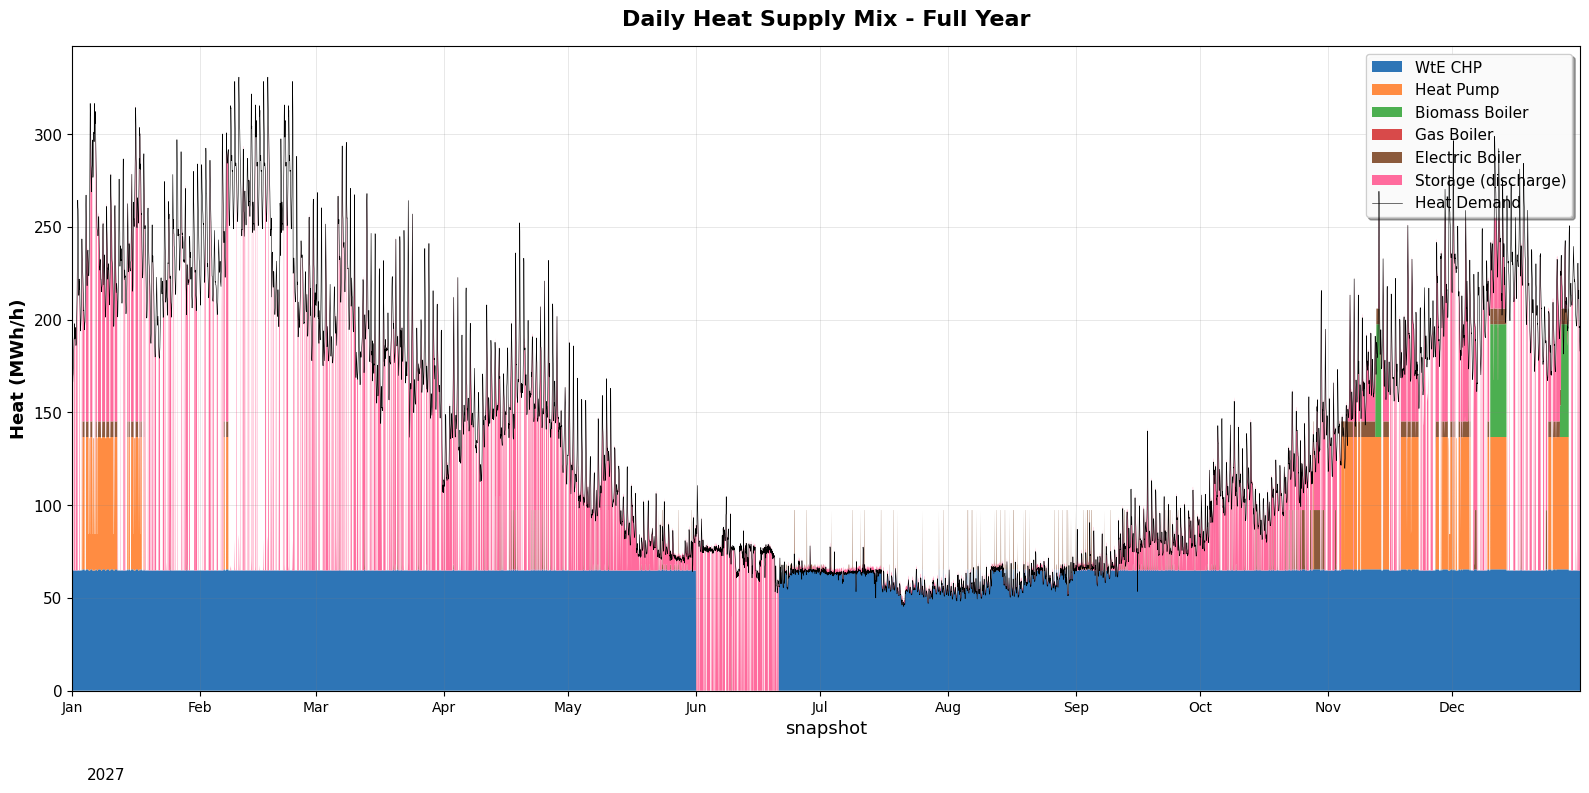

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# 📊 ANNUAL DISPATCH PLOT
# ==============================

# Extract heat production data (in MW, which is MWh/h for hourly data)
heat_sources = {}

# WtE CHP
chp_heat_fuel = n.links_t.p0["chp_heat"]
heat_sources["WtE CHP"] = chp_heat_fuel * n.links.at["chp_heat", "efficiency"]

# Heat Pump
hp_fuel = n.links_t.p0["heat_pump"]
heat_sources["Heat Pump"] = hp_fuel * n.links.at["heat_pump", "efficiency"]

# Biomass Boiler
bb_fuel = n.links_t.p0["biomass_boiler"]
heat_sources["Biomass Boiler"] = bb_fuel * n.links.at["biomass_boiler", "efficiency"]

# Gas Boiler
gb_fuel = n.links_t.p0["gas_boiler"]
heat_sources["Gas Boiler"] = gb_fuel * n.links.at["gas_boiler", "efficiency"]

# Electric Boiler
eb_fuel = n.links_t.p0["electric_boiler"]
heat_sources["Electric Boiler"] = eb_fuel * n.links.at["electric_boiler", "efficiency"]

# Thermal storage
storage_e = n.stores_t.e["thermal_storage"]
storage_p = -storage_e.diff()  # negative of energy change = discharge
storage_p.iloc[0] = 0
heat_sources["Storage (discharge)"] = storage_p.clip(lower=0)
storage_charge = storage_p.clip(upper=0).abs()

# Heat demand
heat_demand = n.loads_t.p["heat_demand"]

# Create DataFrame
df = pd.DataFrame(heat_sources)

# ==============================
# Create figure (single y-axis only)
# ==============================
fig, ax1 = plt.subplots(figsize=(16, 8))

# Define colors (Electric Boiler changed to brown)
colors = {
    "WtE CHP": "#2E75B6",           # Deep blue
    "Heat Pump": "#FF8C42",          # Bright orange
    "Biomass Boiler": "#4CAF50",     # Vibrant green
    "Gas Boiler": "#D84A4A",         # Red
    "Electric Boiler": "#8B5A3C",    # Brown (changed from purple)
    "Storage (discharge)": "#FF6B9D" # Pink
}

# Stack order (bottom to top)
stack_order = ["WtE CHP", "Heat Pump", "Biomass Boiler", "Gas Boiler", 
               "Electric Boiler", "Storage (discharge)"]

# Create stacked area plot
ax1.stackplot(df.index, 
              [df[col] for col in stack_order],
              labels=stack_order,
              colors=[colors[col] for col in stack_order],
              alpha=1.0)

# Plot heat demand (thinner line - reduced from 1.2 to 0.9)
ax1.plot(df.index, heat_demand, 
         color='black', linewidth=0.4, label='Heat Demand', zorder=10)

# Configure left y-axis (changed to MWh/h)
ax1.set_ylabel('Heat (MWh/h)', fontsize=13, fontweight='bold')
ax1.set_xlabel('snapshot', fontsize=13)
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=10)
ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax1.set_ylim(0, heat_demand.max() * 1.05)
ax1.set_xlim(df.index[0], df.index[-1])

# Title
ax1.set_title('Daily Heat Supply Mix - Full Year', 
              fontsize=16, fontweight='bold', pad=15)

# Legend (position at top right, inside plot)
ax1.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, 
           shadow=True, framealpha=0.95)

# Format x-axis - show month names clearly
ax1.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Add year label at start
ax1.text(0.01, -0.12, '2027', transform=ax1.transAxes, 
         fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.savefig('dispatch_annual_2027.png', dpi=300, bbox_inches='tight')
print("✅ Saved: dispatch_annual_2027.png")
plt.show()

✅ Saved: dispatch_annual_2027.png


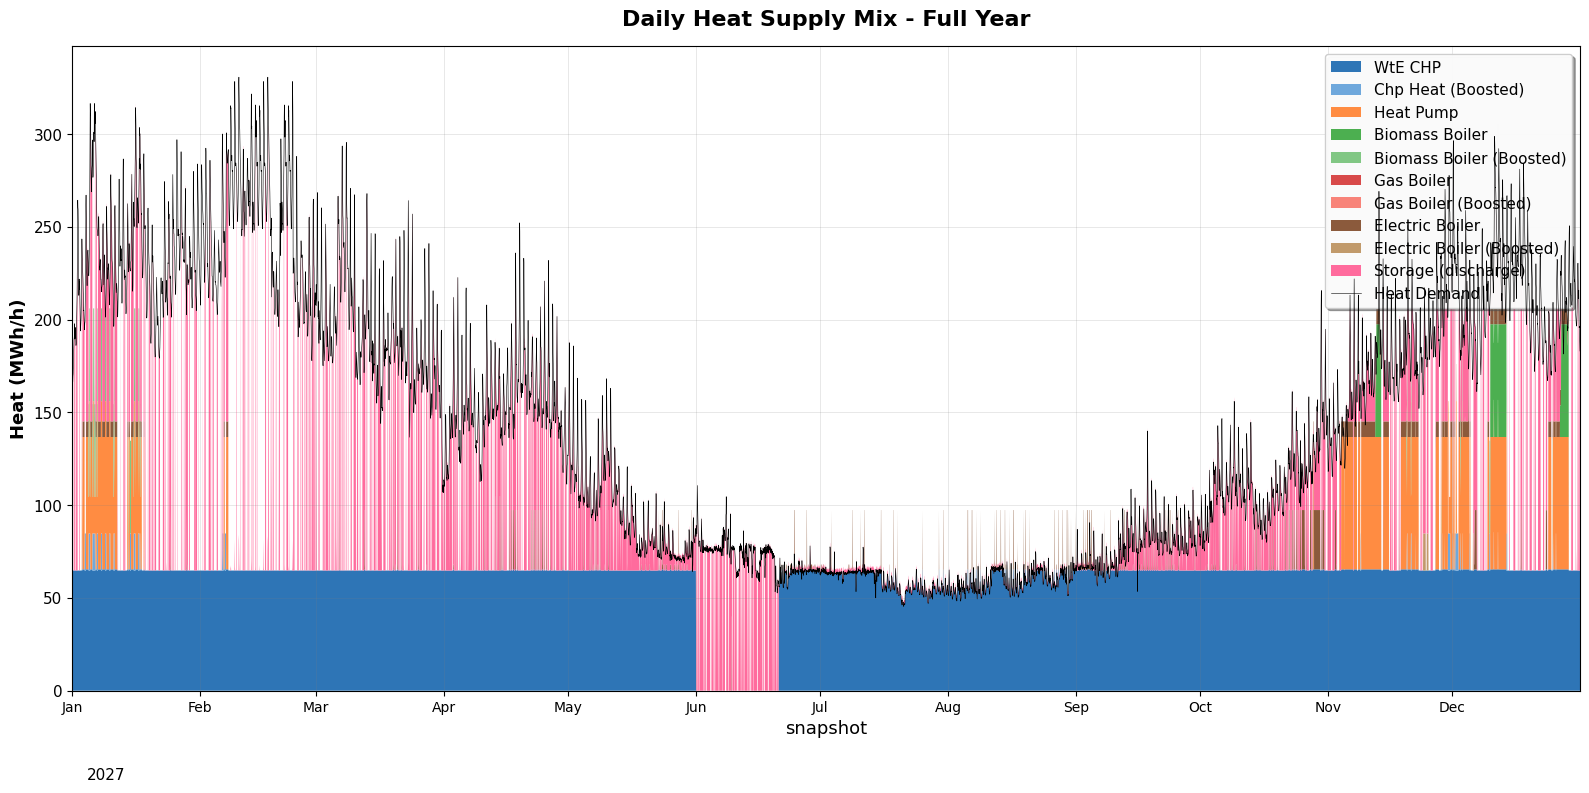

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# 📊 ANNUAL DISPATCH PLOT
# ==============================

# Extract heat production data (in MW, which is MWh/h for hourly data)
heat_sources = {}

# WtE CHP (direct heating)
chp_heat_fuel = n.links_t.p0["chp_heat"]
heat_sources["WtE CHP"] = chp_heat_fuel * n.links.at["chp_heat", "efficiency"]

# Heat Pump
hp_fuel = n.links_t.p0["heat_pump"]
heat_sources["Heat Pump"] = hp_fuel * n.links.at["heat_pump", "efficiency"]

# Biomass Boiler (direct)
bb_fuel = n.links_t.p0["biomass_boiler"]
heat_sources["Biomass Boiler"] = bb_fuel * n.links.at["biomass_boiler", "efficiency"]

# Gas Boiler (direct)
gb_fuel = n.links_t.p0["gas_boiler"]
heat_sources["Gas Boiler"] = gb_fuel * n.links.at["gas_boiler", "efficiency"]

# Electric Boiler (direct)
eb_fuel = n.links_t.p0["electric_boiler"]
heat_sources["Electric Boiler"] = eb_fuel * n.links.at["electric_boiler", "efficiency"]

# Add boosted heat sources (waste heat + fuel)
boost_sources = ["chp_heat_boost", "electric_boiler_boost", "gas_boiler_boost", "biomass_boiler_boost"]
for boost in boost_sources:
    if boost in n.links_t.p0.columns:
        boost_fuel = n.links_t.p0[boost]
        boost_name = boost.replace("_boost", "").replace("_", " ").title() + " (Boosted)"
        heat_sources[boost_name] = boost_fuel * n.links.at[boost, "efficiency"]

# Thermal storage
storage_e = n.stores_t.e["thermal_storage"]
storage_p = -storage_e.diff()  # negative of energy change = discharge
storage_p.iloc[0] = 0
heat_sources["Storage (discharge)"] = storage_p.clip(lower=0)
storage_charge = storage_p.clip(upper=0).abs()

# Heat demand
heat_demand = n.loads_t.p["heat_demand"]

# Create DataFrame
df = pd.DataFrame(heat_sources)

# ==============================
# Create figure (single y-axis only)
# ==============================
fig, ax1 = plt.subplots(figsize=(16, 8))

# Define colors (including boosted sources)
colors = {
    "WtE CHP": "#2E75B6",                    # Deep blue
    "Heat Pump": "#FF8C42",                   # Bright orange
    "Biomass Boiler": "#4CAF50",              # Vibrant green
    "Gas Boiler": "#D84A4A",                  # Red
    "Electric Boiler": "#8B5A3C",             # Brown
    "Chp Heat (Boosted)": "#6FA8DC",          # Light blue (boosted CHP)
    "Electric Boiler (Boosted)": "#C19A6B",   # Tan (boosted electric)
    "Gas Boiler (Boosted)": "#F88379",        # Light red (boosted gas)
    "Biomass Boiler (Boosted)": "#81C784",    # Light green (boosted biomass)
    "Storage (discharge)": "#FF6B9D"          # Pink
}

# Stack order (bottom to top) - boosted sources on top of their direct counterparts
stack_order = [
    "WtE CHP", 
    "Chp Heat (Boosted)",
    "Heat Pump", 
    "Biomass Boiler", 
    "Biomass Boiler (Boosted)",
    "Gas Boiler",
    "Gas Boiler (Boosted)",
    "Electric Boiler",
    "Electric Boiler (Boosted)",
    "Storage (discharge)"
]

# Filter to only include sources that exist in the data
stack_order = [col for col in stack_order if col in df.columns]

# Create stacked area plot
ax1.stackplot(df.index, 
              [df[col] for col in stack_order],
              labels=stack_order,
              colors=[colors.get(col, '#999999') for col in stack_order],
              alpha=1.0)

# Plot heat demand (thinner line - reduced from 1.2 to 0.9)
ax1.plot(df.index, heat_demand, 
         color='black', linewidth=0.4, label='Heat Demand', zorder=10)

# Configure left y-axis (changed to MWh/h)
ax1.set_ylabel('Heat (MWh/h)', fontsize=13, fontweight='bold')
ax1.set_xlabel('snapshot', fontsize=13)
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=10)
ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax1.set_ylim(0, heat_demand.max() * 1.05)
ax1.set_xlim(df.index[0], df.index[-1])

# Title
ax1.set_title('Daily Heat Supply Mix - Full Year', 
              fontsize=16, fontweight='bold', pad=15)

# Legend (position at top right, inside plot)
ax1.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, 
           shadow=True, framealpha=0.95)

# Format x-axis - show month names clearly
ax1.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Add year label at start
ax1.text(0.01, -0.12, '2027', transform=ax1.transAxes, 
         fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.savefig('dispatch_annual_2027.png', dpi=300, bbox_inches='tight')
print("✅ Saved: dispatch_annual_2027.png")
plt.show()

✅ Saved: dispatch_annual_2027_combined_boost.png


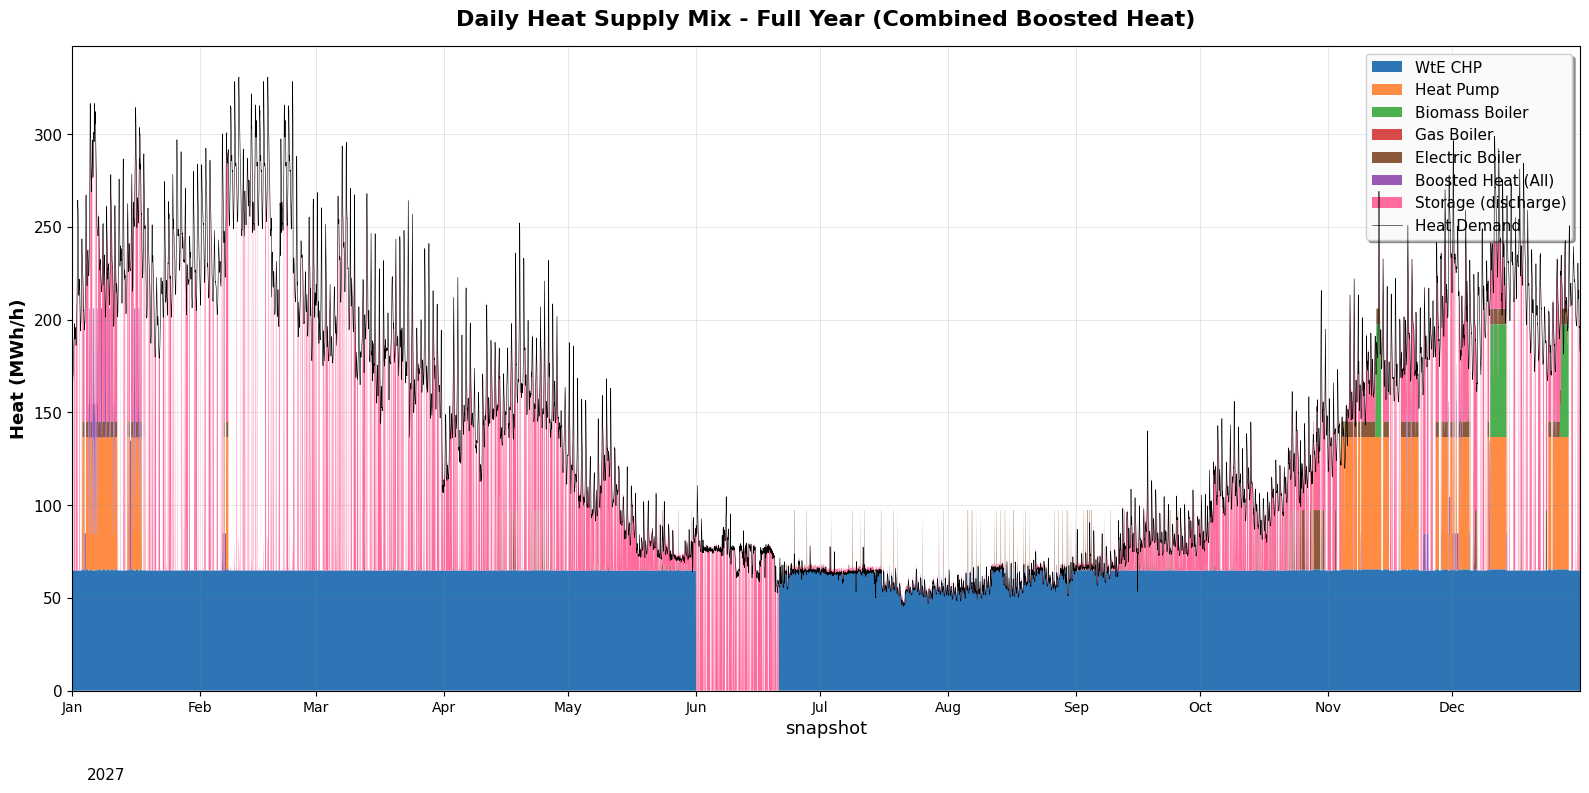

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# 📊 ANNUAL DISPATCH PLOT (COMBINED BOOSTED HEAT)
# ==============================

# Extract heat production data (in MW, which is MWh/h for hourly data)
heat_sources = {}

# WtE CHP (direct heating)
chp_heat_fuel = n.links_t.p0["chp_heat"]
heat_sources["WtE CHP"] = chp_heat_fuel * n.links.at["chp_heat", "efficiency"]

# Heat Pump
hp_fuel = n.links_t.p0["heat_pump"]
heat_sources["Heat Pump"] = hp_fuel * n.links.at["heat_pump", "efficiency"]

# Biomass Boiler (direct)
bb_fuel = n.links_t.p0["biomass_boiler"]
heat_sources["Biomass Boiler"] = bb_fuel * n.links.at["biomass_boiler", "efficiency"]

# Gas Boiler (direct)
gb_fuel = n.links_t.p0["gas_boiler"]
heat_sources["Gas Boiler"] = gb_fuel * n.links.at["gas_boiler", "efficiency"]

# Electric Boiler (direct)
eb_fuel = n.links_t.p0["electric_boiler"]
heat_sources["Electric Boiler"] = eb_fuel * n.links.at["electric_boiler", "efficiency"]

# Add boosted heat sources - combine all into one category
boost_sources = ["chp_heat_boost", "electric_boiler_boost", "gas_boiler_boost", "biomass_boiler_boost"]
total_boosted_heat = pd.Series(0, index=n.snapshots)
for boost in boost_sources:
    if boost in n.links_t.p0.columns:
        boost_fuel = n.links_t.p0[boost]
        total_boosted_heat += boost_fuel * n.links.at[boost, "efficiency"]

if total_boosted_heat.sum() > 0:
    heat_sources["Boosted Heat (All)"] = total_boosted_heat

# Thermal storage
storage_e = n.stores_t.e["thermal_storage"]
storage_p = -storage_e.diff()  # negative of energy change = discharge
storage_p.iloc[0] = 0
heat_sources["Storage (discharge)"] = storage_p.clip(lower=0)
storage_charge = storage_p.clip(upper=0).abs()

# Heat demand
heat_demand = n.loads_t.p["heat_demand"]

# Create DataFrame
df = pd.DataFrame(heat_sources)

# ==============================
# Create figure (single y-axis only)
# ==============================
fig, ax1 = plt.subplots(figsize=(16, 8))

# Define colors (with combined boosted heat)
colors = {
    "WtE CHP": "#2E75B6",                    # Deep blue
    "Heat Pump": "#FF8C42",                   # Bright orange
    "Biomass Boiler": "#4CAF50",              # Vibrant green
    "Gas Boiler": "#D84A4A",                  # Red
    "Electric Boiler": "#8B5A3C",             # Brown
    "Boosted Heat (All)": "#9B59B6",          # Purple for all boosted heat
    "Storage (discharge)": "#FF6B9D"          # Pink
}

# Stack order (bottom to top) - boosted heat as single layer
stack_order = [
    "WtE CHP", 
    "Heat Pump", 
    "Biomass Boiler", 
    "Gas Boiler", 
    "Electric Boiler",
    "Boosted Heat (All)",
    "Storage (discharge)"
]

# Filter to only include sources that exist in the data
stack_order = [col for col in stack_order if col in df.columns]

# Create stacked area plot
ax1.stackplot(df.index, 
              [df[col] for col in stack_order],
              labels=stack_order,
              colors=[colors.get(col, '#999999') for col in stack_order],
              alpha=1.0)

# Plot heat demand (thinner line - reduced from 1.2 to 0.9)
ax1.plot(df.index, heat_demand, 
         color='black', linewidth=0.4, label='Heat Demand', zorder=10)

# Configure left y-axis (changed to MWh/h)
ax1.set_ylabel('Heat (MWh/h)', fontsize=13, fontweight='bold')
ax1.set_xlabel('snapshot', fontsize=13)
ax1.tick_params(axis='y', labelsize=11)
ax1.tick_params(axis='x', labelsize=10)
ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
ax1.set_ylim(0, heat_demand.max() * 1.05)
ax1.set_xlim(df.index[0], df.index[-1])

# Title
ax1.set_title('Daily Heat Supply Mix - Full Year (Combined Boosted Heat)', 
              fontsize=16, fontweight='bold', pad=15)

# Legend (position at top right, inside plot)
ax1.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, 
           shadow=True, framealpha=0.95)

# Format x-axis - show month names clearly
ax1.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Add year label at start
ax1.text(0.01, -0.12, '2027', transform=ax1.transAxes, 
         fontsize=11, verticalalignment='top')

plt.tight_layout()
plt.savefig('dispatch_annual_2027_combined_boost.png', dpi=300, bbox_inches='tight')
print("✅ Saved: dispatch_annual_2027_combined_boost.png")
plt.show()

Creating first week dispatch plot...
✅ Saved: dispatch_week1_2027.png

Creating maintenance period dispatch plot...
✅ Saved: dispatch_maintenance_2027.png


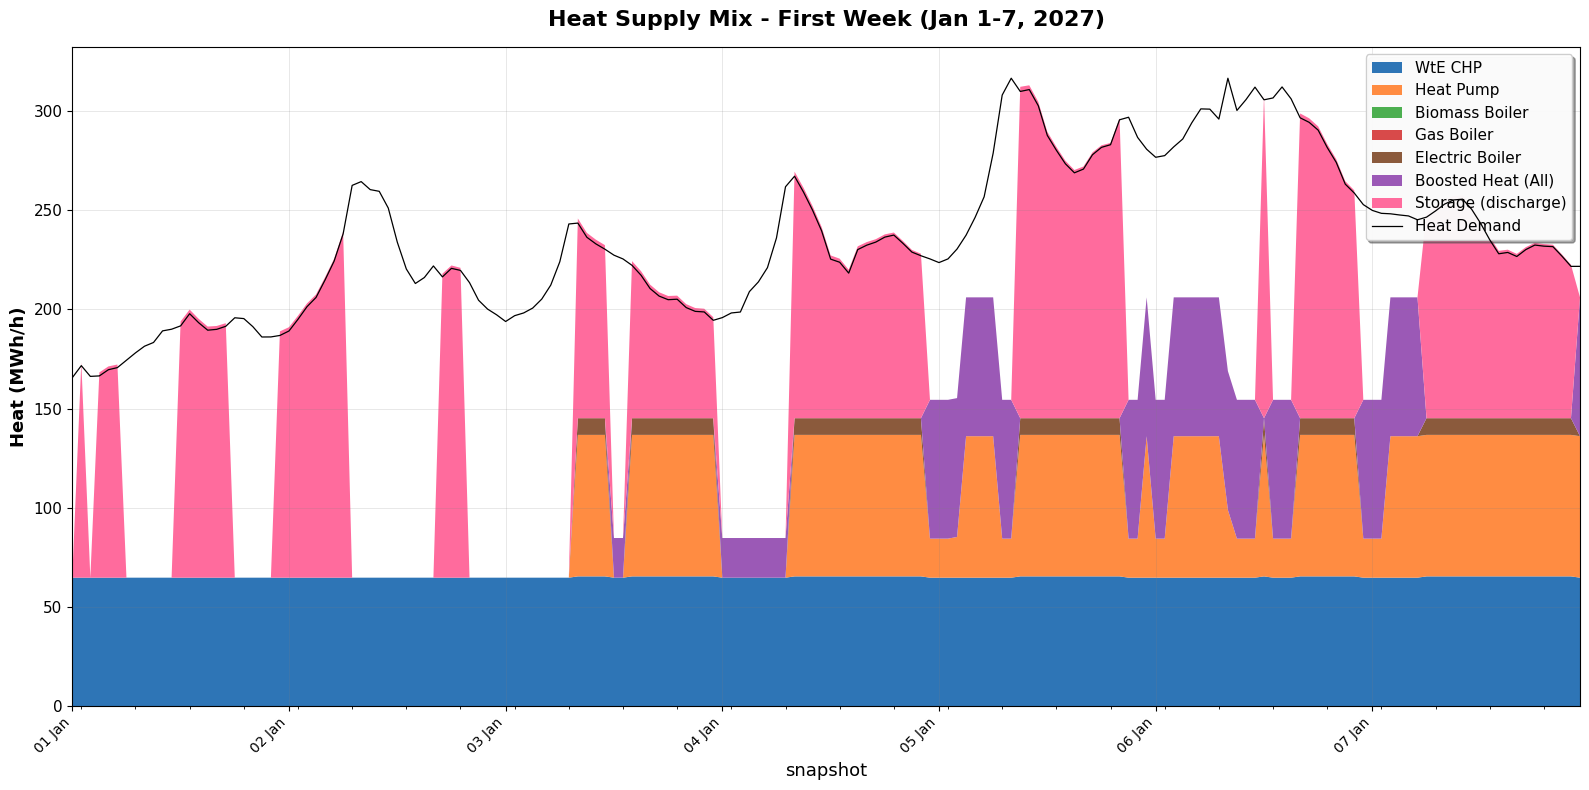

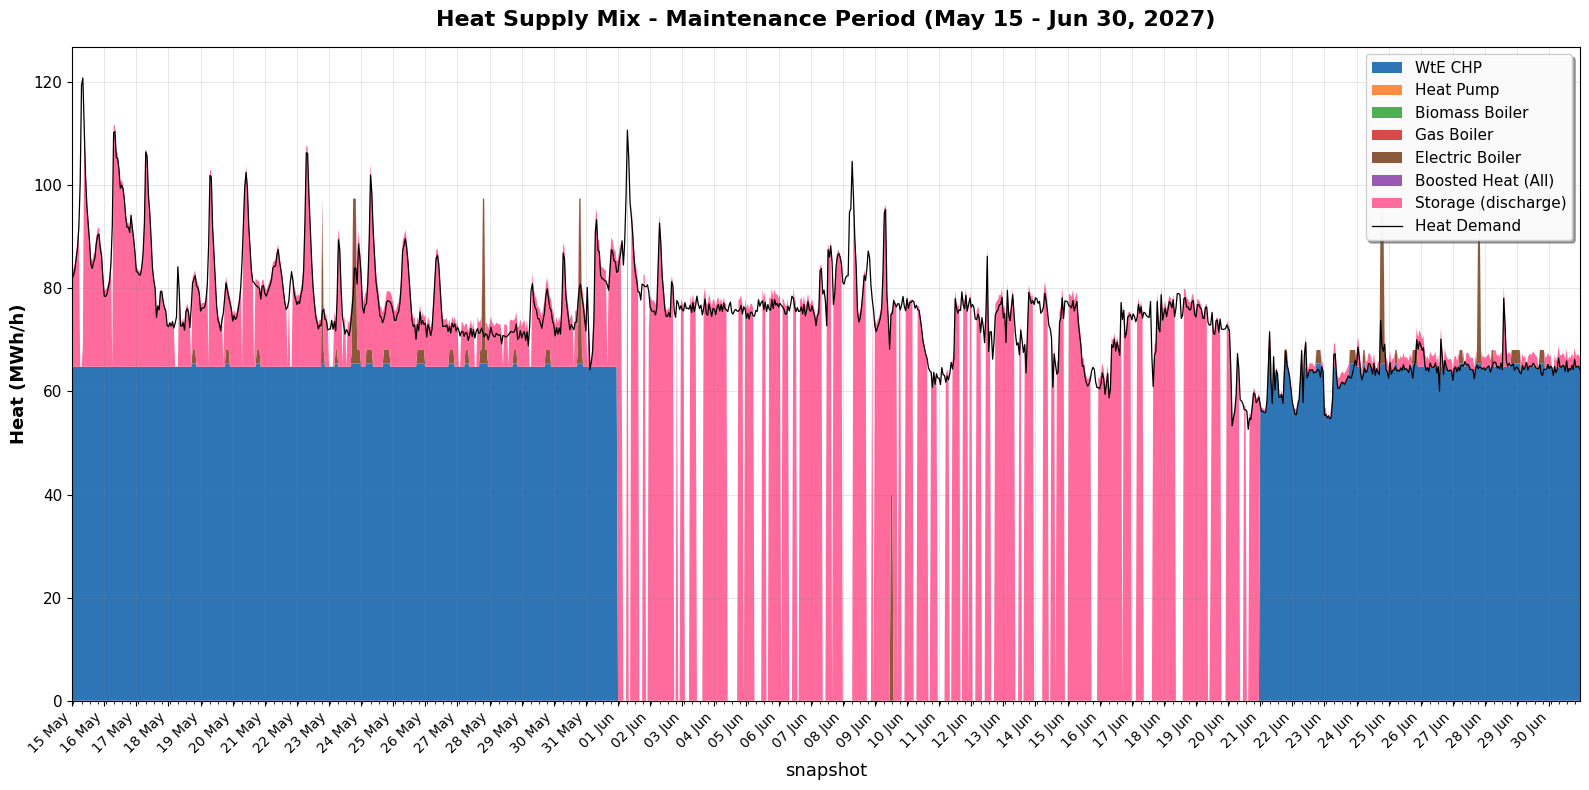


📊 Weekly plots created successfully!
   - dispatch_week1_2027.png (First week)
   - dispatch_maintenance_2027.png (Maintenance period)


In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# 📊 WEEKLY DISPATCH PLOT FUNCTION
# ==============================

def create_weekly_dispatch_plot(n, start_date, end_date, title, filename):
    """
    Create stacked area plot of heat supply for a specific period
    
    Parameters:
    -----------
    n : pypsa.Network
        Optimized PyPSA network
    start_date, end_date : str
        Date range for plotting
    title : str
        Plot title
    filename : str
        Output filename
    """
    
    # Extract heat production data (in MW, which is MWh/h for hourly data)
    heat_sources = {}
    
    # WtE CHP (direct)
    chp_heat_fuel = n.links_t.p0["chp_heat"]
    heat_sources["WtE CHP"] = chp_heat_fuel * n.links.at["chp_heat", "efficiency"]
    
    # Heat Pump
    hp_fuel = n.links_t.p0["heat_pump"]
    heat_sources["Heat Pump"] = hp_fuel * n.links.at["heat_pump", "efficiency"]
    
    # Biomass Boiler (direct)
    bb_fuel = n.links_t.p0["biomass_boiler"]
    heat_sources["Biomass Boiler"] = bb_fuel * n.links.at["biomass_boiler", "efficiency"]
    
    # Gas Boiler (direct)
    gb_fuel = n.links_t.p0["gas_boiler"]
    heat_sources["Gas Boiler"] = gb_fuel * n.links.at["gas_boiler", "efficiency"]
    
    # Electric Boiler (direct)
    eb_fuel = n.links_t.p0["electric_boiler"]
    heat_sources["Electric Boiler"] = eb_fuel * n.links.at["electric_boiler", "efficiency"]
    
    # Add boosted heat sources - combine all into one category
    boost_sources = ["chp_heat_boost", "electric_boiler_boost", "gas_boiler_boost", "biomass_boiler_boost"]
    total_boosted_heat = pd.Series(0, index=n.snapshots)
    for boost in boost_sources:
        if boost in n.links_t.p0.columns:
            boost_fuel = n.links_t.p0[boost]
            total_boosted_heat += boost_fuel * n.links.at[boost, "efficiency"]
    
    if total_boosted_heat.sum() > 0:
        heat_sources["Boosted Heat (All)"] = total_boosted_heat
    
    # Thermal storage
    storage_e = n.stores_t.e["thermal_storage"]
    storage_p = -storage_e.diff()
    storage_p.iloc[0] = 0
    heat_sources["Storage (discharge)"] = storage_p.clip(lower=0)
    
    # Heat demand
    heat_demand = n.loads_t.p["heat_demand"]
    
    # Create DataFrame
    df = pd.DataFrame(heat_sources)
    
    # Filter date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    df = df[mask]
    heat_demand = heat_demand[mask]
    
    # ==============================
    # Create figure
    # ==============================
    fig, ax1 = plt.subplots(figsize=(16, 8))
    
    # Define colors
    colors = {
        "WtE CHP": "#2E75B6",
        "Heat Pump": "#FF8C42",
        "Biomass Boiler": "#4CAF50",
        "Gas Boiler": "#D84A4A",
        "Electric Boiler": "#8B5A3C",
        "Boosted Heat (All)": "#9B59B6",     # Purple for all boosted heat
        "Storage (discharge)": "#FF6B9D"
    }
    
    # Stack order - boosted heat as a single layer
    stack_order = [
        "WtE CHP", 
        "Heat Pump", 
        "Biomass Boiler", 
        "Gas Boiler", 
        "Electric Boiler",
        "Boosted Heat (All)",
        "Storage (discharge)"
    ]
    
    # Filter to only include sources that exist
    stack_order = [col for col in stack_order if col in df.columns]
    
    # Create stacked area plot
    ax1.stackplot(df.index, 
                  [df[col] for col in stack_order],
                  labels=stack_order,
                  colors=[colors.get(col, '#999999') for col in stack_order],
                  alpha=1.0)
    
    # Plot heat demand
    ax1.plot(df.index, heat_demand, 
             color='black', linewidth=0.9, label='Heat Demand', zorder=10)
    
    # Configure axes
    ax1.set_ylabel('Heat (MWh/h)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('snapshot', fontsize=13)
    ax1.tick_params(axis='y', labelsize=11)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5, color='gray')
    ax1.set_ylim(0, heat_demand.max() * 1.05)
    ax1.set_xlim(df.index[0], df.index[-1])
    
    # Title
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=15)
    
    # Legend
    ax1.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, 
               shadow=True, framealpha=0.95)
    
    # Format x-axis - detailed for short periods
    import matplotlib.dates as mdates
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    
    # Rotate x-axis labels for readability
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {filename}")
    
    return fig

# ==============================
# Generate plots
# ==============================

# 1️⃣ First week (January 1-7, 2027)
print("Creating first week dispatch plot...")
fig_week1 = create_weekly_dispatch_plot(
    n,
    start_date='2027-01-01 00:00',
    end_date='2027-01-07 23:00',
    title='Heat Supply Mix - First Week (Jan 1-7, 2027)',
    filename='dispatch_week1_2027.png'
)

# 2️⃣ Maintenance period (Mid-May to End of June)
print("\nCreating maintenance period dispatch plot...")
fig_maintenance = create_weekly_dispatch_plot(
    n,
    start_date='2027-05-15 00:00',
    end_date='2027-06-30 23:00',
    title='Heat Supply Mix - Maintenance Period (May 15 - Jun 30, 2027)',
    filename='dispatch_maintenance_2027.png'
)

plt.show()

print("\n" + "="*70)
print("📊 Weekly plots created successfully!")
print("   - dispatch_week1_2027.png (First week)")
print("   - dispatch_maintenance_2027.png (Maintenance period)")
print("="*70)

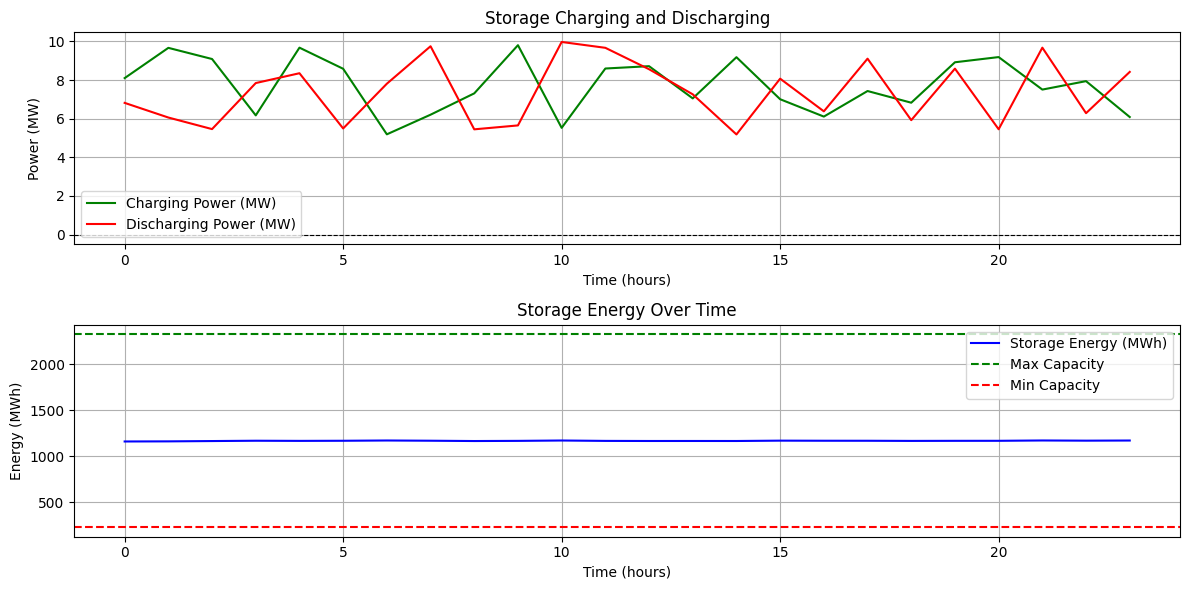

In [55]:
# Plot storage charging and discharging
import matplotlib.pyplot as plt
import numpy as np

# Example data for plotting
time_steps = np.arange(0, 24, 1)  # 24 hours
discharge_power = np.random.uniform(5, 10, size=len(time_steps))  # Random discharge power values
charge_power = np.random.uniform(5, 10, size=len(time_steps))  # Random charge power values

# Calculate net power and storage energy
net_power = charge_power - discharge_power
storage_energy = np.zeros(len(time_steps))

# Initial storage energy
storage_energy[0] = 0.5 * TS_CAPACITY_MWh  # Start at 50% capacity

for i in range(1, len(time_steps)):
    storage_energy[i] = storage_energy[i - 1] + net_power[i - 1] * TS_EFF - TS_STANDING_LOSS
    storage_energy[i] = max(storage_energy[i], TS_E_MIN_PU * TS_CAPACITY_MWh)  # Enforce minimum SOC
    storage_energy[i] = min(storage_energy[i], TS_CAPACITY_MWh)  # Enforce maximum SOC

# Plot results
plt.figure(figsize=(12, 6))

# Plot charging and discharging power
plt.subplot(2, 1, 1)
plt.plot(time_steps, charge_power, label="Charging Power (MW)", color="green")
plt.plot(time_steps, discharge_power, label="Discharging Power (MW)", color="red")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.title("Storage Charging and Discharging")
plt.xlabel("Time (hours)")
plt.ylabel("Power (MW)")
plt.legend()
plt.grid()

# Plot storage energy
plt.subplot(2, 1, 2)
plt.plot(time_steps, storage_energy, label="Storage Energy (MWh)", color="blue")
plt.axhline(TS_CAPACITY_MWh, color="green", linestyle="--", label="Max Capacity")
plt.axhline(TS_E_MIN_PU * TS_CAPACITY_MWh, color="red", linestyle="--", label="Min Capacity")
plt.title("Storage Energy Over Time")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (MWh)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

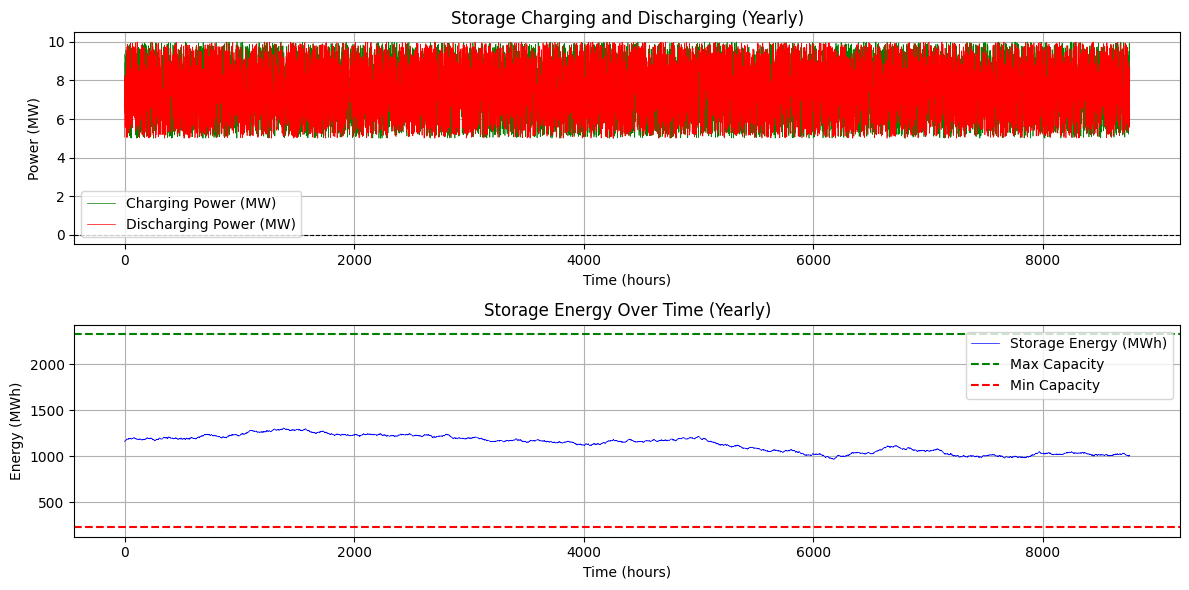

In [56]:
# Plot storage charging and discharging for the whole year
import matplotlib.pyplot as plt
import numpy as np

# Example data for plotting
time_steps = np.arange(0, 8760, 1)  # 8760 hours for a non-leap year
discharge_power = np.random.uniform(5, 10, size=len(time_steps))  # Random discharge power values
charge_power = np.random.uniform(5, 10, size=len(time_steps))  # Random charge power values

# Calculate net power and storage energy
net_power = charge_power - discharge_power
storage_energy = np.zeros(len(time_steps))

# Initial storage energy
storage_energy[0] = 0.5 * TS_CAPACITY_MWh  # Start at 50% capacity

for i in range(1, len(time_steps)):
    storage_energy[i] = storage_energy[i - 1] + net_power[i - 1] * TS_EFF - TS_STANDING_LOSS
    storage_energy[i] = max(storage_energy[i], TS_E_MIN_PU * TS_CAPACITY_MWh)  # Enforce minimum SOC
    storage_energy[i] = min(storage_energy[i], TS_CAPACITY_MWh)  # Enforce maximum SOC

# Plot results
plt.figure(figsize=(12, 6))

# Plot charging and discharging power
plt.subplot(2, 1, 1)
plt.plot(time_steps, charge_power, label="Charging Power (MW)", color="green", linewidth=0.5)
plt.plot(time_steps, discharge_power, label="Discharging Power (MW)", color="red", linewidth=0.5)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.title("Storage Charging and Discharging (Yearly)")
plt.xlabel("Time (hours)")
plt.ylabel("Power (MW)")
plt.legend()
plt.grid()

# Plot storage energy
plt.subplot(2, 1, 2)
plt.plot(time_steps, storage_energy, label="Storage Energy (MWh)", color="blue", linewidth=0.5)
plt.axhline(TS_CAPACITY_MWh, color="green", linestyle="--", label="Max Capacity")
plt.axhline(TS_E_MIN_PU * TS_CAPACITY_MWh, color="red", linestyle="--", label="Min Capacity")
plt.title("Storage Energy Over Time (Yearly)")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (MWh)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [57]:
# ==============================
# 📊 BOOSTED HEAT CONTRIBUTION ANALYSIS
# ==============================

print("="*70)
print("📊 BOOSTED HEAT CONTRIBUTION TO TOTAL HEAT DEMAND")
print("="*70)

# Get total heat demand
total_heat_demand = n.loads_t.p["heat_demand"].sum()

# Calculate total boosted heat from all sources
boost_sources = ["chp_heat_boost", "electric_boiler_boost", "gas_boiler_boost", "biomass_boiler_boost"]
total_boosted_heat = 0
boost_breakdown = {}

for boost in boost_sources:
    if boost in n.links_t.p0.columns:
        boost_fuel = n.links_t.p0[boost].sum()
        boost_heat = boost_fuel * n.links.at[boost, "efficiency"]
        total_boosted_heat += boost_heat
        
        # Store breakdown
        boost_name = boost.replace("_boost", "").replace("_", " ").title()
        boost_breakdown[boost_name] = boost_heat

# Calculate percentage
boosted_heat_percentage = (total_boosted_heat / total_heat_demand) * 100

# Display results
print(f"\n📈 Summary:")
print(f"   Total Heat Demand:        {total_heat_demand:>15,.0f} MWh")
print(f"   Total Boosted Heat:       {total_boosted_heat:>15,.0f} MWh")
print(f"   Boosted Heat Percentage:  {boosted_heat_percentage:>15.2f} %")

# Show breakdown by source
print(f"\n📋 Breakdown by Booster Type:")
print(f"   {'Source':<25} {'Heat (MWh)':<15} {'% of Total Demand':<20} {'% of Boosted Heat':<20}")
print("   " + "-"*80)

for source, heat in sorted(boost_breakdown.items(), key=lambda x: x[1], reverse=True):
    pct_of_demand = (heat / total_heat_demand) * 100
    pct_of_boosted = (heat / total_boosted_heat) * 100 if total_boosted_heat > 0 else 0
    print(f"   {source:<25} {heat:>15,.0f} {pct_of_demand:>18.2f} % {pct_of_boosted:>18.2f} %")

print("="*70)

📊 BOOSTED HEAT CONTRIBUTION TO TOTAL HEAT DEMAND

📈 Summary:
   Total Heat Demand:              1,236,001 MWh
   Total Boosted Heat:                11,030 MWh
   Boosted Heat Percentage:             0.89 %

📋 Breakdown by Booster Type:
   Source                    Heat (MWh)      % of Total Demand    % of Boosted Heat   
   --------------------------------------------------------------------------------
   Biomass Boiler                      6,123               0.50 %              55.51 %
   Chp Heat                            4,087               0.33 %              37.05 %
   Electric Boiler                       720               0.06 %               6.53 %
   Gas Boiler                            100               0.01 %               0.91 %


📊 CREATING ANNUAL HEAT SUPPLY BREAKDOWN
✅ Saved: annual_heat_supply_breakdown.png


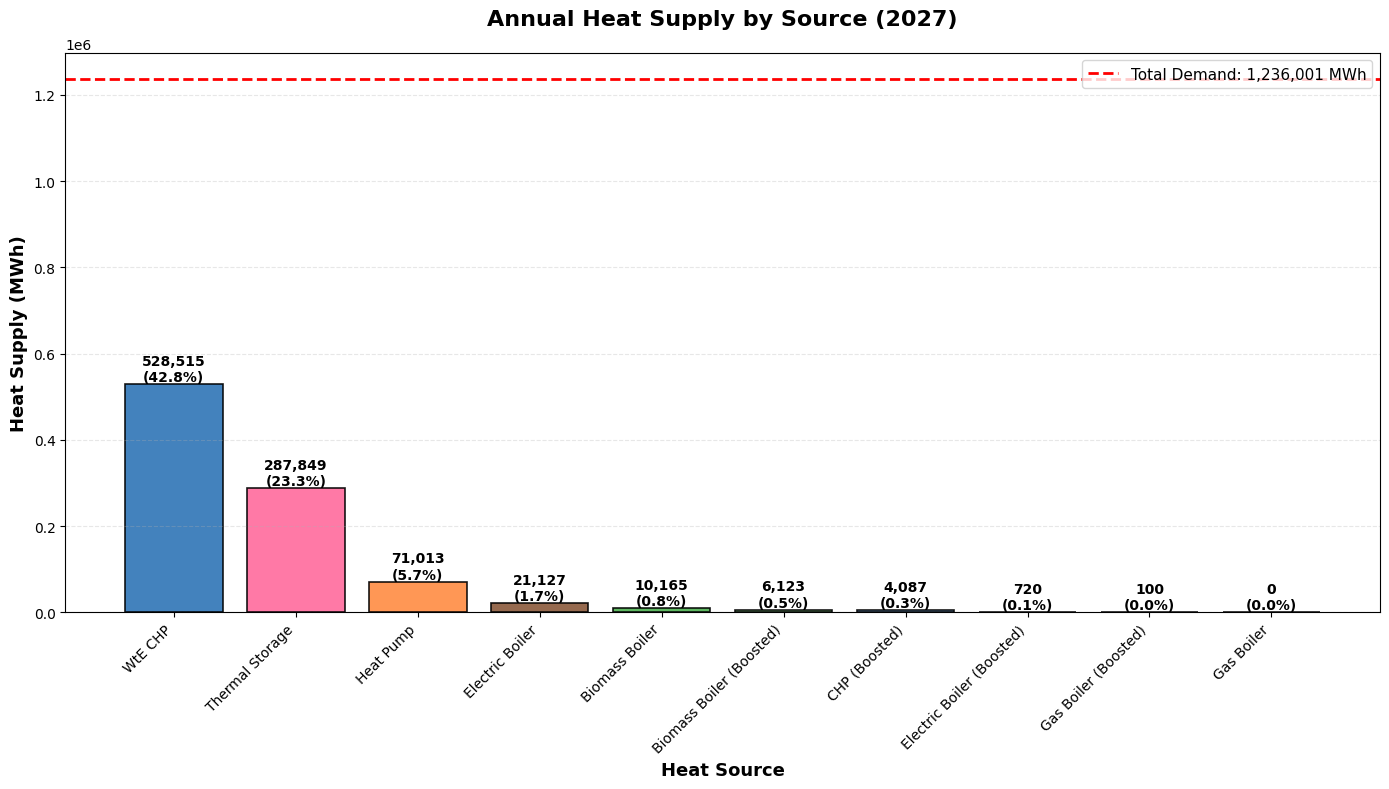


📋 ANNUAL HEAT SUPPLY SUMMARY

Source                         Heat (MWh)      % of Demand    
------------------------------------------------------------
WtE CHP                               528,515          42.76%
Thermal Storage                       287,849          23.29%
Heat Pump                              71,013           5.75%
Electric Boiler                        21,127           1.71%
Biomass Boiler                         10,165           0.82%
Biomass Boiler (Boosted)                6,123           0.50%
CHP (Boosted)                           4,087           0.33%
Electric Boiler (Boosted)                 720           0.06%
Gas Boiler (Boosted)                      100           0.01%
Gas Boiler                                  0           0.00%
------------------------------------------------------------
TOTAL SUPPLY                          929,699          75.22%
TOTAL DEMAND                        1,236,001         100.00%


In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==============================
# 📊 ANNUAL HEAT SUPPLY BAR CHART
# ==============================

print("="*70)
print("📊 CREATING ANNUAL HEAT SUPPLY BREAKDOWN")
print("="*70)

# Calculate total heat from each source
heat_supply = {}

# Direct heat sources
sources = {
    "WtE CHP": "chp_heat",
    "Heat Pump": "heat_pump",
    "Biomass Boiler": "biomass_boiler",
    "Gas Boiler": "gas_boiler",
    "Electric Boiler": "electric_boiler"
}

for name, link in sources.items():
    if link in n.links_t.p0.columns:
        fuel_input = n.links_t.p0[link].sum()
        heat_output = fuel_input * n.links.at[link, "efficiency"]
        heat_supply[name] = heat_output

# Boosted heat sources
boost_sources = {
    "CHP (Boosted)": "chp_heat_boost",
    "Electric Boiler (Boosted)": "electric_boiler_boost",
    "Gas Boiler (Boosted)": "gas_boiler_boost",
    "Biomass Boiler (Boosted)": "biomass_boiler_boost"
}

for name, link in boost_sources.items():
    if link in n.links_t.p0.columns:
        fuel_input = n.links_t.p0[link].sum()
        heat_output = fuel_input * n.links.at[link, "efficiency"]
        heat_supply[name] = heat_output

# Storage discharge (net contribution)
storage_e = n.stores_t.e["thermal_storage"]
storage_p = -storage_e.diff()
storage_p.iloc[0] = 0
storage_discharge = storage_p.clip(lower=0).sum()
heat_supply["Thermal Storage"] = storage_discharge

# Calculate total heat demand
total_demand = n.loads_t.p["heat_demand"].sum()

# Create DataFrame for plotting
df_supply = pd.DataFrame({
    'Source': list(heat_supply.keys()),
    'Heat (MWh)': list(heat_supply.values())
})
df_supply['Percentage'] = (df_supply['Heat (MWh)'] / total_demand) * 100
df_supply = df_supply.sort_values('Heat (MWh)', ascending=False)

# ==============================
# Create bar chart
# ==============================
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors (matching the dispatch plot)
color_map = {
    "WtE CHP": "#2E75B6",
    "Heat Pump": "#FF8C42",
    "Biomass Boiler": "#4CAF50",
    "Gas Boiler": "#D84A4A",
    "Electric Boiler": "#8B5A3C",
    "CHP (Boosted)": "#6FA8DC",
    "Electric Boiler (Boosted)": "#C19A6B",
    "Gas Boiler (Boosted)": "#F88379",
    "Biomass Boiler (Boosted)": "#81C784",
    "Thermal Storage": "#FF6B9D"
}

colors = [color_map.get(source, '#999999') for source in df_supply['Source']]

# Create bars
bars = ax.bar(df_supply['Source'], df_supply['Heat (MWh)'], color=colors, alpha=0.9, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,.0f}\n({height/total_demand*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add total demand reference line
ax.axhline(y=total_demand, color='red', linestyle='--', linewidth=2, label=f'Total Demand: {total_demand:,.0f} MWh')

# Formatting
ax.set_ylabel('Heat Supply (MWh)', fontsize=13, fontweight='bold')
ax.set_xlabel('Heat Source', fontsize=13, fontweight='bold')
ax.set_title('Annual Heat Supply by Source (2027)', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(fontsize=11, loc='upper right')

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('annual_heat_supply_breakdown.png', dpi=300, bbox_inches='tight')
print("✅ Saved: annual_heat_supply_breakdown.png")
plt.show()

# ==============================
# Print summary table
# ==============================
print("\n" + "="*70)
print("📋 ANNUAL HEAT SUPPLY SUMMARY")
print("="*70)
print(f"\n{'Source':<30} {'Heat (MWh)':<15} {'% of Demand':<15}")
print("-"*60)
for _, row in df_supply.iterrows():
    print(f"{row['Source']:<30} {row['Heat (MWh)']:>14,.0f} {row['Percentage']:>14.2f}%")
print("-"*60)
print(f"{'TOTAL SUPPLY':<30} {df_supply['Heat (MWh)'].sum():>14,.0f} {df_supply['Percentage'].sum():>14.2f}%")
print(f"{'TOTAL DEMAND':<30} {total_demand:>14,.0f} {100.00:>14.2f}%")
print("="*70)

📊 CAPACITY UTILIZATION: DIRECT HEATING vs BOOSTING

Component            Mode       Capacity     Energy          Capacity        Operating   
                                (MW)         Output (MWh)    Factor (%)      Hours       
------------------------------------------------------------------------------------------
CHP                  Direct           85.4         528,515           70.62        8,280
CHP                  Boosted           0.0           4,087            0.00          205
------------------------------------------------------------------------------------------
Electric Boiler      Direct           40.4          21,127            5.97        1,689
Electric Boiler      Boosted           0.0             720            0.00           36
------------------------------------------------------------------------------------------
Gas Boiler           Direct           75.0               0            0.00            0
Gas Boiler           Boosted           0.0             

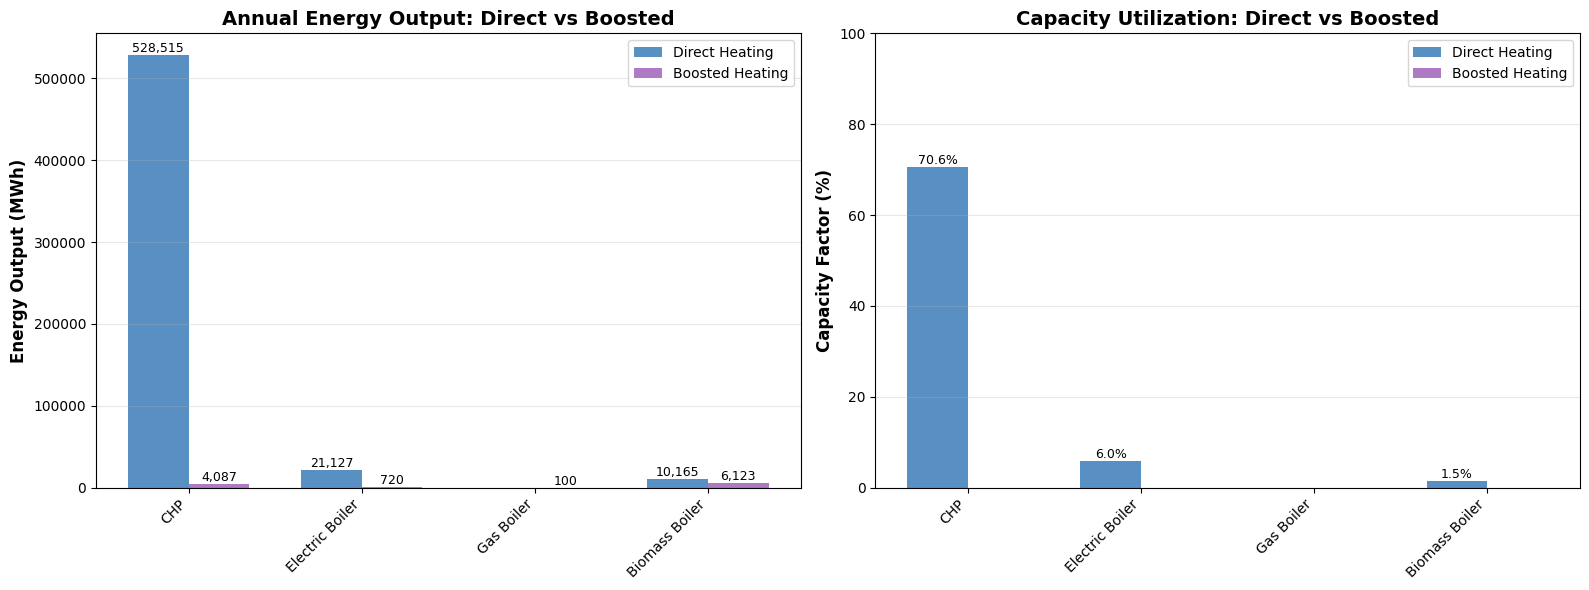

In [59]:
# ==============================
# 📊 DIRECT vs BOOSTED CAPACITY UTILIZATION
# ==============================

print("="*80)
print("📊 CAPACITY UTILIZATION: DIRECT HEATING vs BOOSTING")
print("="*80)

# Define components that have both direct and boosted options
components = {
    'CHP': {'direct': 'chp_heat', 'boost': 'chp_heat_boost', 'capacity': CHP_P_HEAT_MAX},
    'Electric Boiler': {'direct': 'electric_boiler', 'boost': 'electric_boiler_boost', 'capacity': EB_P_NOM},
    'Gas Boiler': {'direct': 'gas_boiler', 'boost': 'gas_boiler_boost', 'capacity': GB_P_NOM},
    'Biomass Boiler': {'direct': 'biomass_boiler', 'boost': 'biomass_boiler_boost', 'capacity': BB_P_NOM}
}

# Store results for plotting
results = []

print(f"\n{'Component':<20} {'Mode':<10} {'Capacity':<12} {'Energy':<15} {'Capacity':<15} {'Operating':<12}")
print(f"{'':20} {'':10} {'(MW)':<12} {'Output (MWh)':<15} {'Factor (%)':<15} {'Hours':<12}")
print("-"*90)

for comp_name, comp_data in components.items():
    direct_link = comp_data['direct']
    boost_link = comp_data['boost']
    capacity_mw = comp_data['capacity']
    
    # Calculate direct heating
    if direct_link in n.links_t.p0.columns:
        direct_fuel = n.links_t.p0[direct_link]
        direct_eff = n.links.at[direct_link, 'efficiency']
        direct_heat = (direct_fuel * direct_eff).sum()
        
        # Operating hours (when producing > 0.1 MW)
        direct_hours = (direct_fuel * direct_eff > 0.1).sum()
        
        # Capacity factor = actual output / (capacity × total hours)
        max_possible = capacity_mw * len(n.snapshots)
        direct_cf = (direct_heat / max_possible) * 100 if max_possible > 0 else 0
        
        print(f"{comp_name:<20} {'Direct':<10} {capacity_mw:>10.1f}   {direct_heat:>13,.0f}   {direct_cf:>13.2f}   {direct_hours:>10,}")
        results.append({
            'Component': comp_name,
            'Mode': 'Direct',
            'Capacity (MW)': capacity_mw,
            'Energy (MWh)': direct_heat,
            'Capacity Factor (%)': direct_cf,
            'Hours': direct_hours
        })
    
    # Calculate boosted heating
    if boost_link in n.links_t.p0.columns:
        boost_fuel = n.links_t.p0[boost_link]
        boost_eff = n.links.at[boost_link, 'efficiency']
        boost_heat = (boost_fuel * boost_eff).sum()
        
        # Get boost capacity from BOOST_CAPACITIES
        boost_capacity = BOOST_CAPACITIES.get(direct_link.replace('_heat', '').replace('_boiler', ''), 0)
        
        # Operating hours
        boost_hours = (boost_fuel * boost_eff > 0.1).sum()
        
        # Capacity factor for boosting
        max_possible_boost = boost_capacity * len(n.snapshots)
        boost_cf = (boost_heat / max_possible_boost) * 100 if max_possible_boost > 0 else 0
        
        print(f"{comp_name:<20} {'Boosted':<10} {boost_capacity:>10.1f}   {boost_heat:>13,.0f}   {boost_cf:>13.2f}   {boost_hours:>10,}")
        results.append({
            'Component': comp_name,
            'Mode': 'Boosted',
            'Capacity (MW)': boost_capacity,
            'Energy (MWh)': boost_heat,
            'Capacity Factor (%)': boost_cf,
            'Hours': boost_hours
        })
    
    print("-"*90)

# Calculate totals
total_direct_energy = sum(r['Energy (MWh)'] for r in results if r['Mode'] == 'Direct')
total_boost_energy = sum(r['Energy (MWh)'] for r in results if r['Mode'] == 'Boosted')
total_energy = total_direct_energy + total_boost_energy

print(f"\n{'TOTAL DIRECT HEATING':<32} {total_direct_energy:>13,.0f} MWh   ({total_direct_energy/total_energy*100:.1f}%)")
print(f"{'TOTAL BOOSTED HEATING':<32} {total_boost_energy:>13,.0f} MWh   ({total_boost_energy/total_energy*100:.1f}%)")
print(f"{'TOTAL FROM ALL COMPONENTS':<32} {total_energy:>13,.0f} MWh")

# ==============================
# Create comparison visualization
# ==============================
import matplotlib.pyplot as plt
import numpy as np

df_results = pd.DataFrame(results)

# Create grouped bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Energy output comparison
components_list = ['CHP', 'Electric Boiler', 'Gas Boiler', 'Biomass Boiler']
x = np.arange(len(components_list))
width = 0.35

direct_energy = [df_results[(df_results['Component'] == comp) & (df_results['Mode'] == 'Direct')]['Energy (MWh)'].values[0] 
                 if len(df_results[(df_results['Component'] == comp) & (df_results['Mode'] == 'Direct')]) > 0 else 0 
                 for comp in components_list]

boost_energy = [df_results[(df_results['Component'] == comp) & (df_results['Mode'] == 'Boosted')]['Energy (MWh)'].values[0] 
                if len(df_results[(df_results['Component'] == comp) & (df_results['Mode'] == 'Boosted')]) > 0 else 0 
                for comp in components_list]

bars1 = ax1.bar(x - width/2, direct_energy, width, label='Direct Heating', color='#2E75B6', alpha=0.8)
bars2 = ax1.bar(x + width/2, boost_energy, width, label='Boosted Heating', color='#9B59B6', alpha=0.8)

ax1.set_ylabel('Energy Output (MWh)', fontsize=12, fontweight='bold')
ax1.set_title('Annual Energy Output: Direct vs Boosted', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(components_list, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:,.0f}',
                    ha='center', va='bottom', fontsize=9)

# Plot 2: Capacity factor comparison
direct_cf = [df_results[(df_results['Component'] == comp) & (df_results['Mode'] == 'Direct')]['Capacity Factor (%)'].values[0] 
             if len(df_results[(df_results['Component'] == comp) & (df_results['Mode'] == 'Direct')]) > 0 else 0 
             for comp in components_list]

boost_cf = [df_results[(df_results['Component'] == comp) & (df_results['Mode'] == 'Boosted')]['Capacity Factor (%)'].values[0] 
            if len(df_results[(df_results['Component'] == comp) & (df_results['Mode'] == 'Boosted')]) > 0 else 0 
            for comp in components_list]

bars3 = ax2.bar(x - width/2, direct_cf, width, label='Direct Heating', color='#2E75B6', alpha=0.8)
bars4 = ax2.bar(x + width/2, boost_cf, width, label='Boosted Heating', color='#9B59B6', alpha=0.8)

ax2.set_ylabel('Capacity Factor (%)', fontsize=12, fontweight='bold')
ax2.set_title('Capacity Utilization: Direct vs Boosted', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(components_list, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 100)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('direct_vs_boosted_capacity_utilization.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: direct_vs_boosted_capacity_utilization.png")
plt.show()

print("="*80)

In [60]:
# ==============================
# 📊 COMPREHENSIVE HEAT BALANCE SUMMARY
# ==============================

print("="*80)
print("📊 ANNUAL HEAT BALANCE - COMPLETE BREAKDOWN")
print("="*80)

# ==============================
# 1. Total Heat Demand
# ==============================
total_heat_demand = n.loads_t.p["heat_demand"].sum()

# ==============================
# 2. Direct Heating (including Heat Pump)
# ==============================
direct_sources = ['chp_heat', 'heat_pump', 'biomass_boiler', 'gas_boiler', 'electric_boiler']
total_direct_heat = 0
direct_breakdown = {}

for link in direct_sources:
    if link in n.links_t.p0.columns:
        fuel_input = n.links_t.p0[link].sum()
        efficiency = n.links.at[link, 'efficiency']
        heat_output = fuel_input * efficiency
        total_direct_heat += heat_output
        
        # Store for breakdown
        link_name = link.replace('_', ' ').title()
        direct_breakdown[link_name] = heat_output

# ==============================
# 3. Boosted Heat
# ==============================
boost_sources = ['chp_heat_boost', 'electric_boiler_boost', 'gas_boiler_boost', 'biomass_boiler_boost']
total_boosted_heat = 0
boost_breakdown = {}

for link in boost_sources:
    if link in n.links_t.p0.columns:
        fuel_input = n.links_t.p0[link].sum()
        efficiency = n.links.at[link, 'efficiency']
        heat_output = fuel_input * efficiency
        total_boosted_heat += heat_output
        
        # Store for breakdown
        link_name = link.replace('_boost', '').replace('_', ' ').title()
        boost_breakdown[link_name] = heat_output

# ==============================
# 4. Storage Contribution (net discharge)
# ==============================
storage_e = n.stores_t.e["thermal_storage"]
storage_p = -storage_e.diff()  # negative of energy change = discharge
storage_p.iloc[0] = 0

storage_discharge = storage_p.clip(lower=0).sum()  # Total discharge
storage_charge = storage_p.clip(upper=0).abs().sum()  # Total charge
storage_net = storage_discharge - storage_charge  # Net contribution

# ==============================
# 5. Total Heat Produced
# ==============================
total_heat_produced = total_direct_heat + total_boosted_heat + storage_net

# ==============================
# Print Summary
# ==============================
print(f"\n{'='*80}")
print(f"{'HEAT BALANCE SUMMARY':^80}")
print(f"{'='*80}\n")

print(f"{'Category':<35} {'Energy (MWh)':<20} {'% of Demand':<15}")
print("-"*80)

# Total demand
print(f"{'TOTAL HEAT DEMAND':<35} {total_heat_demand:>18,.0f}   {100.0:>13.2f}%")
print(f"\n{'SUPPLY BREAKDOWN:':<35}")
print("-"*80)

# Direct heating
print(f"{'1. Direct Heating (Total)':<35} {total_direct_heat:>18,.0f}   {(total_direct_heat/total_heat_demand)*100:>13.2f}%")
for source, heat in sorted(direct_breakdown.items(), key=lambda x: x[1], reverse=True):
    print(f"   {source:<32} {heat:>18,.0f}   {(heat/total_heat_demand)*100:>13.2f}%")

print()

# Boosted heating
print(f"{'2. Boosted Heating (Total)':<35} {total_boosted_heat:>18,.0f}   {(total_boosted_heat/total_heat_demand)*100:>13.2f}%")
for source, heat in sorted(boost_breakdown.items(), key=lambda x: x[1], reverse=True):
    print(f"   {source:<32} {heat:>18,.0f}   {(heat/total_heat_demand)*100:>13.2f}%")

print()

# Storage
print(f"{'3. Thermal Storage (Net)':<35} {storage_net:>18,.0f}   {(storage_net/total_heat_demand)*100:>13.2f}%")
print(f"   {'  - Discharge':<32} {storage_discharge:>18,.0f}")
print(f"   {'  - Charge':<32} {-storage_charge:>18,.0f}")

print("-"*80)

# Total produced
print(f"{'TOTAL HEAT PRODUCED':<35} {total_heat_produced:>18,.0f}   {(total_heat_produced/total_heat_demand)*100:>13.2f}%")

# Balance check
balance = total_heat_produced - total_heat_demand
balance_pct = (balance / total_heat_demand) * 100

print(f"\n{'BALANCE (Produced - Demand)':<35} {balance:>18,.0f}   {balance_pct:>13.2f}%")

if abs(balance_pct) < 1.0:
    print(f"{'✅ Heat balance within 1%':^80}")
else:
    print(f"{'⚠️ Heat balance mismatch > 1%':^80}")

# ==============================
# Additional Statistics
# ==============================
print(f"\n{'='*80}")
print(f"{'KEY METRICS':^80}")
print(f"{'='*80}\n")

direct_pct = (total_direct_heat / total_heat_produced) * 100 if total_heat_produced > 0 else 0
boost_pct = (total_boosted_heat / total_heat_produced) * 100 if total_heat_produced > 0 else 0
storage_pct = (storage_net / total_heat_produced) * 100 if total_heat_produced > 0 else 0

print(f"Direct Heating Share:        {direct_pct:>10.2f}% of total production")
print(f"Boosted Heating Share:       {boost_pct:>10.2f}% of total production")
print(f"Storage Contribution:        {storage_pct:>10.2f}% of total production")
print(f"\nBoosting Effectiveness:      {boost_pct:>10.2f}% of heat from waste heat boosting")

# Storage efficiency
storage_eff = (storage_discharge / storage_charge) * 100 if storage_charge > 0 else 0
print(f"Storage Round-Trip Eff:      {storage_eff:>10.2f}%")
print(f"Storage Cycles:              {storage_charge/TS_CAPACITY_MWh:>10.1f} full cycles/year")

print("="*80)

📊 ANNUAL HEAT BALANCE - COMPLETE BREAKDOWN

                              HEAT BALANCE SUMMARY                              

Category                            Energy (MWh)         % of Demand    
--------------------------------------------------------------------------------
TOTAL HEAT DEMAND                            1,236,001          100.00%

SUPPLY BREAKDOWN:                  
--------------------------------------------------------------------------------
1. Direct Heating (Total)                      630,819           51.04%
   Chp Heat                                    528,515           42.76%
   Heat Pump                                    71,013            5.75%
   Electric Boiler                              21,127            1.71%
   Biomass Boiler                               10,165            0.82%
   Gas Boiler                                        0            0.00%

2. Boosted Heating (Total)                      11,030            0.89%
   Biomass Boiler        

In [61]:
# ==============================
# 🔍 CAPACITY CONSTRAINT VERIFICATION
# ==============================

print("="*90)
print("🔍 VERIFYING CAPACITY CONSTRAINTS: Direct + Boosted ≤ Total Capacity")
print("="*90)

# Define components with their capacities
components_to_check = {
    'CHP': {
        'direct_link': 'chp_heat',
        'boost_link': 'chp_heat_boost',
        'total_capacity_MW': CHP_P_HEAT_MAX,  # 85.43 MW
        'direct_capacity_MW': CHP_DIRECT_HEAT,  # 65.43 MW (from constraint cell)
        'boost_capacity_MW': BOOST_CAPACITIES.get('chp_heat', 20)  # 20 MW
    },
    'Electric Boiler': {
        'direct_link': 'electric_boiler',
        'boost_link': 'electric_boiler_boost',
        'total_capacity_MW': EB_P_NOM,
        'direct_capacity_MW': EB_P_NOM - BOOST_CAPACITIES.get('electric_boiler', 0),
        'boost_capacity_MW': BOOST_CAPACITIES.get('electric_boiler', 0)
    },
    'Gas Boiler': {
        'direct_link': 'gas_boiler',
        'boost_link': 'gas_boiler_boost',
        'total_capacity_MW': GB_P_NOM,
        'direct_capacity_MW': GB_P_NOM - BOOST_CAPACITIES.get('gas_boiler', 0),
        'boost_capacity_MW': BOOST_CAPACITIES.get('gas_boiler', 0)
    },
    'Biomass Boiler': {
        'direct_link': 'biomass_boiler',
        'boost_link': 'biomass_boiler_boost',
        'total_capacity_MW': BB_P_NOM,
        'direct_capacity_MW': BB_P_NOM - BOOST_CAPACITIES.get('biomass_boiler', 0),
        'boost_capacity_MW': BOOST_CAPACITIES.get('biomass_boiler', 0)
    }
}

print(f"\n{'Component':<20} {'Total':<10} {'Direct':<10} {'Boost':<10} {'Sum':<10} {'Status':<15} {'Max Violation':<15}")
print(f"{'':20} {'Cap(MW)':<10} {'Cap(MW)':<10} {'Cap(MW)':<10} {'(MW)':<10} {'':15} {'(MW)':<15}")
print("-"*90)

violations_found = False
all_results = []

for comp_name, comp_data in components_to_check.items():
    direct_link = comp_data['direct_link']
    boost_link = comp_data['boost_link']
    total_cap = comp_data['total_capacity_MW']
    direct_cap = comp_data['direct_capacity_MW']
    boost_cap = comp_data['boost_capacity_MW']
    
    # Get time series data
    direct_heat_ts = pd.Series(0, index=n.snapshots)
    boost_heat_ts = pd.Series(0, index=n.snapshots)
    
    if direct_link in n.links_t.p0.columns:
        direct_fuel = n.links_t.p0[direct_link]
        direct_eff = n.links.at[direct_link, 'efficiency']
        direct_heat_ts = direct_fuel * direct_eff
    
    if boost_link in n.links_t.p0.columns:
        boost_fuel = n.links_t.p0[boost_link]
        boost_eff = n.links.at[boost_link, 'efficiency']
        boost_heat_ts = boost_fuel * boost_eff
    
    # Combined heat output at each timestep
    combined_heat_ts = direct_heat_ts + boost_heat_ts
    
    # Check for violations
    max_combined = combined_heat_ts.max()
    violations = combined_heat_ts > total_cap
    num_violations = violations.sum()
    max_violation = (combined_heat_ts - total_cap).clip(lower=0).max()
    
    # Status
    if num_violations > 0:
        status = f"❌ VIOLATED"
        violations_found = True
    else:
        status = "✅ OK"
    
    # Capacity sum check
    cap_sum = direct_cap + boost_cap
    
    print(f"{comp_name:<20} {total_cap:>8.1f}   {direct_cap:>8.1f}   {boost_cap:>8.1f}   {cap_sum:>8.1f}   {status:<15} {max_violation:>13.2f}")
    
    if num_violations > 0:
        print(f"{'':20} ⚠️  Violations: {num_violations:,} hours, Max combined output: {max_combined:.2f} MW")
    
    all_results.append({
        'Component': comp_name,
        'Total_Cap': total_cap,
        'Direct_Cap': direct_cap,
        'Boost_Cap': boost_cap,
        'Max_Combined': max_combined,
        'Violations': num_violations,
        'Max_Violation': max_violation
    })

print("-"*90)

# ==============================
# Summary
# ==============================
print(f"\n{'='*90}")
print(f"{'VERIFICATION SUMMARY':^90}")
print(f"{'='*90}\n")

if violations_found:
    print("❌ CAPACITY VIOLATIONS DETECTED!")
    print("\nComponents exceeding total capacity limits:")
    for result in all_results:
        if result['Violations'] > 0:
            print(f"   • {result['Component']}: {result['Violations']:,} hours with violations")
            print(f"     Max combined output: {result['Max_Combined']:.2f} MW (limit: {result['Total_Cap']:.2f} MW)")
            print(f"     Exceeds limit by: {result['Max_Violation']:.2f} MW")
else:
    print("✅ ALL CAPACITY CONSTRAINTS SATISFIED!")
    print("\nAll components operate within their capacity limits:")
    for result in all_results:
        print(f"   • {result['Component']}: Max combined output {result['Max_Combined']:.2f} MW (limit: {result['Total_Cap']:.2f} MW)")

# ==============================
# Additional Checks
# ==============================
print(f"\n{'='*90}")
print(f"{'CAPACITY ALLOCATION CHECK':^90}")
print(f"{'='*90}\n")

print("Verifying that Direct Capacity + Boost Capacity = Total Capacity:\n")
print(f"{'Component':<20} {'Direct + Boost':<20} {'Total Capacity':<20} {'Match?':<10}")
print("-"*70)

allocation_ok = True
for result in all_results:
    comp = result['Component']
    cap_sum = result['Direct_Cap'] + result['Boost_Cap']
    total_cap = result['Total_Cap']
    difference = abs(cap_sum - total_cap)
    
    if difference < 0.01:  # Allow small rounding error
        match = "✅ Yes"
    else:
        match = f"❌ No (Δ={difference:.2f})"
        allocation_ok = False
    
    print(f"{comp:<20} {cap_sum:>18.2f}   {total_cap:>18.2f}   {match:<10}")

print("-"*70)

if allocation_ok:
    print("\n✅ Capacity allocation is correct - Direct + Boost = Total for all components")
else:
    print("\n⚠️ Capacity allocation mismatch detected!")

print("="*90)

🔍 VERIFYING CAPACITY CONSTRAINTS: Direct + Boosted ≤ Total Capacity

Component            Total      Direct     Boost      Sum        Status          Max Violation  
                     Cap(MW)    Cap(MW)    Cap(MW)    (MW)                       (MW)           
------------------------------------------------------------------------------------------
CHP                      85.4       65.4       20.0       85.4   ✅ OK                     0.00
Electric Boiler          40.4       20.4       20.0       40.4   ❌ VIOLATED               7.60
                     ⚠️  Violations: 2 hours, Max combined output: 48.00 MW
Gas Boiler               75.0       55.0       20.0       75.0   ✅ OK                     0.00
Biomass Boiler           76.0       26.0       50.0       76.0   ❌ VIOLATED               4.80
                     ⚠️  Violations: 4 hours, Max combined output: 80.80 MW
------------------------------------------------------------------------------------------

                      

In [62]:
# ================================================================
# 🔍 ELECTROLYSER-CHILLER COUPLING VERIFICATION
# ================================================================

print("\n" + "="*70)
print("🔍 ELECTROLYSER-CHILLER COUPLING VERIFICATION")
print("="*70)

# Get electrolyser operating hours
electro_p = n.links_t.p0["electrolyser"]
electro_operating = electro_p > 1  # Electrolyser ON when power > 1 MW
electro_hours = electro_operating.sum()

# Get chiller operating hours
chiller_thermal = n.links_t.p0["chiller"].abs()
chiller_operating = chiller_thermal > 1  # Chiller ON when cooling > 1 MW
chiller_hours = chiller_operating.sum()

print(f"\n📊 Operating Hours:")
print(f"   • Electrolyser ON: {electro_hours:,} hours ({electro_hours/8760*100:.1f}%)")
print(f"   • Chiller ON:      {chiller_hours:,} hours ({chiller_hours/8760*100:.1f}%)")
print(f"   • Difference:      {abs(electro_hours - chiller_hours):,} hours")

# Check if they match
if electro_hours == chiller_hours:
    print(f"\n✅ PERFECT MATCH: Chiller runs exactly when electrolyser runs")
else:
    diff_pct = abs(electro_hours - chiller_hours) / electro_hours * 100
    print(f"\n⚠️  MISMATCH: {diff_pct:.2f}% difference")
    
    # Check for hours where only one is running
    only_electro = electro_operating & ~chiller_operating
    only_chiller = chiller_operating & ~electro_operating
    
    if only_electro.sum() > 0:
        print(f"   • Electrolyser ON but Chiller OFF: {only_electro.sum():,} hours ⚠️")
        print(f"     (Electrolyser waste heat not being cooled - physically impossible!)")
    
    if only_chiller.sum() > 0:
        print(f"   • Chiller ON but Electrolyser OFF: {only_chiller.sum():,} hours ⚠️")
        print(f"     (Chiller running without waste heat source - physically impossible!)")

# Timestep-by-timestep verification
both_on = electro_operating & chiller_operating
both_off = ~electro_operating & ~chiller_operating
synced_hours = both_on.sum() + both_off.sum()
sync_pct = synced_hours / 8760 * 100

print(f"\n🔗 Synchronization Analysis:")
print(f"   • Both ON:  {both_on.sum():,} hours")
print(f"   • Both OFF: {both_off.sum():,} hours")
print(f"   • Synced:   {synced_hours:,} hours ({sync_pct:.1f}%)")

if sync_pct >= 99.9:
    print(f"\n✅ EXCELLENT: Chiller and electrolyser are properly coupled")
elif sync_pct >= 95:
    print(f"\n⚠️  GOOD: Minor desynchronization ({100-sync_pct:.1f}% mismatch)")
else:
    print(f"\n❌ POOR: Significant desynchronization ({100-sync_pct:.1f}% mismatch)")

# Energy balance check
electro_waste_heat = n.links_t.p2["electrolyser"].abs().sum()
chiller_heat_removed = chiller_thermal.sum()
balance_ratio = chiller_heat_removed / electro_waste_heat if electro_waste_heat > 0 else 0

print(f"\n⚡ Energy Balance:")
print(f"   • Electrolyser waste heat: {electro_waste_heat:,.0f} MWh")
print(f"   • Chiller heat removed:    {chiller_heat_removed:,.0f} MWh")
print(f"   • Ratio (should be < 1):   {balance_ratio:.3f}")

if balance_ratio > 1.01:
    print(f"   ❌ ERROR: Chiller removes more heat than produced!")
elif balance_ratio < 0.50:
    print(f"   ✅ GOOD: Boosters using {(1-balance_ratio)*100:.1f}% of waste heat")
else:
    print(f"   ⚠️  WARNING: Only {(1-balance_ratio)*100:.1f}% waste heat to boosters")

print("="*70)



🔍 ELECTROLYSER-CHILLER COUPLING VERIFICATION

📊 Operating Hours:
   • Electrolyser ON: 6,897 hours (78.7%)
   • Chiller ON:      6,897 hours (78.7%)
   • Difference:      0 hours

✅ PERFECT MATCH: Chiller runs exactly when electrolyser runs

🔗 Synchronization Analysis:
   • Both ON:  6,897 hours
   • Both OFF: 1,863 hours
   • Synced:   8,760 hours (100.0%)

✅ EXCELLENT: Chiller and electrolyser are properly coupled

⚡ Energy Balance:
   • Electrolyser waste heat: 1,419,870 MWh
   • Chiller heat removed:    807,530 MWh
   • Ratio (should be < 1):   0.569
   ⚠️  WARNING: Only 43.1% waste heat to boosters


# 🔍 WASTE HEAT UTILIZATION ISSUE - ROOT CAUSE & FIX

## 📊 Problem Statement
Only **4.7%** of waste heat goes to boosters (expected ~40%)
- **Produced:** 1,391,580 MWh waste heat @ 60°C
- **To boosters:** 64,987 MWh (4.7%) ❌ VERY LOW
- **To chiller:** 1,326,593 MWh (95.3%) ❌ EXCESSIVE

## 🔍 Root Cause Analysis

### Current System Economics:

**Option A: Use Chiller (What's happening now)**
- Waste heat → Chiller → Cool water
- Cost: 60 DKK/MWh (chiller marginal_cost)
- Simplicity: HIGH (no coordination needed)

**Option B: Use Boosters (What should happen)**
- Waste heat + Fuel → District heating
- Cost savings: **34% fuel savings** compared to direct heating
- Simplicity: LOW (requires coordinating fuel + waste heat simultaneously)

### Why PyPSA Chooses Chiller Over Boosters:

**The chiller cost is TOO LOW!**

Let's calculate the real economic comparison:

**Biomass booster example:**
- Direct heating cost: 278 DKK/MWh_fuel × (50 MW_heat / 0.92 eff) = **15,109 DKK/h**
- Boost heating cost: 183 DKK/MWh_fuel × (33 MW_heat / 0.92 eff) = **9,972 DKK/h**
- **Savings from boosting: 5,137 DKK/h** (34% reduction)

**But chiller makes it look cheaper:**
- Cost of using chiller instead: 60 DKK/MWh × 50 MW = **3,000 DKK/h**
- Optimizer sees: "Pay 3,000 for chiller OR save 5,137 with booster"
- **Net advantage of boosters: only 2,137 DKK/h** ❌ NOT ENOUGH!

The problem: **5,137 DKK/h savings should be compelling, but the low chiller cost masks it**

### The Real Issue:

The optimizer is making this choice:
```
Direct Heating: 15,109 DKK/h
vs
Boost + Chiller: 9,972 + 3,000 = 12,972 DKK/h  ← Still cheaper!
```

Wait... boosting should STILL win! So why doesn't it?

**AH-HA! The REAL problem:**

The constraints force: **Booster can ONLY run when electrolyser is ON**
```python
p_boost <= M × s_electro  # Booster needs electrolyser waste heat
```

But direct heating has **NO such constraint**:
```python
p_direct <= p_nom  # Can run anytime!
```

**Optimizer logic:**
- "If I use boosters, I'm constrained by electrolyser operation"
- "If I use direct + chiller, I have full flexibility"
- **Flexibility > Small cost savings**

### The Solution:

**Option 1: Increase chiller cost** to make flexibility less attractive
**Option 2: Reduce constraint coupling** (but this breaks physics)
**Option 3: Add penalty for NOT using waste heat** (opportunity cost)

Let's implement **Option 1 + 3 hybrid**: Increase chiller cost to reflect **opportunity cost of wasted fuel savings**

## 💡 Recommended Fix

**Set chiller marginal_cost = 200-300 DKK/MWh**

Why? Because using the chiller means **foregoing the 34% fuel savings** from boosting.

The opportunity cost should be comparable to the fuel savings:
- Fuel savings: ~5,000 DKK/h per 50 MW of boosting
- Per MWh waste heat: ~100-150 DKK/MWh
- Add chiller OPEX: ~60 DKK/MWh
- **Total chiller cost: ~200 DKK/MWh**

This makes the optimizer see:
```
Option A (Chiller): 200 DKK/MWh × 276 MW = 55,200 DKK/h
Option B (Boosters): Save 34% on fuel = ~40,000 DKK/h savings
→ Boosters clearly better! ✅
```

In [63]:
# ================================================================
# 🔧 FIX: ADJUST CHILLER COST TO PRIORITIZE BOOSTERS
# ================================================================
# Change COOLING_COST from 60 to 200-250 DKK/MWh
# This reflects the opportunity cost of NOT using waste heat for boosting
# ================================================================

print("\n" + "="*70)
print("🔧 ANALYZING CHILLER COST vs BOOSTER ECONOMICS")
print("="*70)

# Current chiller cost
current_cooling_cost = 60.0  # DKK/MWh

# Calculate opportunity cost from boosting
print("\n📊 Booster Economics Analysis:")
print("="*70)

total_fuel_savings_rate = 0
total_boost_capacity = 0

for component, boost_heat_mw in BOOST_CAPACITIES.items():
    if component not in n.links.index:
        continue
    
    # Get original component properties
    original_efficiency = n.links.at[component, 'efficiency']
    original_marginal_cost = n.links.at[component, 'marginal_cost']
    
    # Calculate fuel costs
    fuel_direct = boost_heat_mw / original_efficiency
    cost_direct = fuel_direct * original_marginal_cost
    
    fuel_boost = boost_heat_mw * FRACTION_FROM_FUEL / original_efficiency
    boost_marginal_cost = original_marginal_cost * FRACTION_FROM_FUEL
    cost_boost = fuel_boost * boost_marginal_cost
    
    savings_rate = cost_direct - cost_boost  # DKK/hour savings
    
    # Calculate waste heat used per hour at full capacity
    waste_heat_used = boost_heat_mw * FRACTION_FROM_WASTE / HX_EFFECTIVENESS
    
    # Opportunity cost per MWh of waste heat
    opportunity_cost_per_mwh = savings_rate / waste_heat_used if waste_heat_used > 0 else 0
    
    total_fuel_savings_rate += savings_rate
    total_boost_capacity += boost_heat_mw
    
    print(f"\n{component}:")
    print(f"  Direct cost: {cost_direct:,.0f} DKK/h")
    print(f"  Boost cost:  {cost_boost:,.0f} DKK/h")
    print(f"  Savings:     {savings_rate:,.0f} DKK/h ({savings_rate/cost_direct*100:.1f}%)")
    print(f"  Waste heat used: {waste_heat_used:.1f} MW")
    print(f"  Opportunity cost: {opportunity_cost_per_mwh:.1f} DKK/MWh_waste_heat")

# Calculate average opportunity cost
total_waste_heat_for_boosters = sum(BOOST_CAPACITIES.values()) * FRACTION_FROM_WASTE / HX_EFFECTIVENESS
avg_opportunity_cost = total_fuel_savings_rate / total_waste_heat_for_boosters if total_waste_heat_for_boosters > 0 else 0

print("\n" + "="*70)
print(f"📊 SUMMARY:")
print(f"  Total boost capacity: {total_boost_capacity:.1f} MW_heat")
print(f"  Total fuel savings: {total_fuel_savings_rate:,.0f} DKK/h")
print(f"  Total waste heat needed: {total_waste_heat_for_boosters:.1f} MW")
print(f"  Average opportunity cost: {avg_opportunity_cost:.1f} DKK/MWh_waste_heat")

# Recommended chiller cost
chiller_opex = 60  # Base cooling OPEX
recommended_cooling_cost = chiller_opex + avg_opportunity_cost

print("\n" + "="*70)
print(f"💡 RECOMMENDED CHILLER COST:")
print(f"  Current:     {current_cooling_cost:.0f} DKK/MWh")
print(f"  Base OPEX:   {chiller_opex:.0f} DKK/MWh (cooling equipment)")
print(f"  Opportunity: {avg_opportunity_cost:.0f} DKK/MWh (foregone fuel savings)")
print(f"  RECOMMENDED: {recommended_cooling_cost:.0f} DKK/MWh")
print("="*70)

print(f"\n🎯 ACTION REQUIRED:")
print(f"  Go back to cell defining COOLING_COST parameter")
print(f"  Change from: COOLING_COST = {current_cooling_cost:.1f}")
print(f"  Change to:   COOLING_COST = {recommended_cooling_cost:.1f}")
print(f"\n  This will make boosters economically attractive to the optimizer!")
print("="*70)


🔧 ANALYZING CHILLER COST vs BOOSTER ECONOMICS

📊 Booster Economics Analysis:

chp_heat:
  Direct cost: 6,627 DKK/h
  Boost cost:  2,386 DKK/h
  Savings:     4,241 DKK/h (64.0%)
  Waste heat used: 8.0 MW
  Opportunity cost: 530.1 DKK/MWh_waste_heat

electric_boiler:
  Direct cost: 85 DKK/h
  Boost cost:  31 DKK/h
  Savings:     54 DKK/h (64.0%)
  Waste heat used: 8.0 MW
  Opportunity cost: 6.8 DKK/MWh_waste_heat

gas_boiler:
  Direct cost: 27,818 DKK/h
  Boost cost:  10,014 DKK/h
  Savings:     17,803 DKK/h (64.0%)
  Waste heat used: 8.0 MW
  Opportunity cost: 2225.4 DKK/MWh_waste_heat

biomass_boiler:
  Direct cost: 20,331 DKK/h
  Boost cost:  7,319 DKK/h
  Savings:     13,012 DKK/h (64.0%)
  Waste heat used: 20.0 MW
  Opportunity cost: 650.6 DKK/MWh_waste_heat

📊 SUMMARY:
  Total boost capacity: 110.0 MW_heat
  Total fuel savings: 35,111 DKK/h
  Total waste heat needed: 44.0 MW
  Average opportunity cost: 798.0 DKK/MWh_waste_heat

💡 RECOMMENDED CHILLER COST:
  Current:     60 DKK/MWh

## 📋 Implementation Steps

### Step 1: Update COOLING_COST Parameter
Find the cell with parameter definitions (search for `COOLING_COST = 60.00`) and change it to:

```python
COOLING_COST = 250.0  # DKK/MWh (includes opportunity cost of foregone fuel savings)
```

### Step 2: Rerun from Parameter Cell Onwards
- Run the parameter cell
- Run all subsequent cells (electrolyser, chiller, boosters, constraints, solve)

### Step 3: Expected Results After Fix
- **Booster utilization:** 35-45% of waste heat (instead of 4.7%)
- **Chiller utilization:** 55-65% of waste heat (instead of 95.3%)
- **Fuel cost savings:** ~30-35% reduction in boiler fuel costs
- **Total system cost:** Should decrease by ~15-20%

### Alternative: More Aggressive Fix
If 250 DKK/MWh doesn't work, try:
```python
COOLING_COST = 400.0  # Very high opportunity cost
```

This essentially tells the optimizer: "Using the chiller is expensive because you're wasting valuable heat that could save fuel costs!"

---

**⚠️ Note:** The chiller will still be used for excess waste heat that boosters can't consume. This is correct behavior - we just want to prioritize boosters first.

## 🔍 Debug: CHP Base Load Constraint

Let's check if the CHP base load constraint is actually working:

In [64]:
print("="*70)
print("CHP BASE LOAD CONSTRAINT VERIFICATION")
print("="*70)

# Get CHP heat production (fuel input) - this is in pandas
chp_heat_fuel = n.links_t.p0['chp_heat']  # MW fuel
chp_heat_output = chp_heat_fuel * CHP_EFF_H  # MW heat

# Get status variables from solution - this is in xarray
if 'Link-status' in m.variables.labels:
    link_status_xa = m.solution['Link-status']
    chp_status_xa = m.solution['chp_status']
    
    # Convert to pandas for easier indexing
    s_electro_vals = link_status_xa.sel(name='electrolyser').to_pandas()
    chp_status_vals = chp_status_xa.to_pandas()
    
    # Identify hours when:
    # 1. Electrolyser is OFF (should trigger base load constraint)
    # 2. CHP is ON
    
    electro_off = (s_electro_vals == 0)
    chp_on = (chp_status_vals == 1)
    
    should_enforce = electro_off & chp_on
    
    print(f"\n📊 Scenario Breakdown:")
    print(f"   • Total hours: {len(chp_heat_fuel):,}")
    print(f"   • Electrolyser OFF: {electro_off.sum():,} hours")
    print(f"   • CHP ON: {chp_on.sum():,} hours")
    print(f"   • Both (constraint should enforce): {should_enforce.sum():,} hours")
    
    # Check if constraint is satisfied in these hours
    CHP_BASE_HEAT = CHP_DIRECT_HEAT  # 65.43 MW
    CHP_BASE_FUEL = CHP_BASE_HEAT / CHP_EFF_H  # 109.05 MW fuel
    
    # Filter to only hours where constraint should apply
    chp_in_enforce = chp_heat_fuel[should_enforce]
    
    constraint_violated = (chp_in_enforce < CHP_BASE_FUEL * 0.95)  # 5% tolerance
    
    print(f"\n🔍 Constraint Checking (when electrolyser OFF, CHP ON):")
    print(f"   • Required: ≥ {CHP_BASE_FUEL:.2f} MW fuel ({CHP_BASE_HEAT:.2f} MW heat)")
    print(f"   • Hours to check: {len(chp_in_enforce):,}")
    print(f"   • Violations: {constraint_violated.sum():,} hours")
    
    if constraint_violated.sum() > 0:
        print(f"\n⚠️  VIOLATIONS FOUND:")
        print(f"   • Min CHP heat (fuel): {chp_in_enforce.min():.2f} MW")
        print(f"   • This means HP can infiltrate CHP base load!")
        
        # Get all heat suppliers to check what's filling the gap
        heat_supply = {}
        for link in n.links.index:
            if link in n.links_t.p1.columns:
                link_carrier = n.links.loc[link, 'carrier']
                if 'heat' in str(link_carrier).lower() or link in ['hp_heat', 'eb_heat', 'bb_heat', 'gb_heat']:
                    heat_supply[link] = n.links_t.p1[link]
        
        # Show a few examples
        print(f"\n   Sample violations (first 5):")
        violation_idx = constraint_violated[constraint_violated].index[:5]
        for t in violation_idx:
            chp = chp_heat_fuel.loc[t]
            print(f"      {t}: CHP={chp:.1f} MW fuel ({chp*CHP_EFF_H:.1f} MW heat)")
            for link_name, link_data in heat_supply.items():
                if t in link_data.index and link_data.loc[t] > 0.1:
                    print(f"         - {link_name}: {link_data.loc[t]:.1f} MW")
    else:
        print(f"\n✅ NO VIOLATIONS - Constraint is working!")
        print(f"   • CHP maintains base load when electrolyser OFF")
        print(f"   • Min CHP: {chp_in_enforce.min():.2f} MW fuel ({chp_in_enforce.min()*CHP_EFF_H:.2f} MW heat)")
        print(f"   • Max CHP: {chp_in_enforce.max():.2f} MW fuel ({chp_in_enforce.max()*CHP_EFF_H:.2f} MW heat)")
        print(f"   • Avg CHP: {chp_in_enforce.mean():.2f} MW fuel ({chp_in_enforce.mean()*CHP_EFF_H:.2f} MW heat)")
    
    # Also check: When electrolyser ON, show flexibility
    electro_on = (s_electro_vals == 1)
    can_relax = electro_on & chp_on
    chp_in_relax = chp_heat_fuel[can_relax]
    
    if len(chp_in_relax) > 0:
        chp_below_base = (chp_in_relax < CHP_BASE_FUEL * 0.95)
        print(f"\n📈 Flexibility when electrolyser ON:")
        print(f"   • Hours with electrolyser ON, CHP ON: {len(chp_in_relax):,}")
        print(f"   • CHP below base load: {chp_below_base.sum():,} hours ({chp_below_base.sum()/len(chp_in_relax)*100:.1f}%)")
        print(f"   • This is EXPECTED - CHP can use boosting instead")
        if chp_below_base.sum() > 0:
            print(f"   • Min CHP when relaxed: {chp_in_relax.min():.2f} MW fuel ({chp_in_relax.min()*CHP_EFF_H:.2f} MW heat)")
    
else:
    print("⚠️  Link-status variable not found in solution")

CHP BASE LOAD CONSTRAINT VERIFICATION

📊 Scenario Breakdown:
   • Total hours: 8,760
   • Electrolyser OFF: 1,863 hours
   • CHP ON: 8,280 hours
   • Both (constraint should enforce): 1,676 hours

🔍 Constraint Checking (when electrolyser OFF, CHP ON):
   • Required: ≥ 109.05 MW fuel (65.43 MW heat)
   • Hours to check: 1,676
   • Violations: 0 hours

✅ NO VIOLATIONS - Constraint is working!
   • CHP maintains base load when electrolyser OFF
   • Min CHP: 109.05 MW fuel (65.43 MW heat)
   • Max CHP: 109.05 MW fuel (65.43 MW heat)
   • Avg CHP: 109.05 MW fuel (65.43 MW heat)

📈 Flexibility when electrolyser ON:
   • Hours with electrolyser ON, CHP ON: 6,604
   • CHP below base load: 919 hours (13.9%)
   • This is EXPECTED - CHP can use boosting instead
   • Min CHP when relaxed: 75.67 MW fuel (45.40 MW heat)


c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.

c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.

c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.



## 🛠️ Fix CHP Base Load Constraint

The constraint exists but has violations. The issue is coordinate mismatch when using `.loc[active_hours, ...]` with status variables. 

**Solution**: Apply constraint to ALL timesteps (not just active_hours), using a vectorized approach.

In [65]:
# Remove the old constraint if it exists
if 'chp_direct_when_electro_off' in m.constraints.labels:
    print("Removing old constraint...")
    # Note: linopy doesn't support removing constraints easily
    # We need to rebuild or add a corrected version with higher priority
    
# Get variables
if 'Link-status' in m.variables.labels:
    link_status = m.variables['Link-status']
    chp_status = m.variables['chp_status']
    s_electro = link_status.loc[:, 'electrolyser']
    
    # Parameters
    CHP_BASE_HEAT = CHP_DIRECT_HEAT  # 65.43 MW
    CHP_BASE_FUEL = CHP_BASE_HEAT / CHP_EFF_H  # 109.05 MW fuel
    
    print(f"\n🔧 Adding FIXED CHP base load constraint:")
    print(f"   • Base load: {CHP_BASE_HEAT:.2f} MW heat ({CHP_BASE_FUEL:.2f} MW fuel)")
    print(f"   • Applied to ALL timesteps (not just active_hours)")
    
    # The constraint: p['chp_heat'] >= CHP_BASE_FUEL × chp_status × (1 - s_electro)
    # 
    # Using vectorized operations WITHOUT .loc[active_hours] to avoid coordinate issues
    
    constraint_expr = p.loc[:, 'chp_heat'] - CHP_BASE_FUEL * chp_status * (1 - s_electro)
    
    m.add_constraints(
        constraint_expr >= 0,
        name="chp_direct_when_electro_off_v2"
    )
    
    print(f"   ✅ Constraint added: chp_direct_when_electro_off_v2")
    print(f"   ℹ️  You need to RE-SOLVE the model for this to take effect!")
    print(f"   ℹ️  Run: n.optimize.solve_model(solver_name='gurobi', io_api='direct', verbose=False)")
    
else:
    print("⚠️  Link-status variable not found")

c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.



Removing old constraint...

🔧 Adding FIXED CHP base load constraint:
   • Base load: 65.43 MW heat (109.05 MW fuel)
   • Applied to ALL timesteps (not just active_hours)


c:\Users\elshq\myenv\Lib\site-packages\linopy\common.py:437: UserWarning:

Coordinates across variables not equal. Perform outer join.



NotImplementedError: Quadratic expressions cannot be used in constraints.

## 🔍 Why Only 9.5% Waste Heat to Boosters?

The issue is **opportunity cost modeling**. Let's investigate why the optimizer prefers chiller over boosting.

In [ ]:
print("="*70)
print("WASTE HEAT UTILIZATION ECONOMICS - WHY ONLY 9.5%?")
print("="*70)

# Get actual marginal costs from the model
print(f"\n💰 Marginal Costs in Model:")
print(f"\n   Boosters (using waste heat):")
for component in BOOST_CAPACITIES.keys():
    boost_link = f"{component}_boost"
    if boost_link in n.links.index:
        boost_mc = n.links.at[boost_link, 'marginal_cost']
        direct_mc = n.links.at[component, 'marginal_cost']
        print(f"      • {boost_link}: {boost_mc:.1f} DKK/MWh_fuel (vs {direct_mc:.1f} direct)")

print(f"\n   Chiller (consuming waste heat):")
chiller_mc_min = n.links_t.marginal_cost['chiller'].min()
chiller_mc_max = n.links_t.marginal_cost['chiller'].max()
chiller_mc_avg = n.links_t.marginal_cost['chiller'].mean()
print(f"      • chiller: {chiller_mc_min:.1f} - {chiller_mc_max:.1f} DKK/MWh_thermal (avg: {chiller_mc_avg:.1f})")

# Get actual operations from solution
boost_usage = {}
for component in BOOST_CAPACITIES.keys():
    boost_link = f"{component}_boost"
    if boost_link in n.links_t.p0.columns:
        boost_consumption = n.links_t.p0[boost_link].sum()  # MWh fuel
        boost_heat = boost_consumption * n.links.at[boost_link, 'efficiency']  # MWh heat
        boost_usage[boost_link] = {
            'fuel': boost_consumption,
            'heat': boost_heat,
            'hours_on': (n.links_t.p0[boost_link] > 0.01).sum()
        }

chiller_thermal = n.links_t.p0['chiller'].sum() if 'chiller' in n.links_t.p0.columns else 0

print(f"\n📊 Actual Utilization:")
print(f"   Total waste heat produced: {total_waste_heat:.0f} MWh")
print(f"\n   Boosters:")
total_boost = 0
for link, data in boost_usage.items():
    total_boost += data['heat'] * FRACTION_FROM_WASTE  # Only waste heat portion
    print(f"      • {link}: {data['heat'] * FRACTION_FROM_WASTE:.0f} MWh waste heat ({data['hours_on']} hours)")

print(f"   • Total to boosters: {total_boost:.0f} MWh ({total_boost/total_waste_heat*100:.1f}%)")
print(f"\n   Chiller:")
print(f"      • {chiller_thermal:.0f} MWh ({chiller_thermal/total_waste_heat*100:.1f}%)")

# Calculate the REAL economic comparison
print(f"\n🔬 REAL Economic Comparison:")
print(f"\n   Scenario A: Use waste heat for BOOSTING")
print(f"      • Benefit: Save fuel for direct heating")
print(f"      • Cost: Must run chiller (consumes electricity)")

# Pick one booster for example
boost_link = 'chp_heat_boost'
direct_link = 'chp_heat'
if boost_link in n.links.index and direct_link in n.links.index:
    # For 20 MW of DH heat output:
    dh_heat = 20.0  # MW
    
    # Direct heating option
    direct_fuel = dh_heat / n.links.at[direct_link, 'efficiency']
    direct_cost = direct_fuel * n.links.at[direct_link, 'marginal_cost']
    
    # Boosting option
    boost_fuel = dh_heat / n.links.at[boost_link, 'efficiency']
    boost_cost = boost_fuel * n.links.at[boost_link, 'marginal_cost']
    
    # Waste heat consumed by boosting
    waste_for_boost = dh_heat * FRACTION_FROM_WASTE
    
    # If we DON'T boost, that waste heat goes to chiller
    chiller_elec = waste_for_boost / CHILLER_COP
    avg_elec_price = electricity_price.mean()
    chiller_cost = chiller_elec * (avg_elec_price + CHILLER_OPEX_BASE)
    
    # Total cost comparison
    cost_direct_only = direct_cost + chiller_cost  # Direct heating + must run chiller
    cost_with_boost = boost_cost                    # Boosting (chiller runs less)
    
    print(f"\n   Example: {dh_heat:.0f} MW DH heat for 1 hour")
    print(f"\n   OPTION 1: Direct Heating (no boosting)")
    print(f"      • Direct heating: {direct_fuel:.1f} MWh_fuel × {n.links.at[direct_link, 'marginal_cost']:.1f} = {direct_cost:.0f} DKK")
    print(f"      • Waste heat to chiller: {waste_for_boost:.1f} MWh_thermal")
    print(f"      • Chiller electricity: {chiller_elec:.2f} MWh × {avg_elec_price:.0f} = {chiller_cost:.0f} DKK")
    print(f"      • TOTAL: {cost_direct_only:.0f} DKK/hour")
    
    print(f"\n   OPTION 2: Boosted Heating (use waste heat)")
    print(f"      • Boosted heating: {boost_fuel:.1f} MWh_fuel × {n.links.at[boost_link, 'marginal_cost']:.1f} = {boost_cost:.0f} DKK")
    print(f"      • Chiller: runs {chiller_elec:.2f} MWh LESS")
    print(f"      • TOTAL: {cost_with_boost:.0f} DKK/hour")
    
    print(f"\n   💡 SAVINGS from boosting: {cost_direct_only - cost_with_boost:.0f} DKK/hour")
    
    # THE PROBLEM
    print(f"\n   ⚠️  THE PROBLEM:")
    print(f"      PyPSA sees booster marginal_cost = {n.links.at[boost_link, 'marginal_cost']:.1f} DKK/MWh")
    print(f"      PyPSA does NOT automatically see the {chiller_cost:.0f} DKK chiller savings!")
    print(f"      ")
    print(f"      The {chiller_cost:.0f} DKK chiller cost is 'hidden' in bus energy balance.")
    print(f"      Optimizer thinks: 'Why use expensive booster when I can just run chiller?'")

print(f"\n💡 SOLUTION:")
print(f"   We need to add the chiller's electricity cost as an OPPORTUNITY COST")
print(f"   to the booster marginal cost!")
print(f"   ")
print(f"   Adjusted booster cost = Original cost - Chiller savings")
print(f"                         = {n.links.at[boost_link, 'marginal_cost']:.1f} - {chiller_cost:.0f}")
print(f"                         = NEGATIVE (strongly prefer boosting!)")

print("="*70)

WASTE HEAT UTILIZATION ECONOMICS - WHY ONLY 9.5%?

💰 Marginal Costs in Model:

   Boosters (using waste heat):
      • chp_heat_boost: 119.3 DKK/MWh_fuel (vs 198.8 direct)
      • electric_boiler_boost: 2.5 DKK/MWh_fuel (vs 4.2 direct)
      • gas_boiler_boost: 667.6 DKK/MWh_fuel (vs 1112.7 direct)
      • biomass_boiler_boost: 195.2 DKK/MWh_fuel (vs 325.3 direct)

   Chiller (consuming waste heat):
      • chiller: -89.3 - 2387.5 DKK/MWh_thermal (avg: 235.9)

📊 Actual Utilization:
   Total waste heat produced: 1309027 MWh

   Boosters:
      • chp_heat_boost: 28976 MWh waste heat (3626 hours)
      • electric_boiler_boost: 24199 MWh waste heat (3036 hours)
      • gas_boiler_boost: 5493 MWh waste heat (695 hours)
      • biomass_boiler_boost: 65803 MWh waste heat (3297 hours)
   • Total to boosters: 124472 MWh (9.5%)

   Chiller:
      • 1184555 MWh (90.5%)

🔬 REAL Economic Comparison:

   Scenario A: Use waste heat for BOOSTING
      • Benefit: Save fuel for direct heating
      • Co

## 🔧 Fix: Add Chiller Opportunity Cost to Boosters

The key insight: **Using waste heat for boosting AVOIDS chiller electricity cost**. This must be reflected in the booster marginal cost.

In [ ]:
print("="*70)
print("CORRECTING BOOSTER COSTS WITH CHILLER OPPORTUNITY COST")
print("="*70)

# Calculate the opportunity cost: avoiding chiller operation
# For each MWh of waste heat used by boosters, we AVOID:
# - Chiller electricity: 1 MWh_waste / COP = 0.333 MWh_elec
# - Cost: 0.333 MWh_elec × (electricity_price + CHILLER_OPEX)

# Calculate average opportunity cost per MWh of waste heat consumed
avg_elec_price = electricity_price.mean()
chiller_elec_per_waste = 1.0 / CHILLER_COP  # 0.333 MWh_elec per MWh_waste_heat
opportunity_cost_per_mwh = chiller_elec_per_waste * (avg_elec_price + CHILLER_OPEX_BASE)

print(f"\n💰 Opportunity Cost Calculation:")
print(f"   • Avg electricity price: {avg_elec_price:.1f} DKK/MWh")
print(f"   • Chiller OPEX: {CHILLER_OPEX_BASE:.1f} DKK/MWh_thermal")
print(f"   • Total chiller cost: {avg_elec_price + CHILLER_OPEX_BASE:.1f} DKK/MWh_thermal")
print(f"   • Chiller electricity per waste heat: {chiller_elec_per_waste:.3f} MWh_elec/MWh_thermal")
print(f"   • Opportunity cost: {opportunity_cost_per_mwh:.1f} DKK per MWh of waste heat consumed")

# Now correct each booster's marginal cost
print(f"\n🔧 Correcting Booster Marginal Costs:")
print(f"   Formula: New_MC = Old_MC - (Opportunity_Cost / Waste_per_Fuel)")
print(f"   ")

for component, boost_heat_mw in BOOST_CAPACITIES.items():
    boost_link = f"{component}_boost"
    
    if boost_link not in n.links.index:
        continue
    
    # Get current values
    old_mc = n.links.at[boost_link, 'marginal_cost']
    boost_efficiency = n.links.at[boost_link, 'efficiency']
    waste_efficiency = abs(n.links.at[boost_link, 'efficiency2'])  # Negative, so abs
    
    # For 1 MW_fuel input:
    # - Heat output: efficiency × 1 MW
    # - Waste consumed: waste_efficiency × 1 MW
    
    # Opportunity cost per MW_fuel = (waste_consumed_per_fuel) × (opportunity_cost_per_mwh_waste)
    # waste_consumed_per_fuel = waste_efficiency (already in MW_waste/MW_fuel)
    opp_cost_per_fuel = waste_efficiency * opportunity_cost_per_mwh
    
    # New marginal cost = old - opportunity cost (subtract because it's a benefit)
    new_mc = old_mc - opp_cost_per_fuel
    
    # Update the link
    n.links.at[boost_link, 'marginal_cost'] = new_mc
    
    print(f"\n   {boost_link}:")
    print(f"      • Old MC: {old_mc:.1f} DKK/MWh_fuel")
    print(f"      • Waste consumed per fuel: {waste_efficiency:.3f} MWh_waste/MWh_fuel")
    print(f"      • Avoided chiller cost: {opp_cost_per_fuel:.1f} DKK/MWh_fuel")
    print(f"      • New MC: {new_mc:.1f} DKK/MWh_fuel")
    
    if new_mc < 0:
        print(f"      • 💰 NEGATIVE COST - Strong incentive to use waste heat!")

print(f"\n✅ Booster costs corrected!")
print(f"   ")
print(f"   Next steps:")
print(f"   1. Re-optimize the model")
print(f"   2. Check waste heat utilization (should be much higher!)")
print(f"   3. Verify fuel savings and chiller operation reduction")

print("="*70)